In [1]:
CONFIG = {
    # Cấu hình dữ liệu
    'data_path': "/kaggle/input/eeg-fpz-cz",
    'sampling_freq': 100,  # Hz (Sleep-EDF), sửa thành 256 cho MASS
    'epoch_length': 30,    # seconds (Sleep-EDF, MASS SS2, SS4), sửa thành 20 cho MASS SS1, SS3
    'samples_per_epoch': 100 * 30,  # Tính toán: sampling_freq * epoch_length

    # Cấu hình mô hình
    'num_classes': 5,        # W, N1, N2, N3, REM
    'dropout_rate': 0.5,     # Giữ nguyên
    'initial_filters': 16,   # Giữ nguyên
    'filter_size_1': 50,     # Giữ nguyên
    'stride_1': 6,           # Giữ nguyên
    'gru_hidden_size': 128,  # Giữ nguyên
    'attention_size': 64,    # Giữ nguyên
    'use_se_block': True,    # Giữ nguyên
    'se_reduction': 4,       # Giữ nguyên

    # Cấu hình huấn luyện
    'batch_size': 20,        # Sửa từ 64
    'learning_rate': 0.0001, # Sửa từ 0.001
    'weight_decay': 0.001,   # Sửa từ 1e-5
    'num_epochs': 200,       # Sửa từ 30
    'early_stopping_patience': 7,  # Giữ nguyên
    'sequence_length': 15,   # Thêm
    'gradient_clip_threshold': 5.0,  # Thêm

    # Cấu hình cross-validation
    'n_folds': 20,           # Điều chỉnh theo dataset (20 cho Sleep-EDF)

    # Cấu hình augmentation
    'augment_train': True,
    'time_shift_range': (-0.1, 0.1),  # Thêm: [-10%, 10%]
    'skip_amount': (0, 5),            # Thêm: [0, 5]
    'use_time_warping': False,        # Giữ nguyên
    'use_scaling': False,             # Tắt scaling để đúng với paper
    'noise_level': 0.0,               # Tắt nhiễu để đúng với paper
}
CONFIG['samples_per_epoch'] = CONFIG['sampling_freq'] * CONFIG['epoch_length']
# Import các thư viện cần thiết
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import numpy as np
import pandas as pd
import os
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    confusion_matrix, cohen_kappa_score
)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import copy
from collections import defaultdict

# Set random seeds cho reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Thiết lập logging cho quá trình training
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✓ Environment setup completed")
print("\n==================== CẤU HÌNH ====================")
for key, value in CONFIG.items():
    print(f"{key}: {value}")
print("==================================================")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Available GPU memory: 17.1 GB
✓ Environment setup completed

==================== CẤU HÌNH ====================
data_path: /kaggle/input/eeg-fpz-cz
sampling_freq: 100
epoch_length: 30
samples_per_epoch: 3000
num_classes: 5
dropout_rate: 0.5
initial_filters: 16
filter_size_1: 50
stride_1: 6
gru_hidden_size: 128
attention_size: 64
use_se_block: True
se_reduction: 4
batch_size: 20
learning_rate: 0.0001
weight_decay: 0.001
num_epochs: 200
early_stopping_patience: 7
sequence_length: 15
gradient_clip_threshold: 5.0
n_folds: 20
augment_train: True
time_shift_range: (-0.1, 0.1)
skip_amount: (0, 5)
use_time_warping: False
use_scaling: False
noise_level: 0.0


In [2]:
# Cell 2: Load dữ liệu và tổ chức theo subject cho k-fold CV
def load_sleep_edf_data(data_path):
    """
    Load dữ liệu Sleep-EDF và tổ chức theo subject
    """
    print("Loading Sleep-EDF data...")
    
    all_files = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.npz'):
                all_files.append(os.path.join(root, file))
    
    print(f"Found {len(all_files)} files")
    
    # Dictionary để lưu dữ liệu theo subject
    subjects_data = defaultdict(lambda: {'signals': [], 'labels': []})
    
    for file_path in tqdm(all_files, desc="Loading files"):
        try:
            data = np.load(file_path)
            
            # Extract subject ID từ filename
            filename = os.path.basename(file_path)
            if filename.startswith('SC'):
                subject_id = filename[:6]  # SC4001, SC4002, etc.
            else:
                # Fallback: dùng filename làm subject_id
                subject_id = filename.split('.')[0]
            
            # Load signals và labels
            if 'x' in data.keys() and 'y' in data.keys():
                signals = data['x']
                labels = data['y']
            elif 'data' in data.keys() and 'labels' in data.keys():
                signals = data['data']
                labels = data['labels']
            else:
                print(f"Skipping {file_path}: unknown data format")
                continue
            
            # Thêm vào subject data
            subjects_data[subject_id]['signals'].append(signals)
            subjects_data[subject_id]['labels'].append(labels)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue
    
    # Consolidate dữ liệu cho mỗi subject
    final_subjects_data = {}
    for subject_id, data in subjects_data.items():
        if len(data['signals']) > 0:
            # Concatenate tất cả sessions của subject này
            subject_signals = np.concatenate(data['signals'], axis=0)
            subject_labels = np.concatenate(data['labels'], axis=0)
            
            final_subjects_data[subject_id] = {
                'signals': subject_signals,
                'labels': subject_labels
            }
    
    print(f"✓ Loaded data for {len(final_subjects_data)} subjects")
    
    # In thông tin về mỗi subject
    for subject_id, data in final_subjects_data.items():
        n_epochs = len(data['signals'])
        unique_labels = np.unique(data['labels'])
        print(f"  {subject_id}: {n_epochs} epochs, labels: {unique_labels}")
    
    return final_subjects_data

# Load data hoặc tạo dummy data
try:
    subjects_data = load_sleep_edf_data(CONFIG['data_path'])
    
    # Nếu không có đủ 20 subjects, tạo dummy data
    if len(subjects_data) < 20:
        print(f"Only {len(subjects_data)} subjects found. Creating dummy data for demo...")
        subjects_data = {}
        
        # Tạo 20 subjects dummy
        for i in range(20):
            subject_id = f"SC40{i:02d}"
            n_epochs = np.random.randint(400, 800)  # Mỗi subject có 400-800 epochs
            
            # Tạo EEG signals (30s * 100Hz = 3000 samples per epoch)
            signals = np.random.randn(n_epochs, CONFIG['samples_per_epoch']).astype(np.float32)
            
            # Tạo labels với distribution tương tự thực tế
            # W: 20%, N1: 5%, N2: 45%, N3: 20%, REM: 10%
            label_probs = [0.20, 0.05, 0.45, 0.20, 0.10]
            labels = np.random.choice(5, size=n_epochs, p=label_probs)
            
            subjects_data[subject_id] = {
                'signals': signals,
                'labels': labels
            }
        
        print(f"✓ Created dummy data for {len(subjects_data)} subjects")

except Exception as e:
    print(f"Error loading data: {e}")
    # Tạo dummy data
    print("Creating dummy data for testing...")
    subjects_data = {}
    for i in range(20):
        subject_id = f"SC40{i:02d}"
        n_epochs = np.random.randint(400, 800)
        signals = np.random.randn(n_epochs, CONFIG['samples_per_epoch']).astype(np.float32)
        label_probs = [0.20, 0.05, 0.45, 0.20, 0.10]
        labels = np.random.choice(5, size=n_epochs, p=label_probs)
        subjects_data[subject_id] = {'signals': signals, 'labels': labels}

# Thống kê tổng quan
total_epochs = sum(len(data['signals']) for data in subjects_data.values())
all_labels = np.concatenate([data['labels'] for data in subjects_data.values()])
label_counts = dict(zip(*np.unique(all_labels, return_counts=True)))

print(f"\n✓ Dataset summary:")
print(f"  Total subjects: {len(subjects_data)}")
print(f"  Total epochs: {total_epochs}")
print(f"  Label distribution: {label_counts}")
print(f"  Signal length per epoch: {list(subjects_data.values())[0]['signals'].shape[1]}")

Loading Sleep-EDF data...
Found 78 files


Loading files: 100%|██████████| 78/78 [00:14<00:00,  5.24it/s]


✓ Loaded data for 39 subjects
  SC4052: 2492 epochs, labels: [0 1 2 3 4]
  SC4032: 1822 epochs, labels: [0 1 2 3 4]
  SC4062: 2032 epochs, labels: [0 1 2 3 4]
  SC4102: 2184 epochs, labels: [0 1 2 3 4]
  SC4172: 3546 epochs, labels: [0 1 2 3 4]
  SC4082: 2108 epochs, labels: [0 1 2 3 4]
  SC4192: 2548 epochs, labels: [0 1 2 3 4]
  SC4012: 2372 epochs, labels: [0 1 2 3 4]
  SC4131: 2056 epochs, labels: [0 1 2 3 4]
  SC4191: 3070 epochs, labels: [0 1 2 3 4]
  SC4091: 2264 epochs, labels: [0 1 2 3 4]
  SC4092: 2210 epochs, labels: [0 1 2 3 4]
  SC4001: 1682 epochs, labels: [0 1 2 3 4]
  SC4151: 1904 epochs, labels: [0 1 2 3 4]
  SC4122: 1954 epochs, labels: [0 1 2 3 4]
  SC4051: 1344 epochs, labels: [0 1 2 3 4]
  SC4002: 2254 epochs, labels: [0 1 2 3 4]
  SC4071: 1952 epochs, labels: [0 1 2 3 4]
  SC4141: 2008 epochs, labels: [0 1 2 3 4]
  SC4101: 2208 epochs, labels: [0 1 2 3 4]
  SC4152: 3524 epochs, labels: [0 1 2 3 4]
  SC4142: 1904 epochs, labels: [0 1 2 3 4]
  SC4112: 1604 epochs, l

In [3]:
# Cell 3: Dataset class và thiết lập k-fold cross-validation
class SleepEEGDataset(Dataset):
    """
    Dataset class cho Sleep-EDF với subject-aware processing
    """
    def __init__(self, signals, labels, subject_ids=None, normalize=True, augment=False, config=None):
        self.signals = signals.copy()
        self.labels = labels.copy()
        self.subject_ids = subject_ids if subject_ids is not None else np.zeros(len(signals))
        self.normalize = normalize
        self.augment = augment
        self.config = CONFIG if config is None else config
        
        # Normalization per subject để tránh data leakage
        if normalize:
            self._normalize_signals()
    
    def _normalize_signals(self):
        """Z-score normalization per subject"""
        unique_subjects = np.unique(self.subject_ids)
        
        for subject_id in unique_subjects:
            subject_mask = self.subject_ids == subject_id
            subject_signals = self.signals[subject_mask]
            
            # Tính mean và std cho toàn bộ epochs của subject này
            mean = np.mean(subject_signals)
            std = np.std(subject_signals)
            if std == 0:
                std = 1
            
            self.signals[subject_mask] = (subject_signals - mean) / std
    
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        signal = self.signals[idx].astype(np.float32)
        label = self.labels[idx].astype(np.int64)
        
        # Data augmentation nếu được bật
        if self.augment:
            # Add noise
            if np.random.random() > 0.5:
                noise = np.random.normal(0, self.config['noise_level'], signal.shape)
                signal = signal + noise.astype(np.float32)
            
            # Scaling (amplify/reduce amplitude)
            if self.config['use_scaling'] and np.random.random() > 0.5:
                scale_factor = np.random.uniform(*self.config['scaling_range'])
                signal = signal * scale_factor
        
        # Reshape cho CNN: (channels, time_steps)
        signal = signal.reshape(1, -1)
        
        return torch.from_numpy(signal), torch.from_numpy(np.array(label))

def setup_kfold_cv(subjects_data, k=20):
    """
    Thiết lập k-fold cross-validation với leave-one-subject-out strategy
    """
    subject_ids = list(subjects_data.keys())
    
    if len(subject_ids) < k:
        print(f"Warning: Only {len(subject_ids)} subjects available, using {len(subject_ids)}-fold CV")
        k = len(subject_ids)
    
    # Tạo fold assignments
    folds = []
    for i in range(k):
        if i < len(subject_ids):
            test_subject = subject_ids[i]
            train_subjects = [s for s in subject_ids if s != test_subject]
        else:
            # Nếu k > số subjects, lặp lại
            test_subject = subject_ids[i % len(subject_ids)]
            train_subjects = [s for s in subject_ids if s != test_subject]
        
        folds.append({
            'train_subjects': train_subjects,
            'test_subject': test_subject
        })
    
    print(f"✓ Created {len(folds)} folds for cross-validation")
    for i, fold in enumerate(folds[:5]):  # In 5 fold đầu
        print(f"  Fold {i+1}: Test={fold['test_subject']}, Train={len(fold['train_subjects'])} subjects")
    
    return folds

def prepare_fold_data(subjects_data, fold_info):
    """
    Chuẩn bị dữ liệu cho một fold cụ thể
    """
    train_subjects = fold_info['train_subjects']
    test_subject = fold_info['test_subject']
    
    # Collect training data
    train_signals = []
    train_labels = []
    train_subject_ids = []
    
    for subject_id in train_subjects:
        if subject_id in subjects_data:
            signals = subjects_data[subject_id]['signals']
            labels = subjects_data[subject_id]['labels']
            
            train_signals.append(signals)
            train_labels.append(labels)
            train_subject_ids.extend([subject_id] * len(signals))
    
    # Collect test data
    test_signals = subjects_data[test_subject]['signals']
    test_labels = subjects_data[test_subject]['labels']
    test_subject_ids = [test_subject] * len(test_signals)
    
    # Convert to numpy arrays
    X_train = np.concatenate(train_signals, axis=0)
    y_train = np.concatenate(train_labels, axis=0)
    train_subject_ids = np.array(train_subject_ids)
    
    X_test = test_signals
    y_test = test_labels
    test_subject_ids = np.array(test_subject_ids)
    
    return X_train, y_train, train_subject_ids, X_test, y_test, test_subject_ids

# Setup k-fold cross-validation
print("\n" + "="*60)
print("K-FOLD CROSS-VALIDATION SETUP")
print("="*60)

folds = setup_kfold_cv(subjects_data, k=20)

# Test với fold đầu tiên
print(f"\n✓ Testing fold preparation...")
fold_0 = folds[0]
X_train, y_train, train_subj_ids, X_test, y_test, test_subj_ids = prepare_fold_data(subjects_data, fold_0)

print(f"  Fold 0 - Train: {X_train.shape[0]} epochs from {len(np.unique(train_subj_ids))} subjects")
print(f"  Fold 0 - Test: {X_test.shape[0]} epochs from subject {test_subj_ids[0]}")
print(f"  Train label distribution: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"  Test label distribution: {dict(zip(*np.unique(y_test, return_counts=True)))}")

print("="*60)


K-FOLD CROSS-VALIDATION SETUP
✓ Created 20 folds for cross-validation
  Fold 1: Test=SC4052, Train=38 subjects
  Fold 2: Test=SC4032, Train=38 subjects
  Fold 3: Test=SC4062, Train=38 subjects
  Fold 4: Test=SC4102, Train=38 subjects
  Fold 5: Test=SC4172, Train=38 subjects

✓ Testing fold preparation...
  Fold 0 - Train: 82124 epochs from 38 subjects
  Fold 0 - Test: 2492 epochs from subject SC4052
  Train label distribution: {0: 16126, 1: 5380, 2: 34366, 3: 11178, 4: 15074}
  Test label distribution: {0: 444, 1: 228, 2: 1232, 3: 228, 4: 360}


In [4]:
# Cell 4: Squeeze-and-Excitation Block for TinySleepNet
class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block để tăng cường focus của mô hình vào các feature quan trọng
    """
    def __init__(self, channel, reduction=4):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

# Test SEBlock
print("\n" + "="*60)
print("TESTING SQUEEZE-AND-EXCITATION BLOCK")
print("="*60)

try:
    # Create a test input
    test_input = torch.randn(8, 16, 100).to(device)  # Batch size 8, 16 channels, 100 time steps
    
    # Create SE block
    se_block = SEBlock(16).to(device)
    
    # Forward pass
    with torch.no_grad():
        output = se_block(test_input)
        
        print(f"✓ Input shape: {test_input.shape}")
        print(f"✓ Output shape: {output.shape}")
        print(f"✓ SE block test successful!")
    
except Exception as e:
    print(f"✗ Error in SE block testing: {e}")
    import traceback
    traceback.print_exc()

print("="*60)


TESTING SQUEEZE-AND-EXCITATION BLOCK
✓ Input shape: torch.Size([8, 16, 100])
✓ Output shape: torch.Size([8, 16, 100])
✓ SE block test successful!


In [5]:
# Cell 5: TinySleepNet Architecture (Phiên bản đã sửa)
class TinySleepNet(nn.Module):
    """
    TinySleepNet - mô hình nhẹ hơn với hiệu năng tốt cho phân loại giai đoạn giấc ngủ
    """
    def __init__(self, input_size=3000, sampling_freq=100, n_classes=5, dropout_rate=0.5):
        super(TinySleepNet, self).__init__()
        
        # Thông số chính
        self.input_size = input_size
        self.sampling_freq = sampling_freq
        self.n_classes = n_classes
        self.dropout_rate = dropout_rate
        
        print(f"Initializing TinySleepNet:")
        print(f"  Input size: {input_size}")
        print(f"  Sampling frequency: {sampling_freq} Hz")
        print(f"  Classes: {n_classes}")
        
        # Feature Extractor với SE blocks
        self.conv1 = nn.Conv1d(1, 16, kernel_size=sampling_freq//2, stride=sampling_freq//16, padding=sampling_freq//4)
        self.bn1 = nn.BatchNorm1d(16)
        self.se1 = SEBlock(16)
        
        self.conv2 = nn.Conv1d(16, 32, kernel_size=8, stride=1, padding=4)
        self.bn2 = nn.BatchNorm1d(32)
        self.se2 = SEBlock(32)
        
        self.conv3 = nn.Conv1d(32, 32, kernel_size=8, stride=1, padding=4)
        self.bn3 = nn.BatchNorm1d(32)
        self.se3 = SEBlock(32)
        
        self.conv4 = nn.Conv1d(32, 32, kernel_size=8, stride=1, padding=4)
        self.bn4 = nn.BatchNorm1d(32)
        self.se4 = SEBlock(32)
        
        # Calculate CNN output size
        with torch.no_grad():
            x = torch.randn(1, 1, input_size)
            x = self.extract_features(x)
            self.cnn_output_size = x.view(1, -1).shape[1]
            
        print(f"  CNN output size: {self.cnn_output_size}")
        
        # GRU configuration
        self.gru_hidden_size = 128
        self.gru_bidirectional = True
        self.gru_num_directions = 2 if self.gru_bidirectional else 1
        self.gru_output_size = self.gru_hidden_size * self.gru_num_directions
        
        # GRU instead of LSTM (lighter)
        self.gru = nn.GRU(
            input_size=self.cnn_output_size,
            hidden_size=self.gru_hidden_size,
            num_layers=1,
            bidirectional=self.gru_bidirectional,
            batch_first=True
        )
        
        print(f"  GRU hidden size: {self.gru_hidden_size}")
        print(f"  GRU layers: 1 (bidirectional: {self.gru_bidirectional})")
        print(f"  GRU output size: {self.gru_output_size}")
        
        # Attention mechanism for temporal context - now using GRU output size
        self.attention = nn.Sequential(
            nn.Linear(self.gru_output_size, 64),  # Use GRU output size instead of CNN size
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        
        # Classifier with bottleneck
        self.classifier = nn.Sequential(
            nn.Linear(self.gru_output_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
            nn.Linear(64, n_classes)
        )
        
        # Count parameters
        total_params = sum(p.numel() for p in self.parameters())
        print(f"  Total parameters: {total_params:,}")
    
    def extract_features(self, x):
        # x shape: (batch_size, 1, signal_length)
        
        # Feature extraction
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.se1(x)
        x = F.max_pool1d(x, kernel_size=8, stride=8)
        x = F.dropout(x, p=self.dropout_rate)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.se2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.se3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.se4(x)
        
        x = F.max_pool1d(x, kernel_size=4, stride=4)
        
        return x
    
    def forward(self, x):
        # Input shape: (batch_size, seq_length, 1, signal_length) for sequences
        # or (batch_size, 1, signal_length) for single epochs
        
        batch_size = x.shape[0]
        
        if len(x.shape) == 4:  # Sequence mode
            seq_length = x.shape[1]
            
            # Process each time step through CNN
            features_seq = []
            for i in range(seq_length):
                # Extract features for current time step
                features = self.extract_features(x[:, i])
                features = features.view(batch_size, -1)
                features_seq.append(features)
                
            # Stack features for sequence processing
            features = torch.stack(features_seq, dim=1)  # (batch, seq, features)
            
            # Process through GRU
            gru_out, _ = self.gru(features)  # gru_out shape: (batch, seq, gru_output_size)
            
            # Apply attention mechanism
            attention_weights = F.softmax(self.attention(gru_out).squeeze(-1), dim=1)
            context = torch.sum(attention_weights.unsqueeze(-1) * gru_out, dim=1)
            
            # Classify using attention-weighted context
            output = self.classifier(context)
            
        else:  # Single epoch mode
            # Extract features
            features = self.extract_features(x)
            features = features.view(batch_size, -1)
            
            # For single samples, reshape to sequence of length 1
            features = features.unsqueeze(1)  # (batch, 1, features)
            
            # Process through GRU
            gru_out, _ = self.gru(features)  # gru_out shape: (batch, 1, gru_output_size)
            
            # Classify
            output = self.classifier(gru_out.squeeze(1))
            
        return output

In [6]:
# Cell 6: TinySleepNet Training Functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train mô hình trong một epoch
    """
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
    
    # Calculate average loss and accuracy
    train_loss = train_loss / train_total
    train_acc = train_correct / train_total
    
    return train_loss, train_acc

def validate(model, val_loader, criterion, device):
    """
    Validate mô hình
    """
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            
            # Collect for metrics
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calculate average loss and accuracy
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    # Calculate additional metrics
    f1 = f1_score(all_labels, all_preds, average='macro')
    kappa = cohen_kappa_score(all_labels, all_preds)
    
    return val_loss, val_acc, f1, kappa, all_labels, all_preds

def train_tinysleepnet(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                     num_epochs=30, device='cuda', patience=7):
    """
    Train TinySleepNet with early stopping
    """
    best_val_loss = float('inf')
    best_model_state = None
    best_metrics = None
    patience_counter = 0
    
    history = {
        'train_loss': [], 'train_acc': [], 
        'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_kappa': []
    }
    
    print(f"\nTraining TinySleepNet for {num_epochs} epochs...")
    print(f"Early stopping patience: {patience}")
    
    for epoch in range(num_epochs):
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation phase
        val_loss, val_acc, val_f1, val_kappa, _, _ = validate(model, val_loader, criterion, device)
        
        # Update learning rate
        if scheduler is not None:
            scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_kappa'].append(val_kappa)
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Val F1: {val_f1:.4f}, Val Kappa: {val_kappa:.4f}")
        
        # Check if this is the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            best_metrics = {
                'val_loss': val_loss,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'val_kappa': val_kappa
            }
            patience_counter = 0
            print(f"✓ New best model saved! (Val Loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"! No improvement for {patience_counter} epochs")
            
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"✓ Loaded best model with Val Loss: {best_metrics['val_loss']:.4f}, "
              f"Val Acc: {best_metrics['val_acc']:.4f}, "
              f"Val F1: {best_metrics['val_f1']:.4f}, "
              f"Val Kappa: {best_metrics['val_kappa']:.4f}")
    
    return model, history, best_metrics

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    """
    Vẽ confusion matrix
    """
    if class_names is None:
        class_names = ['W', 'N1', 'N2', 'N3', 'REM']
    
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Nhãn thực tế')
    plt.xlabel('Nhãn dự đoán')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """
    Vẽ các đồ thị loss và accuracy từ history training
    """
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    # Plot F1 and Kappa
    plt.subplot(1, 3, 3)
    plt.plot(history['val_f1'], label='Validation F1')
    plt.plot(history['val_kappa'], label='Validation Kappa')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation F1 and Kappa')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

print("\n✓ Training functions defined successfully")


✓ Training functions defined successfully


In [7]:
# Cell 7: Training và Evaluation Pipeline
def run_k_fold_cross_validation(folds, subjects_data, config=None):
    """
    Run k-fold cross validation
    """
    if config is None:
        config = CONFIG
        
    results = []
    all_metrics = {
        'accuracy': [],
        'f1_macro': [],
        'kappa': []
    }
    
    print(f"\n" + "="*60)
    print(f"RUNNING {len(folds)}-FOLD CROSS VALIDATION")
    print("="*60)
    
    for fold_idx, fold_info in enumerate(folds):
        print(f"\nFold {fold_idx+1}/{len(folds)}")
        print(f"Test subject: {fold_info['test_subject']}")
        
        # Prepare data for this fold
        X_train, y_train, train_subj_ids, X_test, y_test, test_subj_ids = prepare_fold_data(subjects_data, fold_info)
        
        # Create datasets
        train_dataset = SleepEEGDataset(X_train, y_train, train_subj_ids, normalize=True, 
                                      augment=config['augment_train'], config=config)
        test_dataset = SleepEEGDataset(X_test, y_test, test_subj_ids, normalize=True, 
                                     augment=False, config=config)
        
        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], 
                                shuffle=True, num_workers=2, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], 
                               shuffle=False, num_workers=2, pin_memory=True)
        
        # Initialize model
        model = TinySleepNet(
            input_size=config['samples_per_epoch'],
            sampling_freq=config['sampling_freq'],
            n_classes=config['num_classes'],
            dropout_rate=config['dropout_rate']
        ).to(device)
        
        # Compute class weights for imbalanced data
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weights = torch.FloatTensor(class_weights).to(device)
        
        # Define loss, optimizer and scheduler
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], 
                             weight_decay=config['weight_decay'])
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )
        
        # Train model
        model, history, best_metrics = train_tinysleepnet(
            model, train_loader, test_loader, criterion, optimizer, scheduler,
            num_epochs=config['num_epochs'], device=device, 
            patience=config['early_stopping_patience']
        )
        
        # Evaluate final performance
        _, _, f1, kappa, true_labels, pred_labels = validate(model, test_loader, criterion, device)
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(true_labels, pred_labels, 
                                  target_names=['W', 'N1', 'N2', 'N3', 'REM'],
                                  digits=4))
        
        # Calculate per-class F1 scores
        per_class_f1 = f1_score(true_labels, pred_labels, average=None)
        print("Per-class F1 scores:")
        for i, class_name in enumerate(['W', 'N1', 'N2', 'N3', 'REM']):
            print(f"  {class_name}: {per_class_f1[i]:.4f}")
        
        # Calculate accuracy
        accuracy = accuracy_score(true_labels, pred_labels)
        
        # Store metrics
        all_metrics['accuracy'].append(accuracy)
        all_metrics['f1_macro'].append(f1)
        all_metrics['kappa'].append(kappa)
        
        # Store fold results
        fold_result = {
            'fold_idx': fold_idx,
            'test_subject': fold_info['test_subject'],
            'accuracy': accuracy,
            'f1_macro': f1,
            'kappa': kappa,
            'per_class_f1': per_class_f1,
            'true_labels': true_labels,
            'pred_labels': pred_labels,
            'history': history
        }
        results.append(fold_result)
        
        # Plot confusion matrix
        plot_confusion_matrix(true_labels, pred_labels)
        
        # Plot training history
        plot_training_history(history)
    
    # Calculate average metrics
    print("\n" + "="*60)
    print("CROSS VALIDATION RESULTS")
    print("="*60)
    print(f"Average Accuracy: {np.mean(all_metrics['accuracy']):.4f} ± {np.std(all_metrics['accuracy']):.4f}")
    print(f"Average F1 Macro: {np.mean(all_metrics['f1_macro']):.4f} ± {np.std(all_metrics['f1_macro']):.4f}")
    print(f"Average Kappa: {np.mean(all_metrics['kappa']):.4f} ± {np.std(all_metrics['kappa']):.4f}")
    print("="*60)
    
    return results

print("\n✓ Evaluation pipeline defined successfully")


✓ Evaluation pipeline defined successfully



Running 20 folds for cross-validation...

RUNNING 20-FOLD CROSS VALIDATION

Fold 1/20
Test subject: SC4052
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 125/125 [00:00<00:00, 224.09it/s]


Epoch 1/200: Train Loss: 0.9631, Train Acc: 0.5975, Val Loss: 0.6492, Val Acc: 0.7652, Val F1: 0.7204, Val Kappa: 0.6744
✓ New best model saved! (Val Loss: 0.6492)


Validation: 100%|██████████| 125/125 [00:00<00:00, 200.73it/s]


Epoch 2/200: Train Loss: 0.7497, Train Acc: 0.7241, Val Loss: 0.6073, Val Acc: 0.7853, Val F1: 0.7130, Val Kappa: 0.7009
✓ New best model saved! (Val Loss: 0.6073)


Validation: 100%|██████████| 125/125 [00:00<00:00, 219.82it/s]


Epoch 3/200: Train Loss: 0.7060, Train Acc: 0.7434, Val Loss: 0.5869, Val Acc: 0.8034, Val F1: 0.7565, Val Kappa: 0.7258
✓ New best model saved! (Val Loss: 0.5869)


Validation: 100%|██████████| 125/125 [00:00<00:00, 212.59it/s]


Epoch 4/200: Train Loss: 0.6797, Train Acc: 0.7521, Val Loss: 0.5754, Val Acc: 0.8150, Val F1: 0.7518, Val Kappa: 0.7386
✓ New best model saved! (Val Loss: 0.5754)


Validation: 100%|██████████| 125/125 [00:00<00:00, 222.90it/s]


Epoch 5/200: Train Loss: 0.6636, Train Acc: 0.7575, Val Loss: 0.5350, Val Acc: 0.8307, Val F1: 0.7599, Val Kappa: 0.7611
✓ New best model saved! (Val Loss: 0.5350)


Validation: 100%|██████████| 125/125 [00:00<00:00, 208.71it/s]


Epoch 6/200: Train Loss: 0.6468, Train Acc: 0.7623, Val Loss: 0.5375, Val Acc: 0.8046, Val F1: 0.7423, Val Kappa: 0.7257
! No improvement for 1 epochs


Validation: 100%|██████████| 125/125 [00:00<00:00, 216.57it/s]


Epoch 7/200: Train Loss: 0.6393, Train Acc: 0.7655, Val Loss: 0.5056, Val Acc: 0.8375, Val F1: 0.7773, Val Kappa: 0.7695
✓ New best model saved! (Val Loss: 0.5056)


Validation: 100%|██████████| 125/125 [00:00<00:00, 205.70it/s]


Epoch 8/200: Train Loss: 0.6234, Train Acc: 0.7716, Val Loss: 0.5207, Val Acc: 0.8230, Val F1: 0.7599, Val Kappa: 0.7501
! No improvement for 1 epochs


Validation: 100%|██████████| 125/125 [00:00<00:00, 206.60it/s]


Epoch 9/200: Train Loss: 0.6198, Train Acc: 0.7701, Val Loss: 0.5032, Val Acc: 0.8154, Val F1: 0.7566, Val Kappa: 0.7411
✓ New best model saved! (Val Loss: 0.5032)


Validation: 100%|██████████| 125/125 [00:00<00:00, 204.30it/s]


Epoch 10/200: Train Loss: 0.6121, Train Acc: 0.7754, Val Loss: 0.5030, Val Acc: 0.8311, Val F1: 0.7551, Val Kappa: 0.7607
✓ New best model saved! (Val Loss: 0.5030)


Validation: 100%|██████████| 125/125 [00:00<00:00, 215.89it/s]


Epoch 11/200: Train Loss: 0.6070, Train Acc: 0.7758, Val Loss: 0.5321, Val Acc: 0.8359, Val F1: 0.7698, Val Kappa: 0.7676
! No improvement for 1 epochs


Validation: 100%|██████████| 125/125 [00:00<00:00, 211.12it/s]


Epoch 12/200: Train Loss: 0.6002, Train Acc: 0.7794, Val Loss: 0.5117, Val Acc: 0.8359, Val F1: 0.7783, Val Kappa: 0.7680
! No improvement for 2 epochs


Validation: 100%|██████████| 125/125 [00:00<00:00, 213.45it/s]


Epoch 13/200: Train Loss: 0.5922, Train Acc: 0.7811, Val Loss: 0.5231, Val Acc: 0.8238, Val F1: 0.7509, Val Kappa: 0.7526
! No improvement for 3 epochs


Validation: 100%|██████████| 125/125 [00:00<00:00, 208.53it/s]


Epoch 14/200: Train Loss: 0.5921, Train Acc: 0.7804, Val Loss: 0.4869, Val Acc: 0.8415, Val F1: 0.7724, Val Kappa: 0.7744
✓ New best model saved! (Val Loss: 0.4869)


Validation: 100%|██████████| 125/125 [00:00<00:00, 209.46it/s]


Epoch 15/200: Train Loss: 0.5851, Train Acc: 0.7815, Val Loss: 0.5282, Val Acc: 0.8303, Val F1: 0.7553, Val Kappa: 0.7603
! No improvement for 1 epochs


Validation: 100%|██████████| 125/125 [00:00<00:00, 209.52it/s]


Epoch 16/200: Train Loss: 0.5775, Train Acc: 0.7836, Val Loss: 0.4955, Val Acc: 0.8278, Val F1: 0.7720, Val Kappa: 0.7589
! No improvement for 2 epochs


Validation: 100%|██████████| 125/125 [00:00<00:00, 210.53it/s]


Epoch 17/200: Train Loss: 0.5739, Train Acc: 0.7835, Val Loss: 0.5184, Val Acc: 0.8335, Val F1: 0.7577, Val Kappa: 0.7637
! No improvement for 3 epochs


Validation: 100%|██████████| 125/125 [00:00<00:00, 201.53it/s]


Epoch 18/200: Train Loss: 0.5708, Train Acc: 0.7842, Val Loss: 0.5158, Val Acc: 0.8222, Val F1: 0.7633, Val Kappa: 0.7514
! No improvement for 4 epochs


Validation: 100%|██████████| 125/125 [00:00<00:00, 206.86it/s]


Epoch 19/200: Train Loss: 0.5569, Train Acc: 0.7900, Val Loss: 0.4885, Val Acc: 0.8391, Val F1: 0.7673, Val Kappa: 0.7714
! No improvement for 5 epochs


Validation: 100%|██████████| 125/125 [00:00<00:00, 204.75it/s]


Epoch 20/200: Train Loss: 0.5568, Train Acc: 0.7894, Val Loss: 0.5130, Val Acc: 0.8339, Val F1: 0.7765, Val Kappa: 0.7667
! No improvement for 6 epochs


Validation: 100%|██████████| 125/125 [00:00<00:00, 207.67it/s]


Epoch 21/200: Train Loss: 0.5496, Train Acc: 0.7931, Val Loss: 0.4967, Val Acc: 0.8266, Val F1: 0.7771, Val Kappa: 0.7573
! No improvement for 7 epochs
Early stopping triggered after 21 epochs
✓ Loaded best model with Val Loss: 0.4869, Val Acc: 0.8415, Val F1: 0.7724, Val Kappa: 0.7744


Validation: 100%|██████████| 125/125 [00:00<00:00, 195.32it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9390    0.8671    0.9016       444
          N1     0.4450    0.3904    0.4159       228
          N2     0.9722    0.8815    0.9246      1232
          N3     0.8383    0.9781    0.9028       228
         REM     0.6393    0.8861    0.7427       360

    accuracy                         0.8435      2492
   macro avg     0.7668    0.8006    0.7775      2492
weighted avg     0.8577    0.8435    0.8457      2492

Per-class F1 scores:
  W: 0.9016
  N1: 0.4159
  N2: 0.9246
  N3: 0.9028
  REM: 0.7427


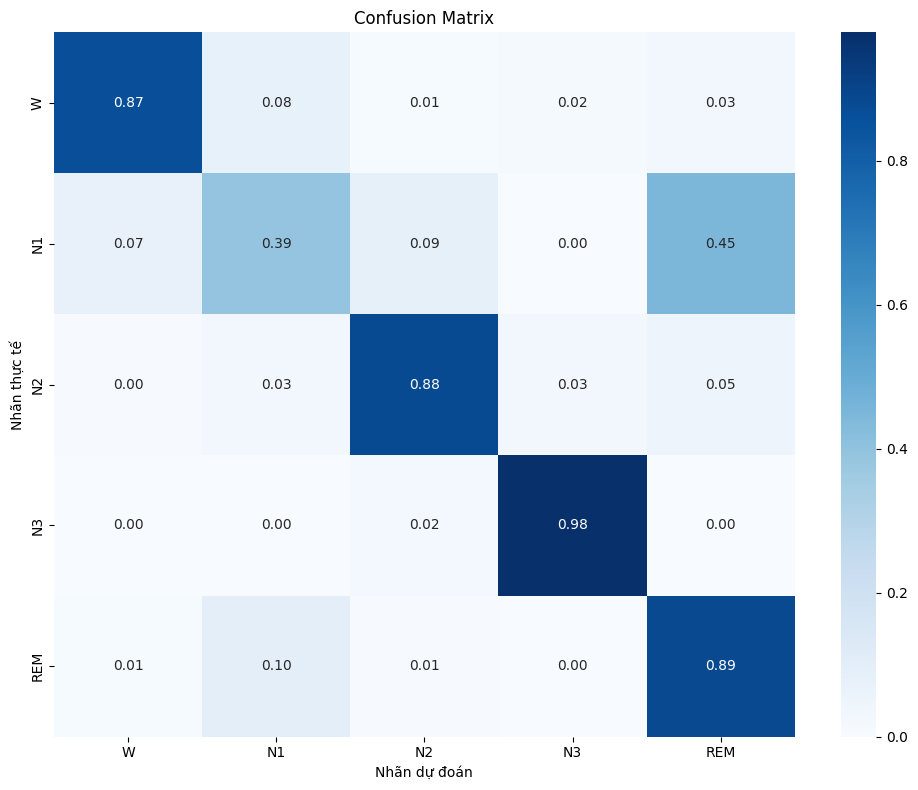

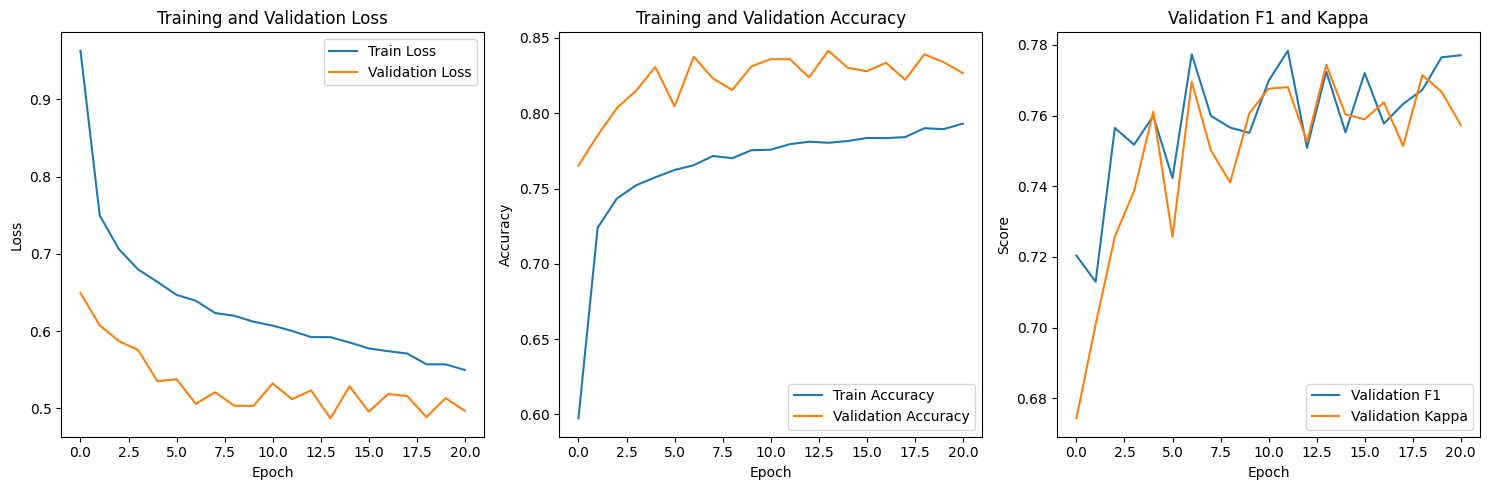


Fold 2/20
Test subject: SC4032
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 92/92 [00:00<00:00, 176.37it/s]


Epoch 1/200: Train Loss: 0.9712, Train Acc: 0.5892, Val Loss: 0.5678, Val Acc: 0.7920, Val F1: 0.7166, Val Kappa: 0.7182
✓ New best model saved! (Val Loss: 0.5678)


Validation: 100%|██████████| 92/92 [00:00<00:00, 185.05it/s]


Epoch 2/200: Train Loss: 0.7557, Train Acc: 0.7183, Val Loss: 0.5050, Val Acc: 0.8019, Val F1: 0.7371, Val Kappa: 0.7313
✓ New best model saved! (Val Loss: 0.5050)


Validation: 100%|██████████| 92/92 [00:00<00:00, 193.09it/s]


Epoch 3/200: Train Loss: 0.7103, Train Acc: 0.7387, Val Loss: 0.5133, Val Acc: 0.8167, Val F1: 0.7468, Val Kappa: 0.7489
! No improvement for 1 epochs


Validation: 100%|██████████| 92/92 [00:00<00:00, 185.04it/s]


Epoch 4/200: Train Loss: 0.6822, Train Acc: 0.7502, Val Loss: 0.4917, Val Acc: 0.8139, Val F1: 0.7557, Val Kappa: 0.7472
✓ New best model saved! (Val Loss: 0.4917)


Validation: 100%|██████████| 92/92 [00:00<00:00, 184.52it/s]


Epoch 5/200: Train Loss: 0.6616, Train Acc: 0.7573, Val Loss: 0.4556, Val Acc: 0.8255, Val F1: 0.7633, Val Kappa: 0.7634
✓ New best model saved! (Val Loss: 0.4556)


Validation: 100%|██████████| 92/92 [00:00<00:00, 186.01it/s]


Epoch 6/200: Train Loss: 0.6451, Train Acc: 0.7643, Val Loss: 0.4780, Val Acc: 0.8194, Val F1: 0.7582, Val Kappa: 0.7539
! No improvement for 1 epochs


Validation: 100%|██████████| 92/92 [00:00<00:00, 177.03it/s]


Epoch 7/200: Train Loss: 0.6327, Train Acc: 0.7693, Val Loss: 0.4592, Val Acc: 0.8266, Val F1: 0.7593, Val Kappa: 0.7623
! No improvement for 2 epochs


Validation: 100%|██████████| 92/92 [00:00<00:00, 185.75it/s]


Epoch 8/200: Train Loss: 0.6263, Train Acc: 0.7703, Val Loss: 0.4469, Val Acc: 0.8315, Val F1: 0.7729, Val Kappa: 0.7717
✓ New best model saved! (Val Loss: 0.4469)


Validation: 100%|██████████| 92/92 [00:00<00:00, 184.35it/s]


Epoch 9/200: Train Loss: 0.6184, Train Acc: 0.7737, Val Loss: 0.4399, Val Acc: 0.8342, Val F1: 0.7744, Val Kappa: 0.7747
✓ New best model saved! (Val Loss: 0.4399)


Validation: 100%|██████████| 92/92 [00:00<00:00, 185.71it/s]


Epoch 10/200: Train Loss: 0.6109, Train Acc: 0.7755, Val Loss: 0.4317, Val Acc: 0.8304, Val F1: 0.7728, Val Kappa: 0.7703
✓ New best model saved! (Val Loss: 0.4317)


Validation: 100%|██████████| 92/92 [00:00<00:00, 189.46it/s]


Epoch 11/200: Train Loss: 0.6013, Train Acc: 0.7771, Val Loss: 0.4102, Val Acc: 0.8633, Val F1: 0.8018, Val Kappa: 0.8121
✓ New best model saved! (Val Loss: 0.4102)


Validation: 100%|██████████| 92/92 [00:00<00:00, 187.36it/s]


Epoch 12/200: Train Loss: 0.5973, Train Acc: 0.7778, Val Loss: 0.4412, Val Acc: 0.8353, Val F1: 0.7713, Val Kappa: 0.7755
! No improvement for 1 epochs


Validation: 100%|██████████| 92/92 [00:00<00:00, 182.43it/s]


Epoch 13/200: Train Loss: 0.5922, Train Acc: 0.7771, Val Loss: 0.4384, Val Acc: 0.8485, Val F1: 0.7883, Val Kappa: 0.7918
! No improvement for 2 epochs


Validation: 100%|██████████| 92/92 [00:00<00:00, 186.91it/s]


Epoch 14/200: Train Loss: 0.5879, Train Acc: 0.7805, Val Loss: 0.4404, Val Acc: 0.8266, Val F1: 0.7669, Val Kappa: 0.7650
! No improvement for 3 epochs


Validation: 100%|██████████| 92/92 [00:00<00:00, 186.06it/s]


Epoch 15/200: Train Loss: 0.5828, Train Acc: 0.7804, Val Loss: 0.4291, Val Acc: 0.8370, Val F1: 0.7788, Val Kappa: 0.7781
! No improvement for 4 epochs


Validation: 100%|██████████| 92/92 [00:00<00:00, 176.62it/s]


Epoch 16/200: Train Loss: 0.5663, Train Acc: 0.7853, Val Loss: 0.4148, Val Acc: 0.8337, Val F1: 0.7792, Val Kappa: 0.7759
! No improvement for 5 epochs


Validation: 100%|██████████| 92/92 [00:00<00:00, 174.55it/s]


Epoch 17/200: Train Loss: 0.5619, Train Acc: 0.7888, Val Loss: 0.4533, Val Acc: 0.8002, Val F1: 0.7464, Val Kappa: 0.7333
! No improvement for 6 epochs


Validation: 100%|██████████| 92/92 [00:00<00:00, 188.22it/s]


Epoch 18/200: Train Loss: 0.5583, Train Acc: 0.7887, Val Loss: 0.4140, Val Acc: 0.8332, Val F1: 0.7742, Val Kappa: 0.7733
! No improvement for 7 epochs
Early stopping triggered after 18 epochs
✓ Loaded best model with Val Loss: 0.4102, Val Acc: 0.8633, Val F1: 0.8018, Val Kappa: 0.8121


Validation: 100%|██████████| 92/92 [00:00<00:00, 178.06it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9597    0.8750    0.9154       272
          N1     0.3496    0.4778    0.4038        90
          N2     0.9426    0.8625    0.9008       800
          N3     0.8521    0.9237    0.8864       262
         REM     0.8069    0.8819    0.8427       398

    accuracy                         0.8584      1822
   macro avg     0.7822    0.8042    0.7898      1822
weighted avg     0.8732    0.8584    0.8637      1822

Per-class F1 scores:
  W: 0.9154
  N1: 0.4038
  N2: 0.9008
  N3: 0.8864
  REM: 0.8427


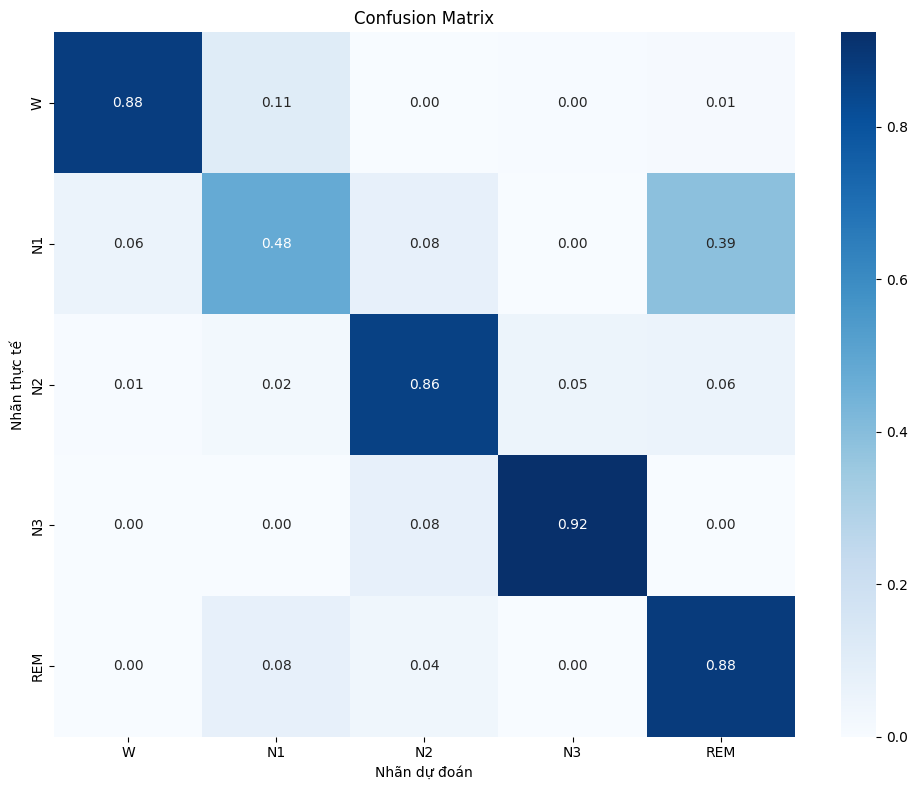

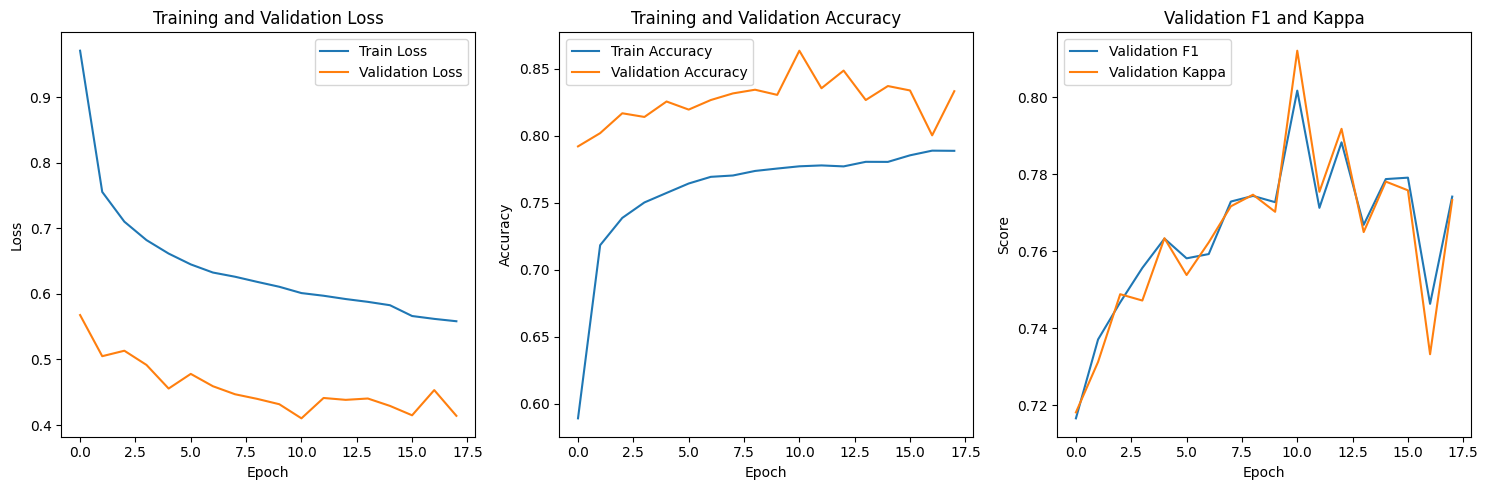


Fold 3/20
Test subject: SC4062
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 102/102 [00:00<00:00, 187.86it/s]


Epoch 1/200: Train Loss: 0.9985, Train Acc: 0.5858, Val Loss: 0.6500, Val Acc: 0.7712, Val F1: 0.7073, Val Kappa: 0.6941
✓ New best model saved! (Val Loss: 0.6500)


Validation: 100%|██████████| 102/102 [00:00<00:00, 185.33it/s]


Epoch 2/200: Train Loss: 0.7489, Train Acc: 0.7250, Val Loss: 0.5770, Val Acc: 0.8061, Val F1: 0.7493, Val Kappa: 0.7374
✓ New best model saved! (Val Loss: 0.5770)


Validation: 100%|██████████| 102/102 [00:00<00:00, 180.23it/s]


Epoch 3/200: Train Loss: 0.7013, Train Acc: 0.7452, Val Loss: 0.5599, Val Acc: 0.7938, Val F1: 0.7504, Val Kappa: 0.7266
✓ New best model saved! (Val Loss: 0.5599)


Validation: 100%|██████████| 102/102 [00:00<00:00, 174.49it/s]


Epoch 4/200: Train Loss: 0.6752, Train Acc: 0.7522, Val Loss: 0.5325, Val Acc: 0.8046, Val F1: 0.7592, Val Kappa: 0.7401
✓ New best model saved! (Val Loss: 0.5325)


Validation: 100%|██████████| 102/102 [00:00<00:00, 164.59it/s]


Epoch 5/200: Train Loss: 0.6583, Train Acc: 0.7612, Val Loss: 0.5288, Val Acc: 0.8140, Val F1: 0.7675, Val Kappa: 0.7503
✓ New best model saved! (Val Loss: 0.5288)


Validation: 100%|██████████| 102/102 [00:00<00:00, 180.85it/s]


Epoch 6/200: Train Loss: 0.6429, Train Acc: 0.7667, Val Loss: 0.5386, Val Acc: 0.8169, Val F1: 0.7662, Val Kappa: 0.7527
! No improvement for 1 epochs


Validation: 100%|██████████| 102/102 [00:00<00:00, 179.31it/s]


Epoch 7/200: Train Loss: 0.6348, Train Acc: 0.7697, Val Loss: 0.4941, Val Acc: 0.8238, Val F1: 0.7779, Val Kappa: 0.7644
✓ New best model saved! (Val Loss: 0.4941)


Validation: 100%|██████████| 102/102 [00:00<00:00, 187.29it/s]


Epoch 8/200: Train Loss: 0.6219, Train Acc: 0.7704, Val Loss: 0.5511, Val Acc: 0.8036, Val F1: 0.7582, Val Kappa: 0.7354
! No improvement for 1 epochs


Validation: 100%|██████████| 102/102 [00:00<00:00, 187.93it/s]


Epoch 9/200: Train Loss: 0.6162, Train Acc: 0.7746, Val Loss: 0.5159, Val Acc: 0.8248, Val F1: 0.7842, Val Kappa: 0.7643
! No improvement for 2 epochs


Validation: 100%|██████████| 102/102 [00:00<00:00, 182.51it/s]


Epoch 10/200: Train Loss: 0.6101, Train Acc: 0.7777, Val Loss: 0.5034, Val Acc: 0.8253, Val F1: 0.7795, Val Kappa: 0.7652
! No improvement for 3 epochs


Validation: 100%|██████████| 102/102 [00:00<00:00, 189.09it/s]


Epoch 11/200: Train Loss: 0.6011, Train Acc: 0.7810, Val Loss: 0.4772, Val Acc: 0.8159, Val F1: 0.7766, Val Kappa: 0.7550
✓ New best model saved! (Val Loss: 0.4772)


Validation: 100%|██████████| 102/102 [00:00<00:00, 177.73it/s]


Epoch 12/200: Train Loss: 0.5978, Train Acc: 0.7809, Val Loss: 0.4983, Val Acc: 0.8302, Val F1: 0.7852, Val Kappa: 0.7712
! No improvement for 1 epochs


Validation: 100%|██████████| 102/102 [00:00<00:00, 185.78it/s]


Epoch 13/200: Train Loss: 0.5951, Train Acc: 0.7803, Val Loss: 0.4894, Val Acc: 0.8273, Val F1: 0.7831, Val Kappa: 0.7674
! No improvement for 2 epochs


Validation: 100%|██████████| 102/102 [00:00<00:00, 179.96it/s]


Epoch 14/200: Train Loss: 0.5849, Train Acc: 0.7815, Val Loss: 0.5132, Val Acc: 0.8273, Val F1: 0.7760, Val Kappa: 0.7660
! No improvement for 3 epochs


Validation: 100%|██████████| 102/102 [00:00<00:00, 183.45it/s]


Epoch 15/200: Train Loss: 0.5821, Train Acc: 0.7828, Val Loss: 0.4974, Val Acc: 0.8194, Val F1: 0.7757, Val Kappa: 0.7578
! No improvement for 4 epochs


Validation: 100%|██████████| 102/102 [00:00<00:00, 181.78it/s]


Epoch 16/200: Train Loss: 0.5686, Train Acc: 0.7878, Val Loss: 0.5142, Val Acc: 0.8253, Val F1: 0.7727, Val Kappa: 0.7647
! No improvement for 5 epochs


Validation: 100%|██████████| 102/102 [00:00<00:00, 179.34it/s]


Epoch 17/200: Train Loss: 0.5649, Train Acc: 0.7868, Val Loss: 0.4866, Val Acc: 0.8179, Val F1: 0.7757, Val Kappa: 0.7567
! No improvement for 6 epochs


Validation: 100%|██████████| 102/102 [00:00<00:00, 172.80it/s]


Epoch 18/200: Train Loss: 0.5608, Train Acc: 0.7895, Val Loss: 0.5139, Val Acc: 0.8214, Val F1: 0.7750, Val Kappa: 0.7595
! No improvement for 7 epochs
Early stopping triggered after 18 epochs
✓ Loaded best model with Val Loss: 0.4772, Val Acc: 0.8159, Val F1: 0.7766, Val Kappa: 0.7550


Validation: 100%|██████████| 102/102 [00:00<00:00, 182.89it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9922    0.6554    0.7894       386
          N1     0.3698    0.6389    0.4684       180
          N2     0.9246    0.8825    0.9031       834
          N3     0.8543    1.0000    0.9214       258
         REM     0.8207    0.8075    0.8140       374

    accuracy                         0.8189      2032
   macro avg     0.7923    0.7969    0.7793      2032
weighted avg     0.8602    0.8189    0.8289      2032

Per-class F1 scores:
  W: 0.7894
  N1: 0.4684
  N2: 0.9031
  N3: 0.9214
  REM: 0.8140


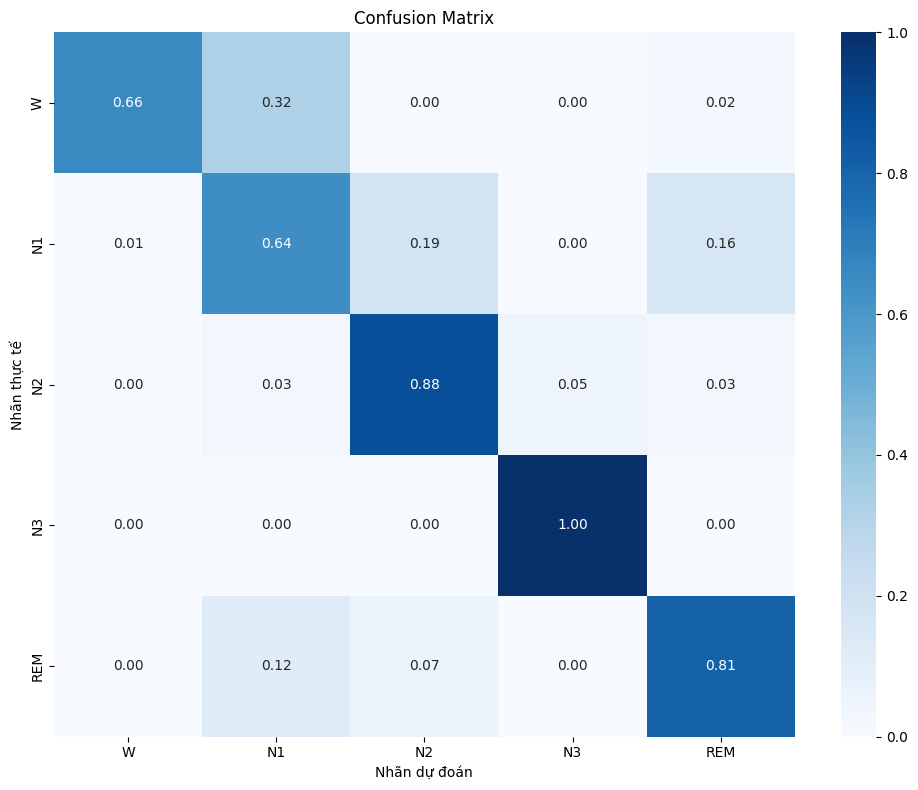

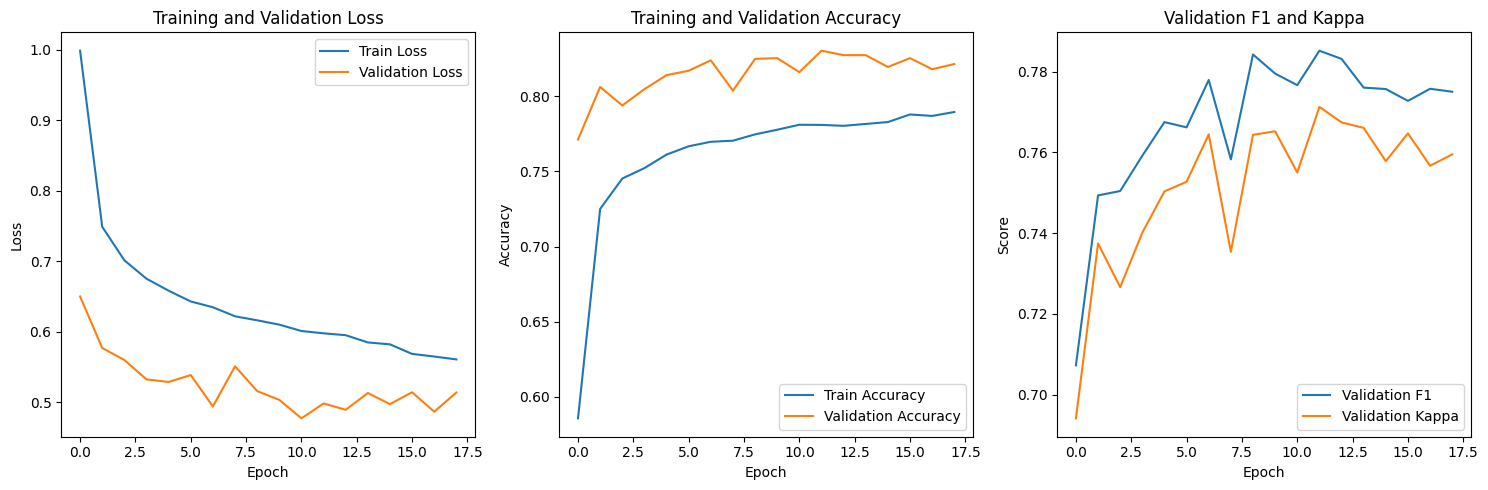


Fold 4/20
Test subject: SC4102
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 110/110 [00:00<00:00, 185.59it/s]


Epoch 1/200: Train Loss: 0.9556, Train Acc: 0.6069, Val Loss: 0.8098, Val Acc: 0.6827, Val F1: 0.5852, Val Kappa: 0.5484
✓ New best model saved! (Val Loss: 0.8098)


Validation: 100%|██████████| 110/110 [00:00<00:00, 185.78it/s]


Epoch 2/200: Train Loss: 0.7590, Train Acc: 0.7224, Val Loss: 0.7456, Val Acc: 0.7138, Val F1: 0.6095, Val Kappa: 0.5889
✓ New best model saved! (Val Loss: 0.7456)


Validation: 100%|██████████| 110/110 [00:00<00:00, 192.49it/s]


Epoch 3/200: Train Loss: 0.7156, Train Acc: 0.7397, Val Loss: 0.6894, Val Acc: 0.7541, Val F1: 0.6640, Val Kappa: 0.6445
✓ New best model saved! (Val Loss: 0.6894)


Validation: 100%|██████████| 110/110 [00:00<00:00, 192.04it/s]


Epoch 4/200: Train Loss: 0.6852, Train Acc: 0.7510, Val Loss: 0.6307, Val Acc: 0.7624, Val F1: 0.6789, Val Kappa: 0.6581
✓ New best model saved! (Val Loss: 0.6307)


Validation: 100%|██████████| 110/110 [00:00<00:00, 178.85it/s]


Epoch 5/200: Train Loss: 0.6644, Train Acc: 0.7597, Val Loss: 0.6410, Val Acc: 0.7715, Val F1: 0.6825, Val Kappa: 0.6689
! No improvement for 1 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 182.56it/s]


Epoch 6/200: Train Loss: 0.6487, Train Acc: 0.7676, Val Loss: 0.6095, Val Acc: 0.7683, Val F1: 0.6853, Val Kappa: 0.6673
✓ New best model saved! (Val Loss: 0.6095)


Validation: 100%|██████████| 110/110 [00:00<00:00, 173.44it/s]


Epoch 7/200: Train Loss: 0.6350, Train Acc: 0.7685, Val Loss: 0.6444, Val Acc: 0.7647, Val F1: 0.6852, Val Kappa: 0.6616
! No improvement for 1 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 182.11it/s]


Epoch 8/200: Train Loss: 0.6233, Train Acc: 0.7737, Val Loss: 0.6471, Val Acc: 0.7427, Val F1: 0.6752, Val Kappa: 0.6385
! No improvement for 2 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 181.66it/s]


Epoch 9/200: Train Loss: 0.6162, Train Acc: 0.7728, Val Loss: 0.6358, Val Acc: 0.7541, Val F1: 0.6550, Val Kappa: 0.6434
! No improvement for 3 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 176.73it/s]


Epoch 10/200: Train Loss: 0.6118, Train Acc: 0.7765, Val Loss: 0.5741, Val Acc: 0.7656, Val F1: 0.6904, Val Kappa: 0.6658
✓ New best model saved! (Val Loss: 0.5741)


Validation: 100%|██████████| 110/110 [00:00<00:00, 182.35it/s]


Epoch 11/200: Train Loss: 0.6024, Train Acc: 0.7783, Val Loss: 0.5741, Val Acc: 0.7688, Val F1: 0.6935, Val Kappa: 0.6702
! No improvement for 1 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 179.85it/s]


Epoch 12/200: Train Loss: 0.5978, Train Acc: 0.7775, Val Loss: 0.6054, Val Acc: 0.7642, Val F1: 0.6821, Val Kappa: 0.6628
! No improvement for 2 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 179.14it/s]


Epoch 13/200: Train Loss: 0.5903, Train Acc: 0.7813, Val Loss: 0.5833, Val Acc: 0.7715, Val F1: 0.6893, Val Kappa: 0.6720
! No improvement for 3 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 181.20it/s]


Epoch 14/200: Train Loss: 0.5892, Train Acc: 0.7790, Val Loss: 0.5994, Val Acc: 0.7550, Val F1: 0.6845, Val Kappa: 0.6536
! No improvement for 4 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 186.69it/s]


Epoch 15/200: Train Loss: 0.5692, Train Acc: 0.7889, Val Loss: 0.5685, Val Acc: 0.7679, Val F1: 0.6912, Val Kappa: 0.6691
✓ New best model saved! (Val Loss: 0.5685)


Validation: 100%|██████████| 110/110 [00:00<00:00, 181.91it/s]


Epoch 16/200: Train Loss: 0.5670, Train Acc: 0.7873, Val Loss: 0.5036, Val Acc: 0.7779, Val F1: 0.7050, Val Kappa: 0.6838
✓ New best model saved! (Val Loss: 0.5036)


Validation: 100%|██████████| 110/110 [00:00<00:00, 162.80it/s]


Epoch 17/200: Train Loss: 0.5627, Train Acc: 0.7897, Val Loss: 0.5408, Val Acc: 0.7839, Val F1: 0.7089, Val Kappa: 0.6900
! No improvement for 1 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 176.48it/s]


Epoch 18/200: Train Loss: 0.5616, Train Acc: 0.7894, Val Loss: 0.5195, Val Acc: 0.7990, Val F1: 0.7123, Val Kappa: 0.7066
! No improvement for 2 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 183.02it/s]


Epoch 19/200: Train Loss: 0.5597, Train Acc: 0.7889, Val Loss: 0.5766, Val Acc: 0.7720, Val F1: 0.6949, Val Kappa: 0.6738
! No improvement for 3 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 171.20it/s]


Epoch 20/200: Train Loss: 0.5559, Train Acc: 0.7919, Val Loss: 0.5687, Val Acc: 0.7738, Val F1: 0.6968, Val Kappa: 0.6773
! No improvement for 4 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 175.70it/s]


Epoch 21/200: Train Loss: 0.5488, Train Acc: 0.7931, Val Loss: 0.5502, Val Acc: 0.7756, Val F1: 0.6962, Val Kappa: 0.6778
! No improvement for 5 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 185.32it/s]


Epoch 22/200: Train Loss: 0.5462, Train Acc: 0.7917, Val Loss: 0.5308, Val Acc: 0.7761, Val F1: 0.6974, Val Kappa: 0.6791
! No improvement for 6 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 179.40it/s]


Epoch 23/200: Train Loss: 0.5426, Train Acc: 0.7934, Val Loss: 0.5014, Val Acc: 0.7834, Val F1: 0.7072, Val Kappa: 0.6901
✓ New best model saved! (Val Loss: 0.5014)


Validation: 100%|██████████| 110/110 [00:00<00:00, 190.76it/s]


Epoch 24/200: Train Loss: 0.5404, Train Acc: 0.7963, Val Loss: 0.5741, Val Acc: 0.7830, Val F1: 0.6925, Val Kappa: 0.6832
! No improvement for 1 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 174.75it/s]


Epoch 25/200: Train Loss: 0.5405, Train Acc: 0.7940, Val Loss: 0.5652, Val Acc: 0.7587, Val F1: 0.6881, Val Kappa: 0.6600
! No improvement for 2 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 178.95it/s]


Epoch 26/200: Train Loss: 0.5384, Train Acc: 0.7948, Val Loss: 0.5266, Val Acc: 0.7766, Val F1: 0.7072, Val Kappa: 0.6833
! No improvement for 3 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 179.42it/s]


Epoch 27/200: Train Loss: 0.5390, Train Acc: 0.7935, Val Loss: 0.6035, Val Acc: 0.7578, Val F1: 0.6820, Val Kappa: 0.6565
! No improvement for 4 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 184.85it/s]


Epoch 28/200: Train Loss: 0.5316, Train Acc: 0.7969, Val Loss: 0.5454, Val Acc: 0.7651, Val F1: 0.6947, Val Kappa: 0.6671
! No improvement for 5 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 177.04it/s]


Epoch 29/200: Train Loss: 0.5341, Train Acc: 0.7979, Val Loss: 0.5376, Val Acc: 0.7857, Val F1: 0.7161, Val Kappa: 0.6941
! No improvement for 6 epochs


Validation: 100%|██████████| 110/110 [00:00<00:00, 176.75it/s]


Epoch 30/200: Train Loss: 0.5352, Train Acc: 0.7955, Val Loss: 0.5492, Val Acc: 0.7811, Val F1: 0.6988, Val Kappa: 0.6852
! No improvement for 7 epochs
Early stopping triggered after 30 epochs
✓ Loaded best model with Val Loss: 0.5014, Val Acc: 0.7834, Val F1: 0.7072, Val Kappa: 0.6901


Validation: 100%|██████████| 110/110 [00:00<00:00, 187.93it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9588    0.8090    0.8776       288
          N1     0.5341    0.8034    0.6416       234
          N2     0.9858    0.7430    0.8473      1214
          N3     0.2041    1.0000    0.3390        50
         REM     0.8112    0.8744    0.8416       398

    accuracy                         0.7880      2184
   macro avg     0.6988    0.8460    0.7094      2184
weighted avg     0.8841    0.7880    0.8166      2184

Per-class F1 scores:
  W: 0.8776
  N1: 0.6416
  N2: 0.8473
  N3: 0.3390
  REM: 0.8416


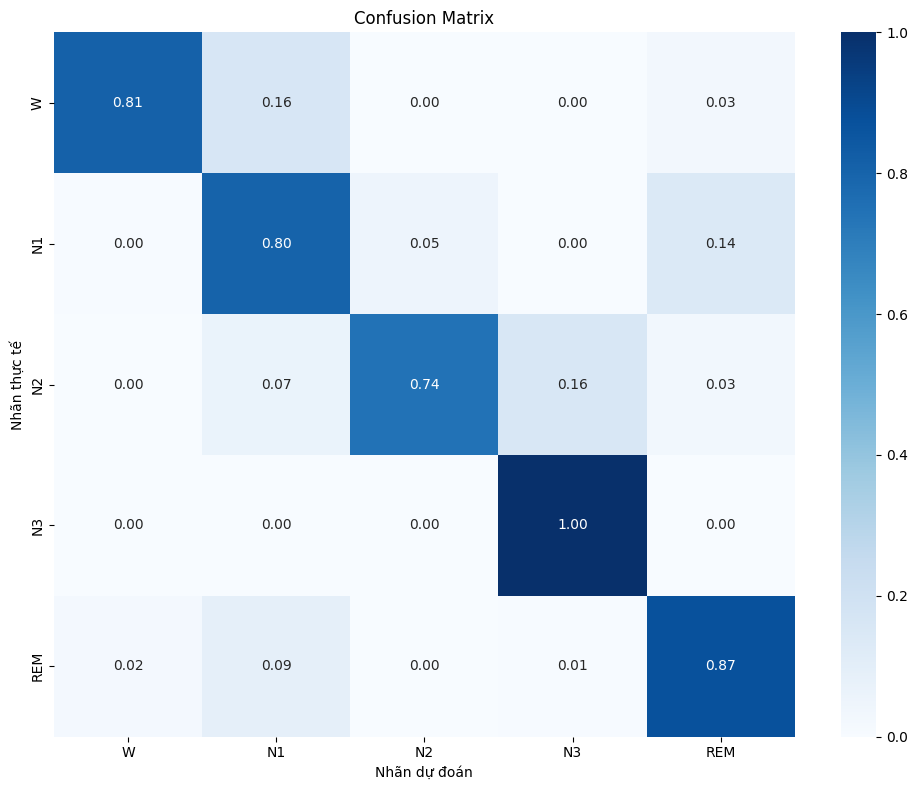

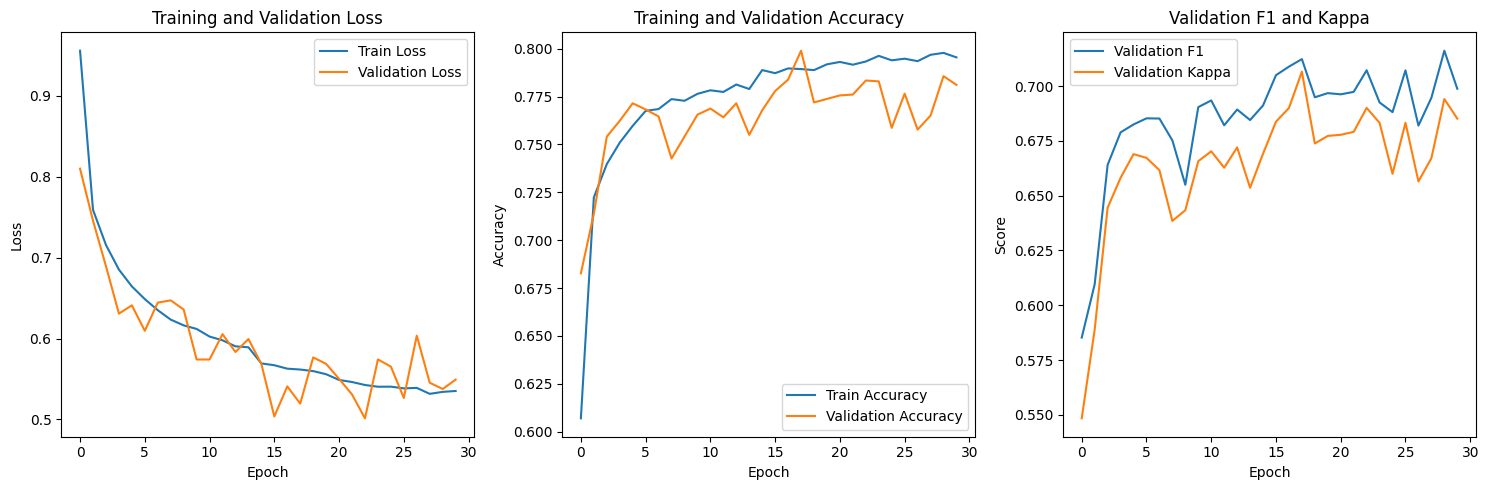


Fold 5/20
Test subject: SC4172
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 178/178 [00:00<00:00, 185.83it/s]


Epoch 1/200: Train Loss: 1.0013, Train Acc: 0.5931, Val Loss: 0.6995, Val Acc: 0.7276, Val F1: 0.6142, Val Kappa: 0.6289
✓ New best model saved! (Val Loss: 0.6995)


Validation: 100%|██████████| 178/178 [00:01<00:00, 177.30it/s]


Epoch 2/200: Train Loss: 0.7493, Train Acc: 0.7268, Val Loss: 0.6488, Val Acc: 0.7270, Val F1: 0.6114, Val Kappa: 0.6311
✓ New best model saved! (Val Loss: 0.6488)


Validation: 100%|██████████| 178/178 [00:00<00:00, 198.64it/s]


Epoch 3/200: Train Loss: 0.7035, Train Acc: 0.7463, Val Loss: 0.8075, Val Acc: 0.6734, Val F1: 0.5755, Val Kappa: 0.5712
! No improvement for 1 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 202.39it/s]


Epoch 4/200: Train Loss: 0.6712, Train Acc: 0.7586, Val Loss: 0.6765, Val Acc: 0.7078, Val F1: 0.5783, Val Kappa: 0.6098
! No improvement for 2 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 181.31it/s]


Epoch 5/200: Train Loss: 0.6541, Train Acc: 0.7626, Val Loss: 0.6982, Val Acc: 0.7129, Val F1: 0.5962, Val Kappa: 0.6172
! No improvement for 3 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 191.99it/s]


Epoch 6/200: Train Loss: 0.6418, Train Acc: 0.7676, Val Loss: 0.6078, Val Acc: 0.7343, Val F1: 0.5975, Val Kappa: 0.6412
✓ New best model saved! (Val Loss: 0.6078)


Validation: 100%|██████████| 178/178 [00:00<00:00, 193.98it/s]


Epoch 7/200: Train Loss: 0.6312, Train Acc: 0.7721, Val Loss: 0.7044, Val Acc: 0.7112, Val F1: 0.5913, Val Kappa: 0.6115
! No improvement for 1 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 203.64it/s]


Epoch 8/200: Train Loss: 0.6271, Train Acc: 0.7698, Val Loss: 0.6879, Val Acc: 0.6873, Val F1: 0.5571, Val Kappa: 0.5860
! No improvement for 2 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 200.13it/s]


Epoch 9/200: Train Loss: 0.6184, Train Acc: 0.7734, Val Loss: 0.6094, Val Acc: 0.7493, Val F1: 0.6295, Val Kappa: 0.6619
! No improvement for 3 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 193.04it/s]


Epoch 10/200: Train Loss: 0.6081, Train Acc: 0.7771, Val Loss: 0.5643, Val Acc: 0.7518, Val F1: 0.6256, Val Kappa: 0.6625
✓ New best model saved! (Val Loss: 0.5643)


Validation: 100%|██████████| 178/178 [00:00<00:00, 192.22it/s]


Epoch 11/200: Train Loss: 0.6062, Train Acc: 0.7765, Val Loss: 0.5984, Val Acc: 0.7422, Val F1: 0.6151, Val Kappa: 0.6516
! No improvement for 1 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 195.51it/s]


Epoch 12/200: Train Loss: 0.6041, Train Acc: 0.7801, Val Loss: 0.5951, Val Acc: 0.7493, Val F1: 0.6342, Val Kappa: 0.6602
! No improvement for 2 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 187.46it/s]


Epoch 13/200: Train Loss: 0.5949, Train Acc: 0.7820, Val Loss: 0.6013, Val Acc: 0.7578, Val F1: 0.6397, Val Kappa: 0.6714
! No improvement for 3 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 186.02it/s]


Epoch 14/200: Train Loss: 0.5860, Train Acc: 0.7832, Val Loss: 0.5604, Val Acc: 0.7682, Val F1: 0.6291, Val Kappa: 0.6827
✓ New best model saved! (Val Loss: 0.5604)


Validation: 100%|██████████| 178/178 [00:00<00:00, 185.97it/s]


Epoch 15/200: Train Loss: 0.5840, Train Acc: 0.7827, Val Loss: 0.5371, Val Acc: 0.7625, Val F1: 0.6180, Val Kappa: 0.6748
✓ New best model saved! (Val Loss: 0.5371)


Validation: 100%|██████████| 178/178 [00:00<00:00, 203.78it/s]


Epoch 16/200: Train Loss: 0.5783, Train Acc: 0.7856, Val Loss: 0.6335, Val Acc: 0.7050, Val F1: 0.5941, Val Kappa: 0.6095
! No improvement for 1 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 186.61it/s]


Epoch 17/200: Train Loss: 0.5733, Train Acc: 0.7844, Val Loss: 0.5511, Val Acc: 0.7524, Val F1: 0.6319, Val Kappa: 0.6648
! No improvement for 2 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 198.41it/s]


Epoch 18/200: Train Loss: 0.5711, Train Acc: 0.7861, Val Loss: 0.5981, Val Acc: 0.7242, Val F1: 0.6119, Val Kappa: 0.6322
! No improvement for 3 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 198.05it/s]


Epoch 19/200: Train Loss: 0.5697, Train Acc: 0.7847, Val Loss: 0.5134, Val Acc: 0.7857, Val F1: 0.6527, Val Kappa: 0.7043
✓ New best model saved! (Val Loss: 0.5134)


Validation: 100%|██████████| 178/178 [00:00<00:00, 205.22it/s]


Epoch 20/200: Train Loss: 0.5632, Train Acc: 0.7889, Val Loss: 0.5512, Val Acc: 0.7549, Val F1: 0.6382, Val Kappa: 0.6683
! No improvement for 1 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 193.38it/s]


Epoch 21/200: Train Loss: 0.5588, Train Acc: 0.7878, Val Loss: 0.6156, Val Acc: 0.6935, Val F1: 0.5757, Val Kappa: 0.5939
! No improvement for 2 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 182.01it/s]


Epoch 22/200: Train Loss: 0.5571, Train Acc: 0.7887, Val Loss: 0.5573, Val Acc: 0.7451, Val F1: 0.6152, Val Kappa: 0.6554
! No improvement for 3 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 192.51it/s]


Epoch 23/200: Train Loss: 0.5563, Train Acc: 0.7877, Val Loss: 0.6448, Val Acc: 0.6977, Val F1: 0.5893, Val Kappa: 0.6017
! No improvement for 4 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 190.27it/s]


Epoch 24/200: Train Loss: 0.5405, Train Acc: 0.7941, Val Loss: 0.5729, Val Acc: 0.7397, Val F1: 0.6074, Val Kappa: 0.6489
! No improvement for 5 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 195.10it/s]


Epoch 25/200: Train Loss: 0.5386, Train Acc: 0.7953, Val Loss: 0.5828, Val Acc: 0.7439, Val F1: 0.6262, Val Kappa: 0.6540
! No improvement for 6 epochs


Validation: 100%|██████████| 178/178 [00:00<00:00, 195.91it/s]


Epoch 26/200: Train Loss: 0.5367, Train Acc: 0.7954, Val Loss: 0.5827, Val Acc: 0.7408, Val F1: 0.6247, Val Kappa: 0.6514
! No improvement for 7 epochs
Early stopping triggered after 26 epochs
✓ Loaded best model with Val Loss: 0.5134, Val Acc: 0.7857, Val F1: 0.6527, Val Kappa: 0.7043


Validation: 100%|██████████| 178/178 [00:00<00:00, 196.64it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9524    0.9296    0.9409      1378
          N1     0.1419    0.2500    0.1811        88
          N2     0.9701    0.5910    0.7345      1374
          N3     0.5819    0.9734    0.7284       376
         REM     0.5259    0.9242    0.6703       330

    accuracy                         0.7857      3546
   macro avg     0.6344    0.7336    0.6510      3546
weighted avg     0.8602    0.7857    0.7943      3546

Per-class F1 scores:
  W: 0.9409
  N1: 0.1811
  N2: 0.7345
  N3: 0.7284
  REM: 0.6703


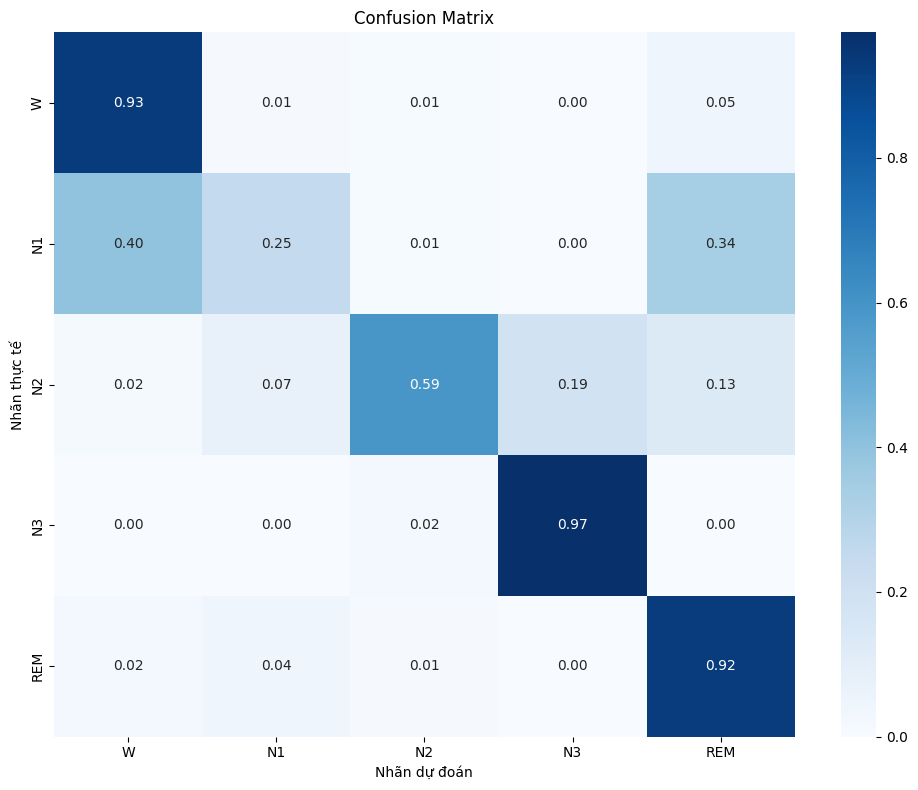

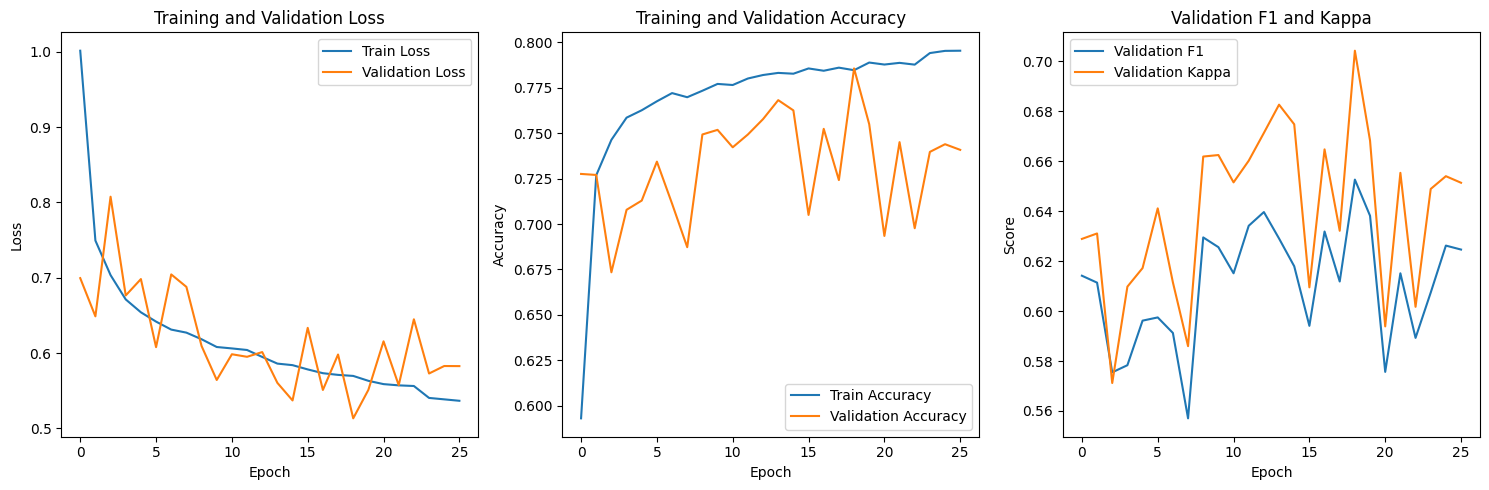


Fold 6/20
Test subject: SC4082
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 106/106 [00:00<00:00, 173.13it/s]


Epoch 1/200: Train Loss: 0.9972, Train Acc: 0.5781, Val Loss: 0.7760, Val Acc: 0.7002, Val F1: 0.6181, Val Kappa: 0.6045
✓ New best model saved! (Val Loss: 0.7760)


Validation: 100%|██████████| 106/106 [00:00<00:00, 171.26it/s]


Epoch 2/200: Train Loss: 0.7505, Train Acc: 0.7224, Val Loss: 0.6799, Val Acc: 0.7030, Val F1: 0.6359, Val Kappa: 0.6196
✓ New best model saved! (Val Loss: 0.6799)


Validation: 100%|██████████| 106/106 [00:00<00:00, 175.47it/s]


Epoch 3/200: Train Loss: 0.7004, Train Acc: 0.7437, Val Loss: 0.6385, Val Acc: 0.7234, Val F1: 0.6513, Val Kappa: 0.6417
✓ New best model saved! (Val Loss: 0.6385)


Validation: 100%|██████████| 106/106 [00:00<00:00, 173.25it/s]


Epoch 4/200: Train Loss: 0.6696, Train Acc: 0.7565, Val Loss: 0.6807, Val Acc: 0.6855, Val F1: 0.6309, Val Kappa: 0.6009
! No improvement for 1 epochs


Validation: 100%|██████████| 106/106 [00:00<00:00, 173.66it/s]


Epoch 5/200: Train Loss: 0.6527, Train Acc: 0.7640, Val Loss: 0.7254, Val Acc: 0.6390, Val F1: 0.5763, Val Kappa: 0.5441
! No improvement for 2 epochs


Validation: 100%|██████████| 106/106 [00:00<00:00, 145.11it/s]


Epoch 6/200: Train Loss: 0.6385, Train Acc: 0.7668, Val Loss: 0.7316, Val Acc: 0.6812, Val F1: 0.6304, Val Kappa: 0.5951
! No improvement for 3 epochs


Validation: 100%|██████████| 106/106 [00:00<00:00, 149.89it/s]


Epoch 7/200: Train Loss: 0.6197, Train Acc: 0.7721, Val Loss: 0.7397, Val Acc: 0.6490, Val F1: 0.6031, Val Kappa: 0.5567
! No improvement for 4 epochs


Validation: 100%|██████████| 106/106 [00:00<00:00, 165.88it/s]


Epoch 8/200: Train Loss: 0.6053, Train Acc: 0.7755, Val Loss: 0.7143, Val Acc: 0.6755, Val F1: 0.6214, Val Kappa: 0.5883
! No improvement for 5 epochs


Validation: 100%|██████████| 106/106 [00:00<00:00, 167.17it/s]


Epoch 9/200: Train Loss: 0.6008, Train Acc: 0.7798, Val Loss: 0.7024, Val Acc: 0.6793, Val F1: 0.6309, Val Kappa: 0.5949
! No improvement for 6 epochs


Validation: 100%|██████████| 106/106 [00:00<00:00, 160.67it/s]


Epoch 10/200: Train Loss: 0.5981, Train Acc: 0.7788, Val Loss: 0.6882, Val Acc: 0.6589, Val F1: 0.6160, Val Kappa: 0.5714
! No improvement for 7 epochs
Early stopping triggered after 10 epochs
✓ Loaded best model with Val Loss: 0.6385, Val Acc: 0.7234, Val F1: 0.6513, Val Kappa: 0.6417


Validation: 100%|██████████| 106/106 [00:00<00:00, 179.22it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9474    0.5625    0.7059       288
          N1     0.1273    0.5256    0.2050        78
          N2     0.8305    0.6778    0.7464       658
          N3     0.8469    0.9415    0.8917       564
         REM     0.7384    0.6404    0.6859       520

    accuracy                         0.7177      2108
   macro avg     0.6981    0.6696    0.6470      2108
weighted avg     0.8021    0.7177    0.7448      2108

Per-class F1 scores:
  W: 0.7059
  N1: 0.2050
  N2: 0.7464
  N3: 0.8917
  REM: 0.6859


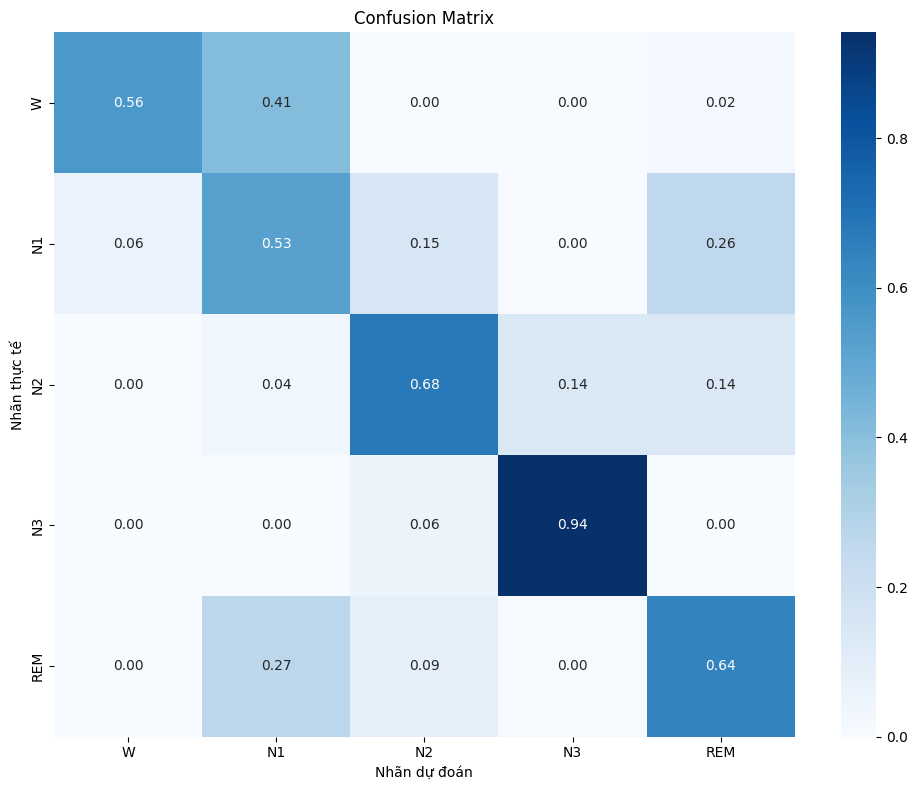

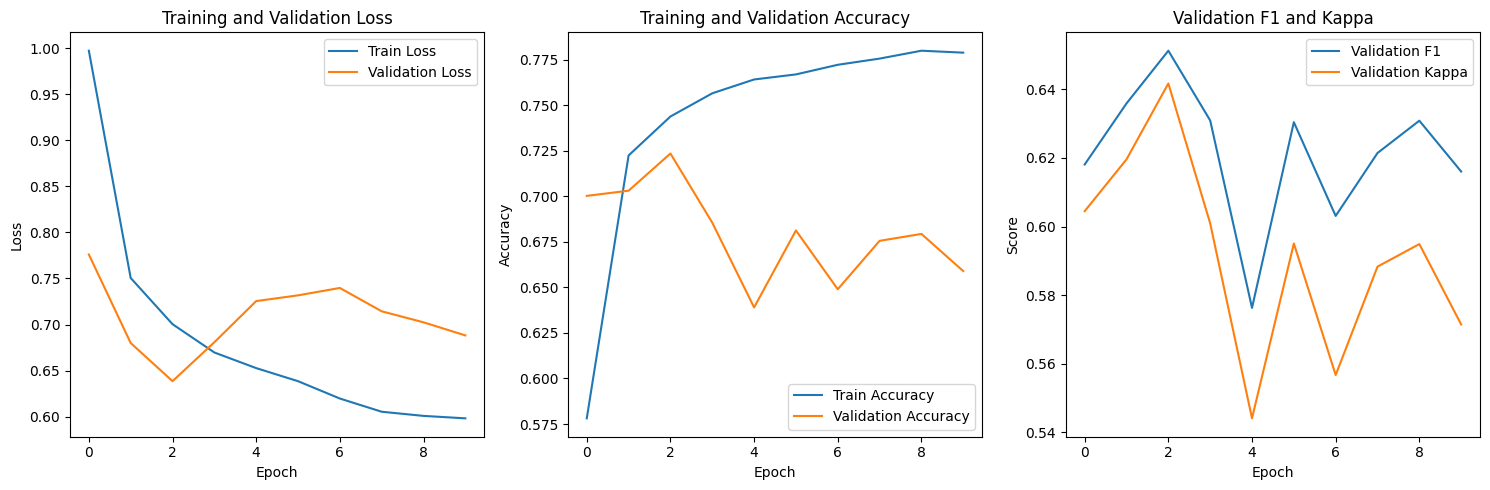


Fold 7/20
Test subject: SC4192
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 128/128 [00:00<00:00, 183.37it/s]


Epoch 1/200: Train Loss: 1.0098, Train Acc: 0.5712, Val Loss: 0.7155, Val Acc: 0.7249, Val F1: 0.6317, Val Kappa: 0.6277
✓ New best model saved! (Val Loss: 0.7155)


Validation: 100%|██████████| 128/128 [00:00<00:00, 186.09it/s]


Epoch 2/200: Train Loss: 0.7573, Train Acc: 0.7206, Val Loss: 0.6862, Val Acc: 0.7535, Val F1: 0.6453, Val Kappa: 0.6633
✓ New best model saved! (Val Loss: 0.6862)


Validation: 100%|██████████| 128/128 [00:00<00:00, 174.83it/s]


Epoch 3/200: Train Loss: 0.7025, Train Acc: 0.7457, Val Loss: 0.6469, Val Acc: 0.7783, Val F1: 0.6786, Val Kappa: 0.6994
✓ New best model saved! (Val Loss: 0.6469)


Validation: 100%|██████████| 128/128 [00:00<00:00, 183.79it/s]


Epoch 4/200: Train Loss: 0.6767, Train Acc: 0.7559, Val Loss: 0.6241, Val Acc: 0.7633, Val F1: 0.6782, Val Kappa: 0.6812
✓ New best model saved! (Val Loss: 0.6241)


Validation: 100%|██████████| 128/128 [00:00<00:00, 170.80it/s]


Epoch 5/200: Train Loss: 0.6563, Train Acc: 0.7622, Val Loss: 0.5856, Val Acc: 0.7747, Val F1: 0.6887, Val Kappa: 0.7000
✓ New best model saved! (Val Loss: 0.5856)


Validation: 100%|██████████| 128/128 [00:00<00:00, 182.35it/s]


Epoch 6/200: Train Loss: 0.6395, Train Acc: 0.7674, Val Loss: 0.6258, Val Acc: 0.7688, Val F1: 0.6781, Val Kappa: 0.6915
! No improvement for 1 epochs


Validation: 100%|██████████| 128/128 [00:00<00:00, 174.59it/s]


Epoch 7/200: Train Loss: 0.6322, Train Acc: 0.7712, Val Loss: 0.6243, Val Acc: 0.7641, Val F1: 0.6874, Val Kappa: 0.6864
! No improvement for 2 epochs


Validation: 100%|██████████| 128/128 [00:00<00:00, 182.53it/s]


Epoch 8/200: Train Loss: 0.6217, Train Acc: 0.7732, Val Loss: 0.5970, Val Acc: 0.7681, Val F1: 0.6837, Val Kappa: 0.6930
! No improvement for 3 epochs


Validation: 100%|██████████| 128/128 [00:00<00:00, 175.59it/s]


Epoch 9/200: Train Loss: 0.6138, Train Acc: 0.7770, Val Loss: 0.5804, Val Acc: 0.7932, Val F1: 0.7139, Val Kappa: 0.7223
✓ New best model saved! (Val Loss: 0.5804)


Validation: 100%|██████████| 128/128 [00:00<00:00, 181.64it/s]


Epoch 10/200: Train Loss: 0.6055, Train Acc: 0.7785, Val Loss: 0.5426, Val Acc: 0.8073, Val F1: 0.7167, Val Kappa: 0.7409
✓ New best model saved! (Val Loss: 0.5426)


Validation: 100%|██████████| 128/128 [00:00<00:00, 181.80it/s]


Epoch 11/200: Train Loss: 0.6037, Train Acc: 0.7777, Val Loss: 0.5909, Val Acc: 0.7755, Val F1: 0.6868, Val Kappa: 0.7002
! No improvement for 1 epochs


Validation: 100%|██████████| 128/128 [00:00<00:00, 158.03it/s]


Epoch 12/200: Train Loss: 0.5945, Train Acc: 0.7817, Val Loss: 0.5720, Val Acc: 0.7920, Val F1: 0.6839, Val Kappa: 0.7200
! No improvement for 2 epochs


Validation: 100%|██████████| 128/128 [00:00<00:00, 177.52it/s]


Epoch 13/200: Train Loss: 0.5894, Train Acc: 0.7824, Val Loss: 0.5489, Val Acc: 0.7924, Val F1: 0.6983, Val Kappa: 0.7219
! No improvement for 3 epochs


Validation: 100%|██████████| 128/128 [00:00<00:00, 173.46it/s]


Epoch 14/200: Train Loss: 0.5790, Train Acc: 0.7843, Val Loss: 0.5707, Val Acc: 0.7684, Val F1: 0.6867, Val Kappa: 0.6935
! No improvement for 4 epochs


Validation: 100%|██████████| 128/128 [00:00<00:00, 179.20it/s]


Epoch 15/200: Train Loss: 0.5679, Train Acc: 0.7875, Val Loss: 0.5708, Val Acc: 0.7814, Val F1: 0.6933, Val Kappa: 0.7098
! No improvement for 5 epochs


Validation: 100%|██████████| 128/128 [00:00<00:00, 183.74it/s]


Epoch 16/200: Train Loss: 0.5609, Train Acc: 0.7883, Val Loss: 0.5728, Val Acc: 0.7775, Val F1: 0.6876, Val Kappa: 0.7042
! No improvement for 6 epochs


Validation: 100%|██████████| 128/128 [00:00<00:00, 186.24it/s]


Epoch 17/200: Train Loss: 0.5599, Train Acc: 0.7906, Val Loss: 0.5542, Val Acc: 0.7775, Val F1: 0.6859, Val Kappa: 0.7046
! No improvement for 7 epochs
Early stopping triggered after 17 epochs
✓ Loaded best model with Val Loss: 0.5426, Val Acc: 0.8073, Val F1: 0.7167, Val Kappa: 0.7409


Validation: 100%|██████████| 128/128 [00:00<00:00, 160.04it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9273    0.7806    0.8477       752
          N1     0.1836    0.3889    0.2494       144
          N2     0.9524    0.8767    0.9130       868
          N3     0.6033    0.9250    0.7303       120
         REM     0.8262    0.7801    0.8025       664

    accuracy                         0.7979      2548
   macro avg     0.6986    0.7503    0.7086      2548
weighted avg     0.8522    0.7979    0.8188      2548

Per-class F1 scores:
  W: 0.8477
  N1: 0.2494
  N2: 0.9130
  N3: 0.7303
  REM: 0.8025


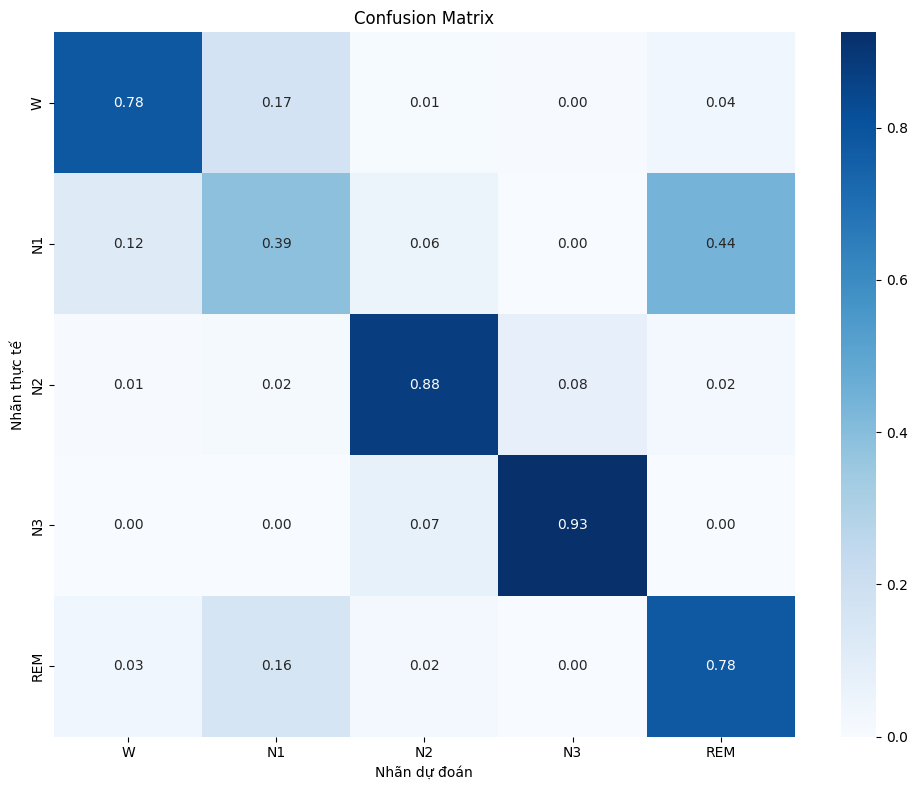

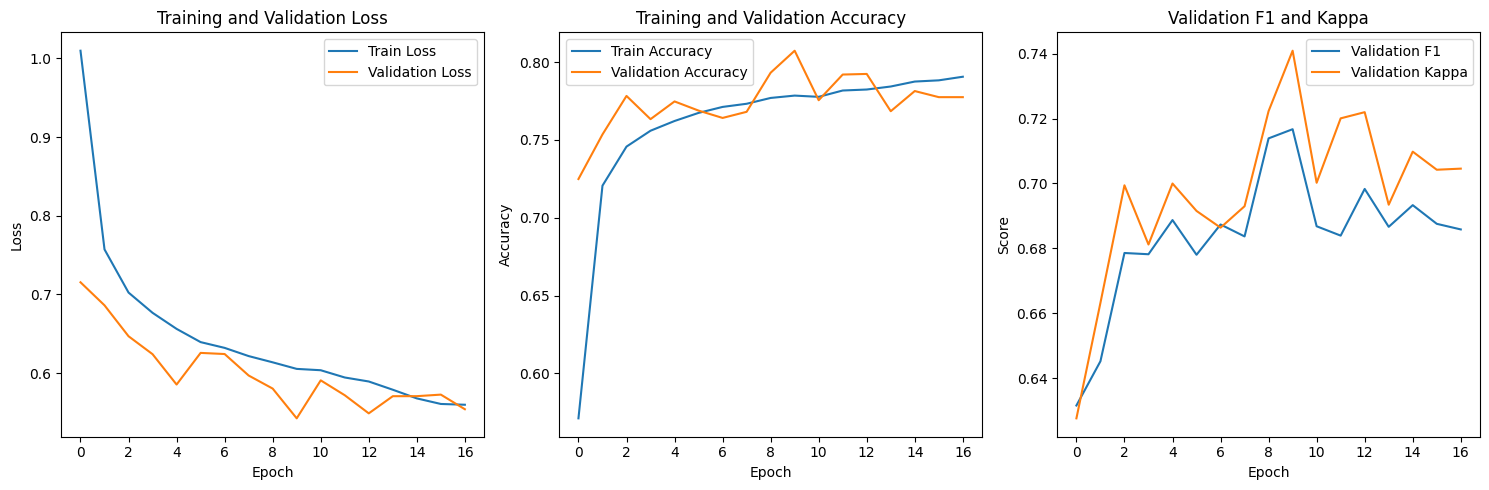


Fold 8/20
Test subject: SC4012
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 119/119 [00:00<00:00, 178.10it/s]


Epoch 1/200: Train Loss: 0.9842, Train Acc: 0.5905, Val Loss: 0.6825, Val Acc: 0.7475, Val F1: 0.6857, Val Kappa: 0.6363
✓ New best model saved! (Val Loss: 0.6825)


Validation: 100%|██████████| 119/119 [00:00<00:00, 159.97it/s]


Epoch 2/200: Train Loss: 0.7468, Train Acc: 0.7257, Val Loss: 0.6566, Val Acc: 0.7437, Val F1: 0.6633, Val Kappa: 0.6322
✓ New best model saved! (Val Loss: 0.6566)


Validation: 100%|██████████| 119/119 [00:00<00:00, 171.78it/s]


Epoch 3/200: Train Loss: 0.7018, Train Acc: 0.7447, Val Loss: 0.6018, Val Acc: 0.7799, Val F1: 0.6942, Val Kappa: 0.6779
✓ New best model saved! (Val Loss: 0.6018)


Validation: 100%|██████████| 119/119 [00:00<00:00, 178.02it/s]


Epoch 4/200: Train Loss: 0.6753, Train Acc: 0.7563, Val Loss: 0.6325, Val Acc: 0.7732, Val F1: 0.6632, Val Kappa: 0.6679
! No improvement for 1 epochs


Validation: 100%|██████████| 119/119 [00:00<00:00, 170.93it/s]


Epoch 5/200: Train Loss: 0.6564, Train Acc: 0.7622, Val Loss: 0.5408, Val Acc: 0.7943, Val F1: 0.7228, Val Kappa: 0.6962
✓ New best model saved! (Val Loss: 0.5408)


Validation: 100%|██████████| 119/119 [00:00<00:00, 159.89it/s]


Epoch 6/200: Train Loss: 0.6438, Train Acc: 0.7679, Val Loss: 0.5730, Val Acc: 0.8010, Val F1: 0.7143, Val Kappa: 0.7051
! No improvement for 1 epochs


Validation: 100%|██████████| 119/119 [00:00<00:00, 180.80it/s]


Epoch 7/200: Train Loss: 0.6312, Train Acc: 0.7709, Val Loss: 0.6054, Val Acc: 0.7740, Val F1: 0.7000, Val Kappa: 0.6726
! No improvement for 2 epochs


Validation: 100%|██████████| 119/119 [00:00<00:00, 171.38it/s]


Epoch 8/200: Train Loss: 0.6224, Train Acc: 0.7738, Val Loss: 0.5838, Val Acc: 0.7879, Val F1: 0.6918, Val Kappa: 0.6886
! No improvement for 3 epochs


Validation: 100%|██████████| 119/119 [00:00<00:00, 168.30it/s]


Epoch 9/200: Train Loss: 0.6139, Train Acc: 0.7745, Val Loss: 0.5317, Val Acc: 0.8069, Val F1: 0.7348, Val Kappa: 0.7136
✓ New best model saved! (Val Loss: 0.5317)


Validation: 100%|██████████| 119/119 [00:00<00:00, 172.54it/s]


Epoch 10/200: Train Loss: 0.6022, Train Acc: 0.7778, Val Loss: 0.5026, Val Acc: 0.8023, Val F1: 0.7447, Val Kappa: 0.7110
✓ New best model saved! (Val Loss: 0.5026)


Validation: 100%|██████████| 119/119 [00:00<00:00, 172.03it/s]


Epoch 11/200: Train Loss: 0.5954, Train Acc: 0.7809, Val Loss: 0.5431, Val Acc: 0.7968, Val F1: 0.7217, Val Kappa: 0.7028
! No improvement for 1 epochs


Validation: 100%|██████████| 119/119 [00:00<00:00, 180.97it/s]


Epoch 12/200: Train Loss: 0.5939, Train Acc: 0.7803, Val Loss: 0.5708, Val Acc: 0.7905, Val F1: 0.7170, Val Kappa: 0.6942
! No improvement for 2 epochs


Validation: 100%|██████████| 119/119 [00:00<00:00, 172.62it/s]


Epoch 13/200: Train Loss: 0.5852, Train Acc: 0.7838, Val Loss: 0.5803, Val Acc: 0.7732, Val F1: 0.7278, Val Kappa: 0.6772
! No improvement for 3 epochs


Validation: 100%|██████████| 119/119 [00:00<00:00, 160.96it/s]


Epoch 14/200: Train Loss: 0.5794, Train Acc: 0.7843, Val Loss: 0.4927, Val Acc: 0.8175, Val F1: 0.7625, Val Kappa: 0.7328
✓ New best model saved! (Val Loss: 0.4927)


Validation: 100%|██████████| 119/119 [00:00<00:00, 175.88it/s]


Epoch 15/200: Train Loss: 0.5796, Train Acc: 0.7840, Val Loss: 0.6485, Val Acc: 0.7774, Val F1: 0.6845, Val Kappa: 0.6737
! No improvement for 1 epochs


Validation: 100%|██████████| 119/119 [00:00<00:00, 170.00it/s]


Epoch 16/200: Train Loss: 0.5748, Train Acc: 0.7842, Val Loss: 0.5376, Val Acc: 0.7934, Val F1: 0.7190, Val Kappa: 0.6975
! No improvement for 2 epochs


Validation: 100%|██████████| 119/119 [00:00<00:00, 170.33it/s]


Epoch 17/200: Train Loss: 0.5714, Train Acc: 0.7855, Val Loss: 0.5971, Val Acc: 0.7766, Val F1: 0.7098, Val Kappa: 0.6762
! No improvement for 3 epochs


Validation: 100%|██████████| 119/119 [00:00<00:00, 175.14it/s]


Epoch 18/200: Train Loss: 0.5644, Train Acc: 0.7892, Val Loss: 0.6167, Val Acc: 0.7681, Val F1: 0.6970, Val Kappa: 0.6667
! No improvement for 4 epochs


Validation: 100%|██████████| 119/119 [00:00<00:00, 177.26it/s]


Epoch 19/200: Train Loss: 0.5506, Train Acc: 0.7925, Val Loss: 0.5064, Val Acc: 0.7955, Val F1: 0.7362, Val Kappa: 0.7030
! No improvement for 5 epochs


Validation: 100%|██████████| 119/119 [00:00<00:00, 166.39it/s]


Epoch 20/200: Train Loss: 0.5467, Train Acc: 0.7937, Val Loss: 0.5691, Val Acc: 0.7791, Val F1: 0.7113, Val Kappa: 0.6814
! No improvement for 6 epochs


Validation: 100%|██████████| 119/119 [00:00<00:00, 164.68it/s]


Epoch 21/200: Train Loss: 0.5444, Train Acc: 0.7938, Val Loss: 0.5450, Val Acc: 0.7584, Val F1: 0.7135, Val Kappa: 0.6602
! No improvement for 7 epochs
Early stopping triggered after 21 epochs
✓ Loaded best model with Val Loss: 0.4927, Val Acc: 0.8175, Val F1: 0.7625, Val Kappa: 0.7328


Validation: 100%|██████████| 119/119 [00:00<00:00, 169.64it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9422    0.8549    0.8964       324
          N1     0.4378    0.5543    0.4892       184
          N2     0.9852    0.8083    0.8881      1320
          N3     0.6373    0.9792    0.7721       192
         REM     0.6702    0.8892    0.7643       352

    accuracy                         0.8208      2372
   macro avg     0.7345    0.8172    0.7620      2372
weighted avg     0.8620    0.8208    0.8305      2372

Per-class F1 scores:
  W: 0.8964
  N1: 0.4892
  N2: 0.8881
  N3: 0.7721
  REM: 0.7643


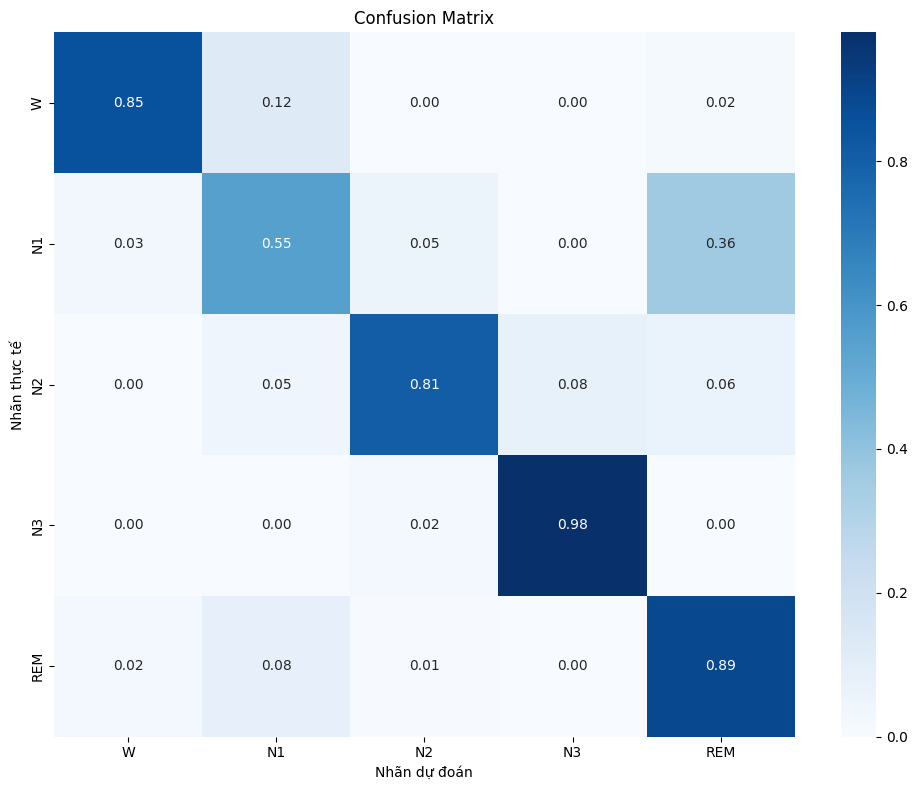

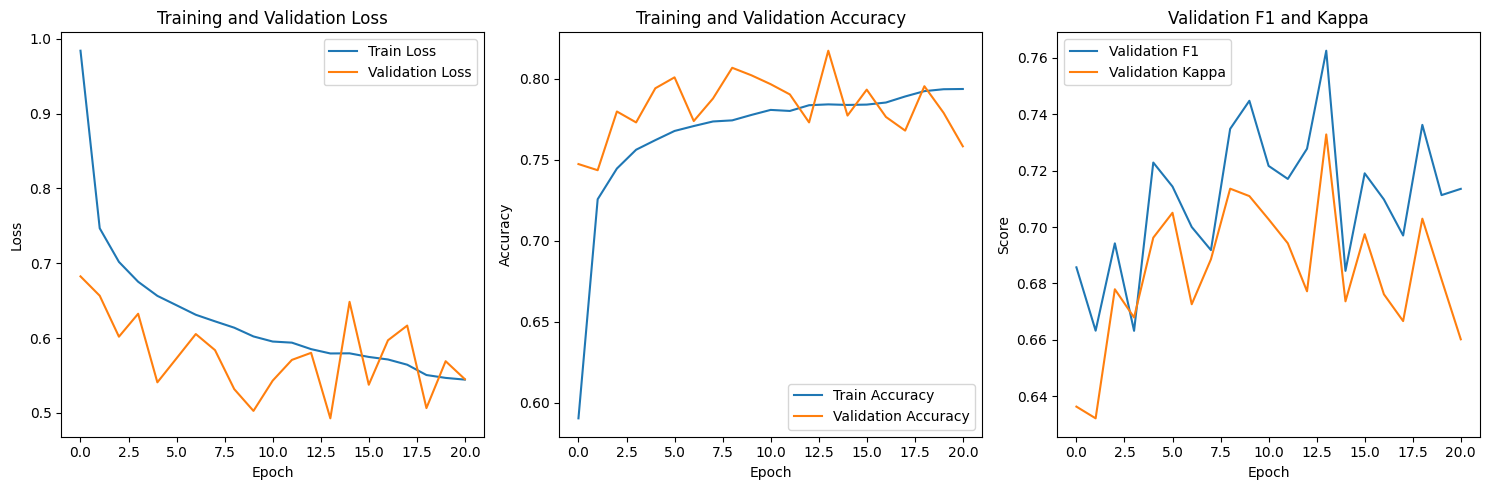


Fold 9/20
Test subject: SC4131
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 103/103 [00:00<00:00, 160.13it/s]


Epoch 1/200: Train Loss: 0.9801, Train Acc: 0.5965, Val Loss: 0.5534, Val Acc: 0.7816, Val F1: 0.7378, Val Kappa: 0.7051
✓ New best model saved! (Val Loss: 0.5534)


Validation: 100%|██████████| 103/103 [00:00<00:00, 164.38it/s]


Epoch 2/200: Train Loss: 0.7483, Train Acc: 0.7258, Val Loss: 0.5325, Val Acc: 0.7923, Val F1: 0.7570, Val Kappa: 0.7196
✓ New best model saved! (Val Loss: 0.5325)


Validation: 100%|██████████| 103/103 [00:00<00:00, 169.04it/s]


Epoch 3/200: Train Loss: 0.7018, Train Acc: 0.7443, Val Loss: 0.5088, Val Acc: 0.8059, Val F1: 0.7685, Val Kappa: 0.7353
✓ New best model saved! (Val Loss: 0.5088)


Validation: 100%|██████████| 103/103 [00:00<00:00, 167.87it/s]


Epoch 4/200: Train Loss: 0.6801, Train Acc: 0.7534, Val Loss: 0.4723, Val Acc: 0.8089, Val F1: 0.7738, Val Kappa: 0.7403
✓ New best model saved! (Val Loss: 0.4723)


Validation: 100%|██████████| 103/103 [00:00<00:00, 165.82it/s]


Epoch 5/200: Train Loss: 0.6632, Train Acc: 0.7586, Val Loss: 0.4975, Val Acc: 0.7933, Val F1: 0.7624, Val Kappa: 0.7225
! No improvement for 1 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 158.92it/s]


Epoch 6/200: Train Loss: 0.6459, Train Acc: 0.7636, Val Loss: 0.4844, Val Acc: 0.8001, Val F1: 0.7644, Val Kappa: 0.7305
! No improvement for 2 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 172.75it/s]


Epoch 7/200: Train Loss: 0.6352, Train Acc: 0.7677, Val Loss: 0.4543, Val Acc: 0.7991, Val F1: 0.7658, Val Kappa: 0.7303
✓ New best model saved! (Val Loss: 0.4543)


Validation: 100%|██████████| 103/103 [00:00<00:00, 157.27it/s]


Epoch 8/200: Train Loss: 0.6280, Train Acc: 0.7701, Val Loss: 0.4737, Val Acc: 0.8045, Val F1: 0.7762, Val Kappa: 0.7372
! No improvement for 1 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 164.47it/s]


Epoch 9/200: Train Loss: 0.6198, Train Acc: 0.7721, Val Loss: 0.4584, Val Acc: 0.8234, Val F1: 0.7918, Val Kappa: 0.7607
! No improvement for 2 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 167.48it/s]


Epoch 10/200: Train Loss: 0.6111, Train Acc: 0.7741, Val Loss: 0.4685, Val Acc: 0.8011, Val F1: 0.7718, Val Kappa: 0.7332
! No improvement for 3 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 149.18it/s]


Epoch 11/200: Train Loss: 0.6079, Train Acc: 0.7754, Val Loss: 0.4869, Val Acc: 0.7972, Val F1: 0.7710, Val Kappa: 0.7285
! No improvement for 4 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 161.34it/s]


Epoch 12/200: Train Loss: 0.5880, Train Acc: 0.7796, Val Loss: 0.4680, Val Acc: 0.8045, Val F1: 0.7760, Val Kappa: 0.7383
! No improvement for 5 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 159.48it/s]


Epoch 13/200: Train Loss: 0.5857, Train Acc: 0.7812, Val Loss: 0.4369, Val Acc: 0.8191, Val F1: 0.7834, Val Kappa: 0.7547
✓ New best model saved! (Val Loss: 0.4369)


Validation: 100%|██████████| 103/103 [00:00<00:00, 162.63it/s]


Epoch 14/200: Train Loss: 0.5806, Train Acc: 0.7848, Val Loss: 0.4467, Val Acc: 0.8225, Val F1: 0.7916, Val Kappa: 0.7599
! No improvement for 1 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 164.67it/s]


Epoch 15/200: Train Loss: 0.5795, Train Acc: 0.7834, Val Loss: 0.4312, Val Acc: 0.8171, Val F1: 0.7864, Val Kappa: 0.7532
✓ New best model saved! (Val Loss: 0.4312)


Validation: 100%|██████████| 103/103 [00:00<00:00, 157.51it/s]


Epoch 16/200: Train Loss: 0.5775, Train Acc: 0.7838, Val Loss: 0.4435, Val Acc: 0.8084, Val F1: 0.7745, Val Kappa: 0.7417
! No improvement for 1 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 166.08it/s]


Epoch 17/200: Train Loss: 0.5724, Train Acc: 0.7862, Val Loss: 0.4739, Val Acc: 0.7962, Val F1: 0.7650, Val Kappa: 0.7268
! No improvement for 2 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 154.58it/s]


Epoch 18/200: Train Loss: 0.5700, Train Acc: 0.7855, Val Loss: 0.4243, Val Acc: 0.8196, Val F1: 0.7857, Val Kappa: 0.7552
✓ New best model saved! (Val Loss: 0.4243)


Validation: 100%|██████████| 103/103 [00:00<00:00, 161.47it/s]


Epoch 19/200: Train Loss: 0.5706, Train Acc: 0.7852, Val Loss: 0.4571, Val Acc: 0.8020, Val F1: 0.7758, Val Kappa: 0.7348
! No improvement for 1 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 165.98it/s]


Epoch 20/200: Train Loss: 0.5706, Train Acc: 0.7863, Val Loss: 0.4535, Val Acc: 0.8011, Val F1: 0.7714, Val Kappa: 0.7333
! No improvement for 2 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 153.47it/s]


Epoch 21/200: Train Loss: 0.5609, Train Acc: 0.7886, Val Loss: 0.4479, Val Acc: 0.8064, Val F1: 0.7752, Val Kappa: 0.7401
! No improvement for 3 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 161.09it/s]


Epoch 22/200: Train Loss: 0.5600, Train Acc: 0.7891, Val Loss: 0.4213, Val Acc: 0.8230, Val F1: 0.7884, Val Kappa: 0.7601
✓ New best model saved! (Val Loss: 0.4213)


Validation: 100%|██████████| 103/103 [00:00<00:00, 161.01it/s]


Epoch 23/200: Train Loss: 0.5602, Train Acc: 0.7877, Val Loss: 0.4351, Val Acc: 0.8166, Val F1: 0.7837, Val Kappa: 0.7522
! No improvement for 1 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 164.45it/s]


Epoch 24/200: Train Loss: 0.5563, Train Acc: 0.7896, Val Loss: 0.4363, Val Acc: 0.8161, Val F1: 0.7853, Val Kappa: 0.7521
! No improvement for 2 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 163.81it/s]


Epoch 25/200: Train Loss: 0.5572, Train Acc: 0.7896, Val Loss: 0.4319, Val Acc: 0.8268, Val F1: 0.7958, Val Kappa: 0.7652
! No improvement for 3 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 145.73it/s]


Epoch 26/200: Train Loss: 0.5545, Train Acc: 0.7903, Val Loss: 0.4623, Val Acc: 0.8059, Val F1: 0.7728, Val Kappa: 0.7389
! No improvement for 4 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 149.63it/s]


Epoch 27/200: Train Loss: 0.5463, Train Acc: 0.7920, Val Loss: 0.4368, Val Acc: 0.8127, Val F1: 0.7785, Val Kappa: 0.7475
! No improvement for 5 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 168.46it/s]


Epoch 28/200: Train Loss: 0.5410, Train Acc: 0.7948, Val Loss: 0.4516, Val Acc: 0.8020, Val F1: 0.7744, Val Kappa: 0.7354
! No improvement for 6 epochs


Validation: 100%|██████████| 103/103 [00:00<00:00, 162.76it/s]


Epoch 29/200: Train Loss: 0.5414, Train Acc: 0.7926, Val Loss: 0.4364, Val Acc: 0.8113, Val F1: 0.7822, Val Kappa: 0.7466
! No improvement for 7 epochs
Early stopping triggered after 29 epochs
✓ Loaded best model with Val Loss: 0.4213, Val Acc: 0.8230, Val F1: 0.7884, Val Kappa: 0.7601


Validation: 100%|██████████| 103/103 [00:00<00:00, 159.29it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9488    0.8968    0.9221       310
          N1     0.3874    0.7544    0.5119       114
          N2     0.9836    0.7243    0.8343       994
          N3     0.7597    1.0000    0.8634       294
         REM     0.7441    0.9128    0.8198       344

    accuracy                         0.8230      2056
   macro avg     0.7647    0.8577    0.7903      2056
weighted avg     0.8732    0.8230    0.8314      2056

Per-class F1 scores:
  W: 0.9221
  N1: 0.5119
  N2: 0.8343
  N3: 0.8634
  REM: 0.8198


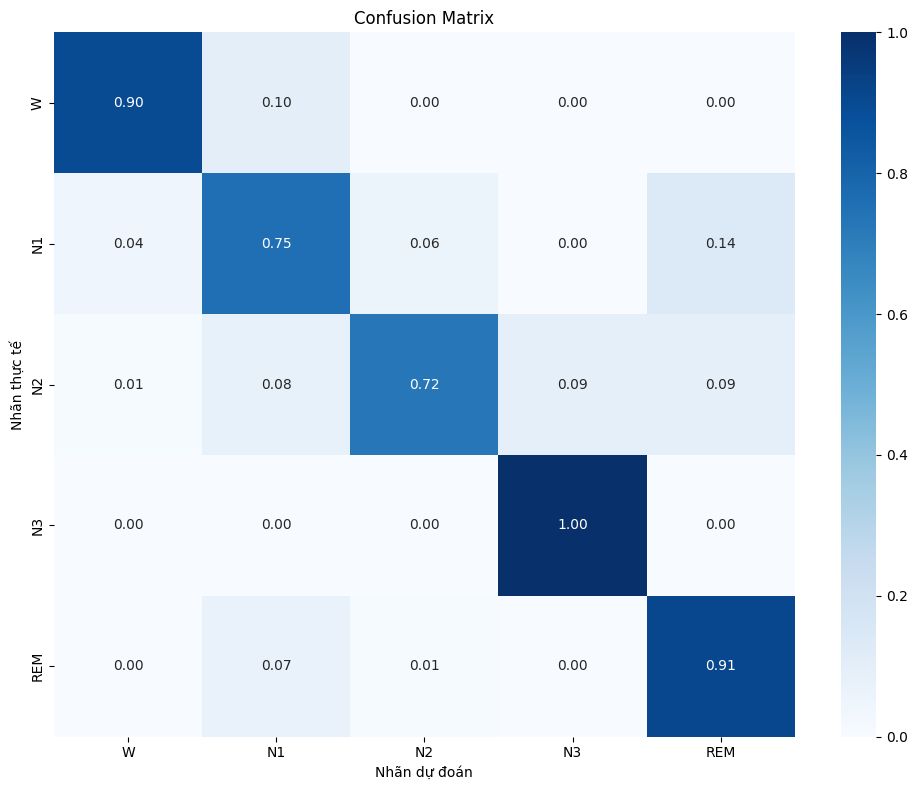

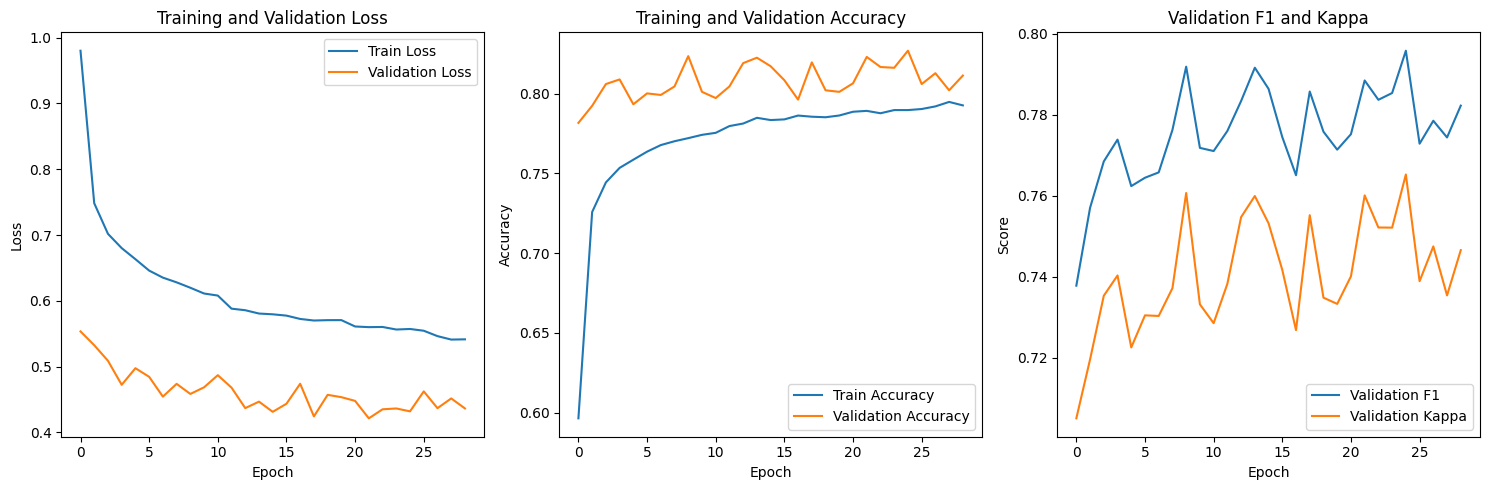


Fold 10/20
Test subject: SC4191
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 154/154 [00:00<00:00, 180.38it/s]


Epoch 1/200: Train Loss: 0.9907, Train Acc: 0.5770, Val Loss: 0.7383, Val Acc: 0.7394, Val F1: 0.6385, Val Kappa: 0.5977
✓ New best model saved! (Val Loss: 0.7383)


Validation: 100%|██████████| 154/154 [00:00<00:00, 172.88it/s]


Epoch 2/200: Train Loss: 0.7559, Train Acc: 0.7240, Val Loss: 0.6894, Val Acc: 0.7456, Val F1: 0.6462, Val Kappa: 0.6170
✓ New best model saved! (Val Loss: 0.6894)


Validation: 100%|██████████| 154/154 [00:00<00:00, 182.14it/s]


Epoch 3/200: Train Loss: 0.7085, Train Acc: 0.7454, Val Loss: 0.6585, Val Acc: 0.7557, Val F1: 0.6774, Val Kappa: 0.6433
✓ New best model saved! (Val Loss: 0.6585)


Validation: 100%|██████████| 154/154 [00:00<00:00, 177.03it/s]


Epoch 4/200: Train Loss: 0.6783, Train Acc: 0.7562, Val Loss: 0.6564, Val Acc: 0.7691, Val F1: 0.6857, Val Kappa: 0.6574
✓ New best model saved! (Val Loss: 0.6564)


Validation: 100%|██████████| 154/154 [00:00<00:00, 174.79it/s]


Epoch 5/200: Train Loss: 0.6624, Train Acc: 0.7601, Val Loss: 0.6632, Val Acc: 0.7896, Val F1: 0.6931, Val Kappa: 0.6887
! No improvement for 1 epochs


Validation: 100%|██████████| 154/154 [00:00<00:00, 180.04it/s]


Epoch 6/200: Train Loss: 0.6447, Train Acc: 0.7685, Val Loss: 0.5673, Val Acc: 0.7971, Val F1: 0.7217, Val Kappa: 0.6933
✓ New best model saved! (Val Loss: 0.5673)


Validation: 100%|██████████| 154/154 [00:00<00:00, 161.29it/s]


Epoch 7/200: Train Loss: 0.6310, Train Acc: 0.7702, Val Loss: 0.5890, Val Acc: 0.7857, Val F1: 0.7089, Val Kappa: 0.6795
! No improvement for 1 epochs


Validation: 100%|██████████| 154/154 [00:00<00:00, 182.23it/s]


Epoch 8/200: Train Loss: 0.6249, Train Acc: 0.7727, Val Loss: 0.5612, Val Acc: 0.7837, Val F1: 0.7123, Val Kappa: 0.6840
✓ New best model saved! (Val Loss: 0.5612)


Validation: 100%|██████████| 154/154 [00:00<00:00, 180.53it/s]


Epoch 9/200: Train Loss: 0.6186, Train Acc: 0.7756, Val Loss: 0.5511, Val Acc: 0.8059, Val F1: 0.7352, Val Kappa: 0.7059
✓ New best model saved! (Val Loss: 0.5511)


Validation: 100%|██████████| 154/154 [00:00<00:00, 170.66it/s]


Epoch 10/200: Train Loss: 0.6097, Train Acc: 0.7786, Val Loss: 0.5618, Val Acc: 0.7870, Val F1: 0.7087, Val Kappa: 0.6843
! No improvement for 1 epochs


Validation: 100%|██████████| 154/154 [00:00<00:00, 184.80it/s]


Epoch 11/200: Train Loss: 0.6008, Train Acc: 0.7794, Val Loss: 0.5250, Val Acc: 0.8049, Val F1: 0.7349, Val Kappa: 0.7119
✓ New best model saved! (Val Loss: 0.5250)


Validation: 100%|██████████| 154/154 [00:01<00:00, 152.54it/s]


Epoch 12/200: Train Loss: 0.5991, Train Acc: 0.7790, Val Loss: 0.5489, Val Acc: 0.8117, Val F1: 0.7344, Val Kappa: 0.7194
! No improvement for 1 epochs


Validation: 100%|██████████| 154/154 [00:00<00:00, 180.51it/s]


Epoch 13/200: Train Loss: 0.5893, Train Acc: 0.7817, Val Loss: 0.5255, Val Acc: 0.8156, Val F1: 0.7408, Val Kappa: 0.7239
! No improvement for 2 epochs


Validation: 100%|██████████| 154/154 [00:00<00:00, 181.97it/s]


Epoch 14/200: Train Loss: 0.5859, Train Acc: 0.7822, Val Loss: 0.5824, Val Acc: 0.8007, Val F1: 0.7213, Val Kappa: 0.7051
! No improvement for 3 epochs


Validation: 100%|██████████| 154/154 [00:00<00:00, 183.57it/s]


Epoch 15/200: Train Loss: 0.5797, Train Acc: 0.7838, Val Loss: 0.5208, Val Acc: 0.8020, Val F1: 0.7247, Val Kappa: 0.7069
✓ New best model saved! (Val Loss: 0.5208)


Validation: 100%|██████████| 154/154 [00:00<00:00, 181.56it/s]


Epoch 16/200: Train Loss: 0.5729, Train Acc: 0.7865, Val Loss: 0.4914, Val Acc: 0.8189, Val F1: 0.7520, Val Kappa: 0.7302
✓ New best model saved! (Val Loss: 0.4914)


Validation: 100%|██████████| 154/154 [00:00<00:00, 183.71it/s]


Epoch 17/200: Train Loss: 0.5713, Train Acc: 0.7864, Val Loss: 0.4866, Val Acc: 0.8101, Val F1: 0.7427, Val Kappa: 0.7186
✓ New best model saved! (Val Loss: 0.4866)


Validation: 100%|██████████| 154/154 [00:00<00:00, 163.42it/s]


Epoch 18/200: Train Loss: 0.5662, Train Acc: 0.7870, Val Loss: 0.4885, Val Acc: 0.8280, Val F1: 0.7694, Val Kappa: 0.7425
! No improvement for 1 epochs


Validation: 100%|██████████| 154/154 [00:00<00:00, 157.16it/s]


Epoch 19/200: Train Loss: 0.5658, Train Acc: 0.7856, Val Loss: 0.5373, Val Acc: 0.8039, Val F1: 0.7267, Val Kappa: 0.7112
! No improvement for 2 epochs


Validation: 100%|██████████| 154/154 [00:00<00:00, 179.28it/s]


Epoch 20/200: Train Loss: 0.5621, Train Acc: 0.7862, Val Loss: 0.5119, Val Acc: 0.8101, Val F1: 0.7496, Val Kappa: 0.7210
! No improvement for 3 epochs


Validation: 100%|██████████| 154/154 [00:00<00:00, 181.46it/s]


Epoch 21/200: Train Loss: 0.5596, Train Acc: 0.7861, Val Loss: 0.5476, Val Acc: 0.7818, Val F1: 0.7011, Val Kappa: 0.6816
! No improvement for 4 epochs


Validation: 100%|██████████| 154/154 [00:00<00:00, 180.20it/s]


Epoch 22/200: Train Loss: 0.5462, Train Acc: 0.7892, Val Loss: 0.5107, Val Acc: 0.8176, Val F1: 0.7515, Val Kappa: 0.7296
! No improvement for 5 epochs


Validation: 100%|██████████| 154/154 [00:00<00:00, 159.57it/s]


Epoch 23/200: Train Loss: 0.5406, Train Acc: 0.7920, Val Loss: 0.5439, Val Acc: 0.7928, Val F1: 0.7056, Val Kappa: 0.6936
! No improvement for 6 epochs


Validation: 100%|██████████| 154/154 [00:00<00:00, 167.08it/s]


Epoch 24/200: Train Loss: 0.5391, Train Acc: 0.7948, Val Loss: 0.5233, Val Acc: 0.8042, Val F1: 0.7239, Val Kappa: 0.7110
! No improvement for 7 epochs
Early stopping triggered after 24 epochs
✓ Loaded best model with Val Loss: 0.4866, Val Acc: 0.8101, Val F1: 0.7427, Val Kappa: 0.7186


Validation: 100%|██████████| 154/154 [00:00<00:00, 170.81it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.8614    0.7606    0.8079       376
          N1     0.3644    0.3644    0.3644       236
          N2     0.9844    0.8325    0.9021      1666
          N3     0.8151    0.9818    0.8907       220
         REM     0.6135    0.8881    0.7257       572

    accuracy                         0.8088      3070
   macro avg     0.7278    0.7655    0.7382      3070
weighted avg     0.8404    0.8088    0.8156      3070

Per-class F1 scores:
  W: 0.8079
  N1: 0.3644
  N2: 0.9021
  N3: 0.8907
  REM: 0.7257


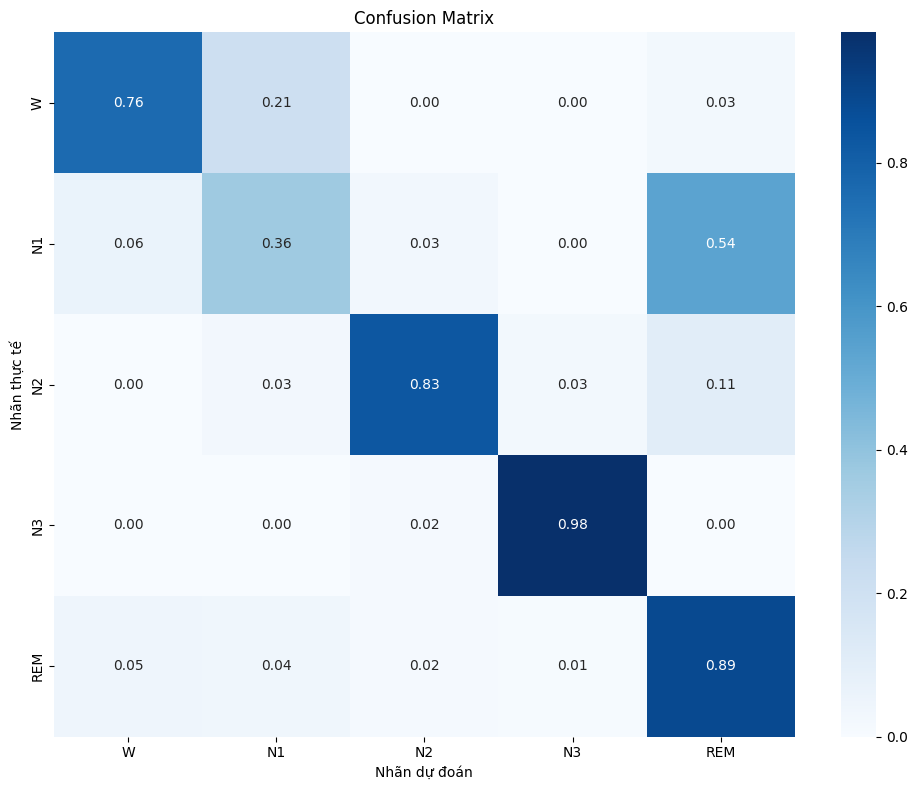

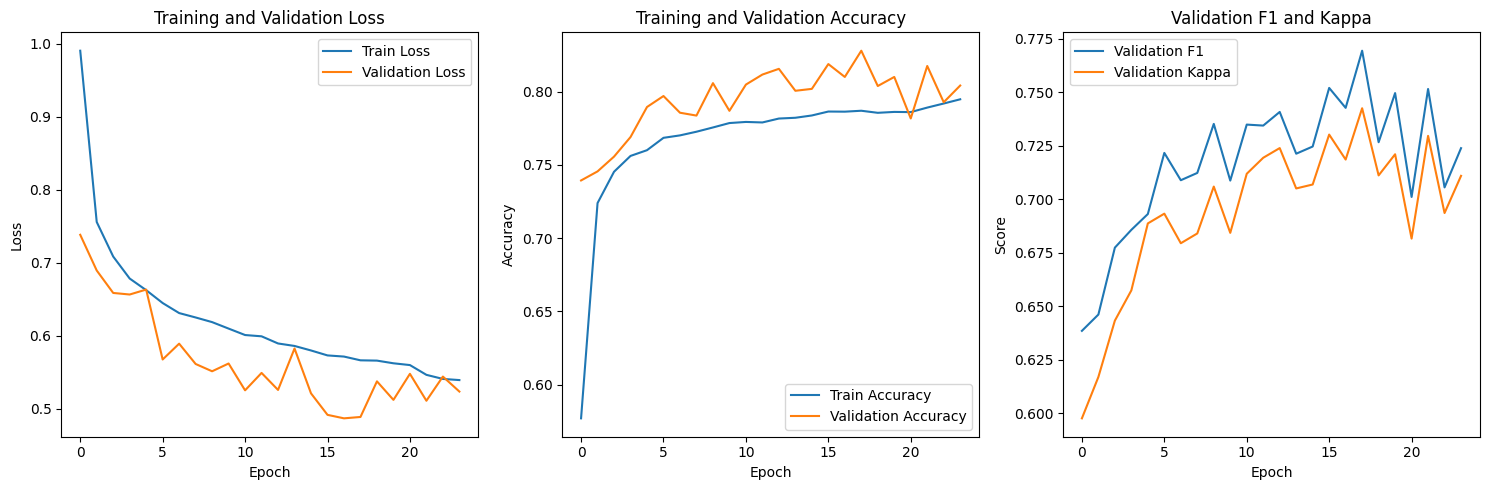


Fold 11/20
Test subject: SC4091
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 114/114 [00:00<00:00, 159.91it/s]


Epoch 1/200: Train Loss: 0.9967, Train Acc: 0.5833, Val Loss: 0.7184, Val Acc: 0.7527, Val F1: 0.6646, Val Kappa: 0.6521
✓ New best model saved! (Val Loss: 0.7184)


Validation: 100%|██████████| 114/114 [00:00<00:00, 161.82it/s]


Epoch 2/200: Train Loss: 0.7472, Train Acc: 0.7250, Val Loss: 0.7103, Val Acc: 0.7575, Val F1: 0.6778, Val Kappa: 0.6537
✓ New best model saved! (Val Loss: 0.7103)


Validation: 100%|██████████| 114/114 [00:00<00:00, 139.78it/s]


Epoch 3/200: Train Loss: 0.7000, Train Acc: 0.7445, Val Loss: 0.6473, Val Acc: 0.7800, Val F1: 0.7120, Val Kappa: 0.6861
✓ New best model saved! (Val Loss: 0.6473)


Validation: 100%|██████████| 114/114 [00:00<00:00, 160.47it/s]


Epoch 4/200: Train Loss: 0.6729, Train Acc: 0.7542, Val Loss: 0.6810, Val Acc: 0.7796, Val F1: 0.7082, Val Kappa: 0.6878
! No improvement for 1 epochs


Validation: 100%|██████████| 114/114 [00:00<00:00, 162.97it/s]


Epoch 5/200: Train Loss: 0.6577, Train Acc: 0.7632, Val Loss: 0.6774, Val Acc: 0.7641, Val F1: 0.6920, Val Kappa: 0.6701
! No improvement for 2 epochs


Validation: 100%|██████████| 114/114 [00:00<00:00, 158.47it/s]


Epoch 6/200: Train Loss: 0.6431, Train Acc: 0.7668, Val Loss: 0.6484, Val Acc: 0.7853, Val F1: 0.7163, Val Kappa: 0.6941
! No improvement for 3 epochs


Validation: 100%|██████████| 114/114 [00:00<00:00, 170.67it/s]


Epoch 7/200: Train Loss: 0.6317, Train Acc: 0.7694, Val Loss: 0.6509, Val Acc: 0.7942, Val F1: 0.7190, Val Kappa: 0.7032
! No improvement for 4 epochs


Validation: 100%|██████████| 114/114 [00:00<00:00, 141.52it/s]


Epoch 8/200: Train Loss: 0.6151, Train Acc: 0.7752, Val Loss: 0.6930, Val Acc: 0.7703, Val F1: 0.6971, Val Kappa: 0.6729
! No improvement for 5 epochs


Validation: 100%|██████████| 114/114 [00:00<00:00, 151.17it/s]


Epoch 9/200: Train Loss: 0.6124, Train Acc: 0.7747, Val Loss: 0.6095, Val Acc: 0.7840, Val F1: 0.7153, Val Kappa: 0.6948
✓ New best model saved! (Val Loss: 0.6095)


Validation: 100%|██████████| 114/114 [00:00<00:00, 164.20it/s]


Epoch 10/200: Train Loss: 0.6016, Train Acc: 0.7782, Val Loss: 0.6747, Val Acc: 0.7703, Val F1: 0.6966, Val Kappa: 0.6761
! No improvement for 1 epochs


Validation: 100%|██████████| 114/114 [00:00<00:00, 159.44it/s]


Epoch 11/200: Train Loss: 0.5989, Train Acc: 0.7805, Val Loss: 0.6147, Val Acc: 0.7959, Val F1: 0.7168, Val Kappa: 0.7062
! No improvement for 2 epochs


Validation: 100%|██████████| 114/114 [00:00<00:00, 163.31it/s]


Epoch 12/200: Train Loss: 0.5922, Train Acc: 0.7799, Val Loss: 0.6178, Val Acc: 0.7836, Val F1: 0.7075, Val Kappa: 0.6934
! No improvement for 3 epochs


Validation: 100%|██████████| 114/114 [00:00<00:00, 147.24it/s]


Epoch 13/200: Train Loss: 0.5915, Train Acc: 0.7789, Val Loss: 0.6499, Val Acc: 0.7814, Val F1: 0.7095, Val Kappa: 0.6891
! No improvement for 4 epochs


Validation: 100%|██████████| 114/114 [00:00<00:00, 165.69it/s]


Epoch 14/200: Train Loss: 0.5800, Train Acc: 0.7844, Val Loss: 0.6294, Val Acc: 0.7827, Val F1: 0.7068, Val Kappa: 0.6924
! No improvement for 5 epochs


Validation: 100%|██████████| 114/114 [00:00<00:00, 162.39it/s]


Epoch 15/200: Train Loss: 0.5791, Train Acc: 0.7847, Val Loss: 0.6105, Val Acc: 0.7928, Val F1: 0.7244, Val Kappa: 0.7047
! No improvement for 6 epochs


Validation: 100%|██████████| 114/114 [00:00<00:00, 165.52it/s]


Epoch 16/200: Train Loss: 0.5769, Train Acc: 0.7858, Val Loss: 0.6382, Val Acc: 0.7721, Val F1: 0.7012, Val Kappa: 0.6782
! No improvement for 7 epochs
Early stopping triggered after 16 epochs
✓ Loaded best model with Val Loss: 0.6095, Val Acc: 0.7840, Val F1: 0.7153, Val Kappa: 0.6948


Validation: 100%|██████████| 114/114 [00:00<00:00, 157.72it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9505    0.8967    0.9228       300
          N1     0.1643    0.8947    0.2776        38
          N2     0.8795    0.7549    0.8125      1122
          N3     0.7883    0.9088    0.8443       340
         REM     0.7375    0.6659    0.6999       464

    accuracy                         0.7809      2264
   macro avg     0.7040    0.8242    0.7114      2264
weighted avg     0.8341    0.7809    0.7998      2264

Per-class F1 scores:
  W: 0.9228
  N1: 0.2776
  N2: 0.8125
  N3: 0.8443
  REM: 0.6999


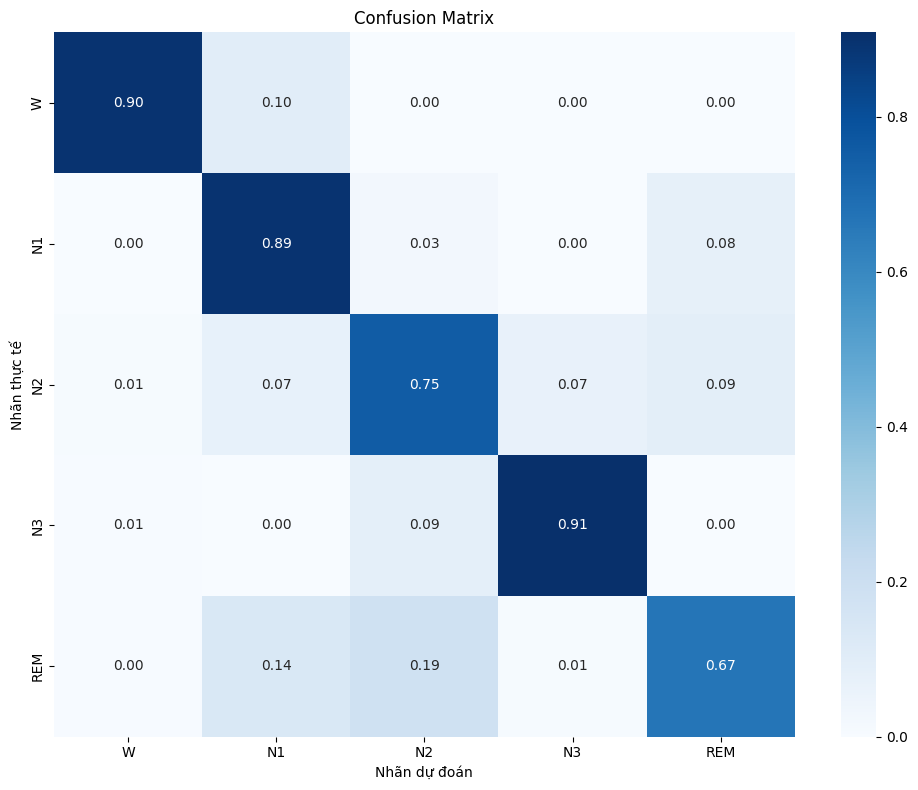

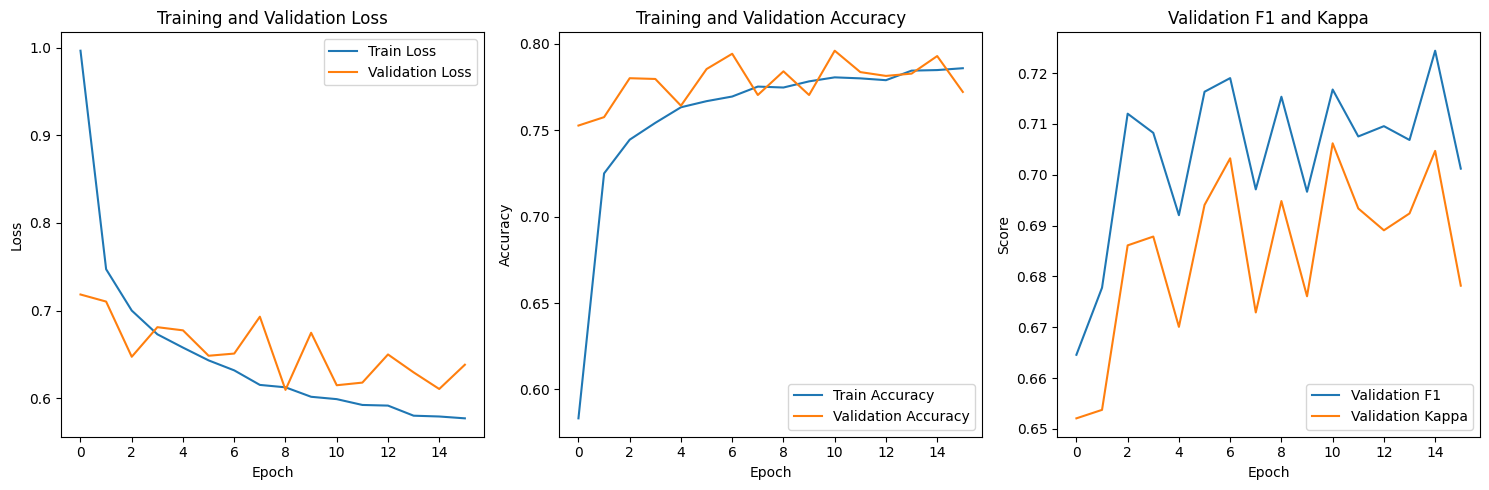


Fold 12/20
Test subject: SC4092
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 111/111 [00:00<00:00, 161.51it/s]


Epoch 1/200: Train Loss: 1.0154, Train Acc: 0.5683, Val Loss: 0.7780, Val Acc: 0.6814, Val F1: 0.6478, Val Kappa: 0.5665
✓ New best model saved! (Val Loss: 0.7780)


Validation: 100%|██████████| 111/111 [00:00<00:00, 149.84it/s]


Epoch 2/200: Train Loss: 0.7558, Train Acc: 0.7210, Val Loss: 0.7069, Val Acc: 0.7158, Val F1: 0.6572, Val Kappa: 0.6168
✓ New best model saved! (Val Loss: 0.7069)


Validation: 100%|██████████| 111/111 [00:00<00:00, 158.27it/s]


Epoch 3/200: Train Loss: 0.7019, Train Acc: 0.7439, Val Loss: 0.6849, Val Acc: 0.7285, Val F1: 0.6671, Val Kappa: 0.6307
✓ New best model saved! (Val Loss: 0.6849)


Validation: 100%|██████████| 111/111 [00:00<00:00, 156.33it/s]


Epoch 4/200: Train Loss: 0.6761, Train Acc: 0.7541, Val Loss: 0.6240, Val Acc: 0.7819, Val F1: 0.7032, Val Kappa: 0.6971
✓ New best model saved! (Val Loss: 0.6240)


Validation: 100%|██████████| 111/111 [00:00<00:00, 157.15it/s]


Epoch 5/200: Train Loss: 0.6585, Train Acc: 0.7617, Val Loss: 0.6401, Val Acc: 0.7670, Val F1: 0.6783, Val Kappa: 0.6802
! No improvement for 1 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 150.91it/s]


Epoch 6/200: Train Loss: 0.6446, Train Acc: 0.7627, Val Loss: 0.6244, Val Acc: 0.7597, Val F1: 0.6986, Val Kappa: 0.6719
! No improvement for 2 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 144.83it/s]


Epoch 7/200: Train Loss: 0.6327, Train Acc: 0.7694, Val Loss: 0.6644, Val Acc: 0.7371, Val F1: 0.6806, Val Kappa: 0.6451
! No improvement for 3 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 158.92it/s]


Epoch 8/200: Train Loss: 0.6182, Train Acc: 0.7719, Val Loss: 0.6787, Val Acc: 0.7317, Val F1: 0.6644, Val Kappa: 0.6383
! No improvement for 4 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 159.26it/s]


Epoch 9/200: Train Loss: 0.6082, Train Acc: 0.7755, Val Loss: 0.6425, Val Acc: 0.7701, Val F1: 0.7062, Val Kappa: 0.6863
! No improvement for 5 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 168.47it/s]


Epoch 10/200: Train Loss: 0.6016, Train Acc: 0.7771, Val Loss: 0.5460, Val Acc: 0.8145, Val F1: 0.7389, Val Kappa: 0.7399
✓ New best model saved! (Val Loss: 0.5460)


Validation: 100%|██████████| 111/111 [00:00<00:00, 161.51it/s]


Epoch 11/200: Train Loss: 0.5970, Train Acc: 0.7796, Val Loss: 0.5705, Val Acc: 0.7887, Val F1: 0.7310, Val Kappa: 0.7090
! No improvement for 1 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 162.60it/s]


Epoch 12/200: Train Loss: 0.5922, Train Acc: 0.7812, Val Loss: 0.6145, Val Acc: 0.7697, Val F1: 0.7150, Val Kappa: 0.6864
! No improvement for 2 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 146.32it/s]


Epoch 13/200: Train Loss: 0.5889, Train Acc: 0.7820, Val Loss: 0.5706, Val Acc: 0.7778, Val F1: 0.7210, Val Kappa: 0.6956
! No improvement for 3 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 159.15it/s]


Epoch 14/200: Train Loss: 0.5863, Train Acc: 0.7824, Val Loss: 0.6440, Val Acc: 0.7529, Val F1: 0.6948, Val Kappa: 0.6637
! No improvement for 4 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 154.54it/s]


Epoch 15/200: Train Loss: 0.5803, Train Acc: 0.7834, Val Loss: 0.5676, Val Acc: 0.7837, Val F1: 0.7282, Val Kappa: 0.7032
! No improvement for 5 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 158.71it/s]


Epoch 16/200: Train Loss: 0.5724, Train Acc: 0.7863, Val Loss: 0.6233, Val Acc: 0.7557, Val F1: 0.7107, Val Kappa: 0.6696
! No improvement for 6 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 163.89it/s]


Epoch 17/200: Train Loss: 0.5710, Train Acc: 0.7866, Val Loss: 0.5649, Val Acc: 0.7878, Val F1: 0.7275, Val Kappa: 0.7080
! No improvement for 7 epochs
Early stopping triggered after 17 epochs
✓ Loaded best model with Val Loss: 0.5460, Val Acc: 0.8145, Val F1: 0.7389, Val Kappa: 0.7399


Validation: 100%|██████████| 111/111 [00:00<00:00, 163.03it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.8530    0.8500    0.8515       280
          N1     0.3169    0.3580    0.3362       162
          N2     0.9403    0.8457    0.8905      1024
          N3     0.7289    0.9673    0.8313       214
         REM     0.8048    0.8245    0.8145       530

    accuracy                         0.8172      2210
   macro avg     0.7288    0.7691    0.7448      2210
weighted avg     0.8306    0.8172    0.8210      2210

Per-class F1 scores:
  W: 0.8515
  N1: 0.3362
  N2: 0.8905
  N3: 0.8313
  REM: 0.8145


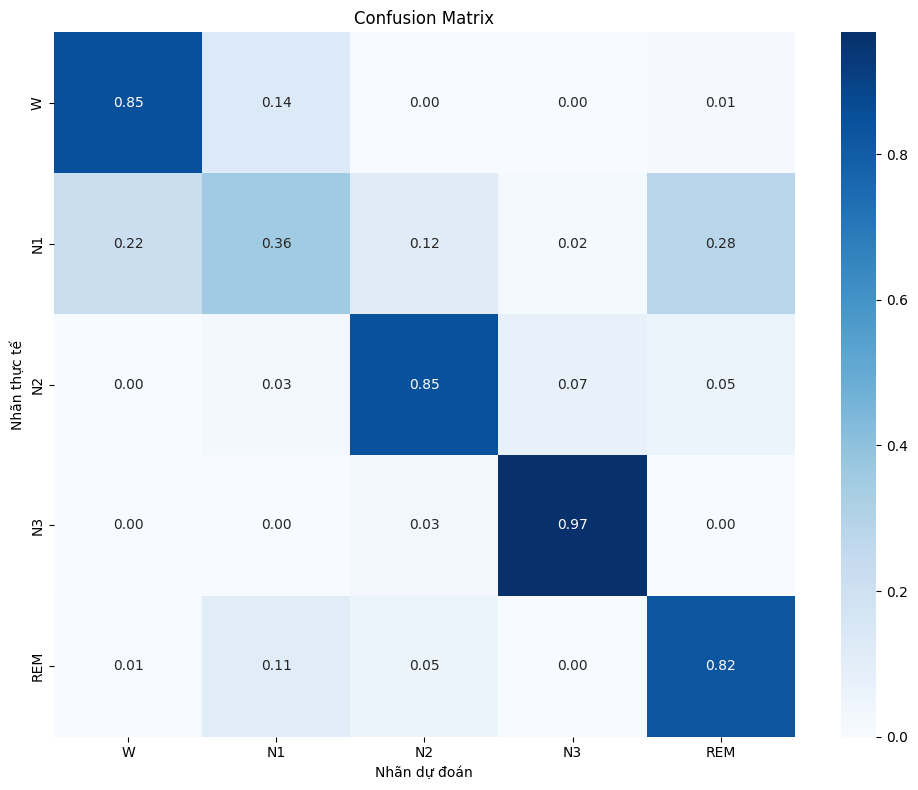

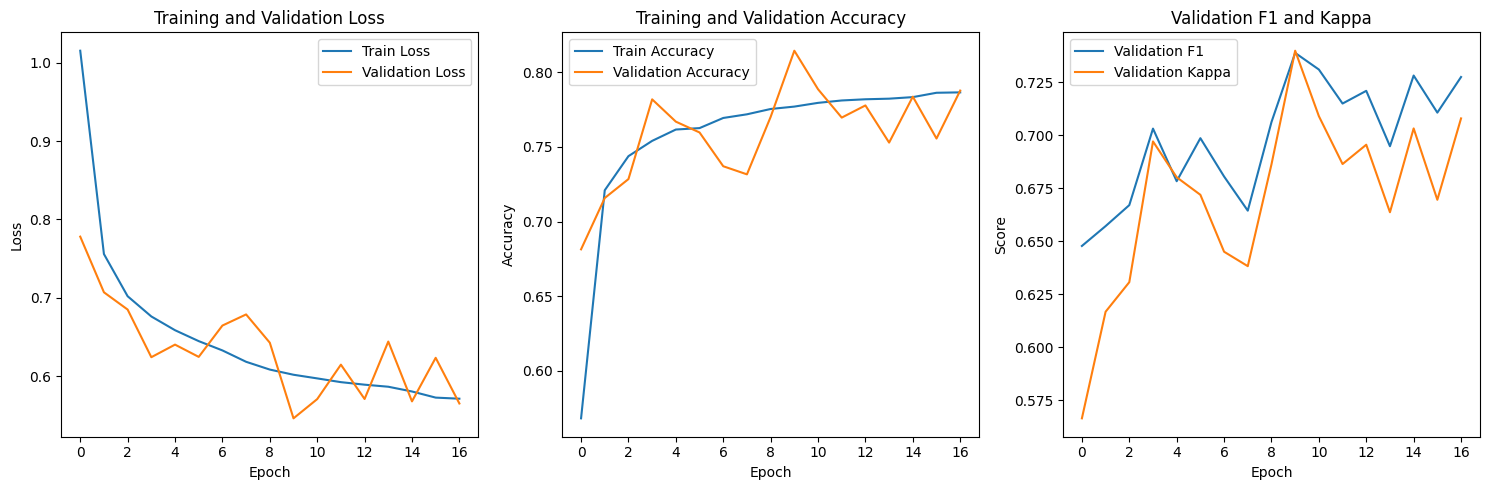


Fold 13/20
Test subject: SC4001
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 85/85 [00:00<00:00, 147.99it/s]


Epoch 1/200: Train Loss: 0.9694, Train Acc: 0.6020, Val Loss: 0.6328, Val Acc: 0.7717, Val F1: 0.6978, Val Kappa: 0.7062
✓ New best model saved! (Val Loss: 0.6328)


Validation: 100%|██████████| 85/85 [00:00<00:00, 147.38it/s]


Epoch 2/200: Train Loss: 0.7423, Train Acc: 0.7294, Val Loss: 0.5523, Val Acc: 0.7503, Val F1: 0.6933, Val Kappa: 0.6815
✓ New best model saved! (Val Loss: 0.5523)


Validation: 100%|██████████| 85/85 [00:00<00:00, 136.79it/s]


Epoch 3/200: Train Loss: 0.6976, Train Acc: 0.7456, Val Loss: 0.5022, Val Acc: 0.8127, Val F1: 0.7502, Val Kappa: 0.7595
✓ New best model saved! (Val Loss: 0.5022)


Validation: 100%|██████████| 85/85 [00:00<00:00, 150.68it/s]


Epoch 4/200: Train Loss: 0.6723, Train Acc: 0.7572, Val Loss: 0.5237, Val Acc: 0.7961, Val F1: 0.7153, Val Kappa: 0.7370
! No improvement for 1 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 140.57it/s]


Epoch 5/200: Train Loss: 0.6561, Train Acc: 0.7641, Val Loss: 0.4594, Val Acc: 0.8377, Val F1: 0.7669, Val Kappa: 0.7898
✓ New best model saved! (Val Loss: 0.4594)


Validation: 100%|██████████| 85/85 [00:00<00:00, 133.38it/s]


Epoch 6/200: Train Loss: 0.6417, Train Acc: 0.7673, Val Loss: 0.4655, Val Acc: 0.8323, Val F1: 0.7817, Val Kappa: 0.7842
! No improvement for 1 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 146.20it/s]


Epoch 7/200: Train Loss: 0.6292, Train Acc: 0.7713, Val Loss: 0.4940, Val Acc: 0.8175, Val F1: 0.7541, Val Kappa: 0.7653
! No improvement for 2 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 154.24it/s]


Epoch 8/200: Train Loss: 0.6242, Train Acc: 0.7719, Val Loss: 0.4578, Val Acc: 0.8258, Val F1: 0.7737, Val Kappa: 0.7756
✓ New best model saved! (Val Loss: 0.4578)


Validation: 100%|██████████| 85/85 [00:00<00:00, 144.65it/s]


Epoch 9/200: Train Loss: 0.6145, Train Acc: 0.7768, Val Loss: 0.4569, Val Acc: 0.8413, Val F1: 0.7752, Val Kappa: 0.7950
✓ New best model saved! (Val Loss: 0.4569)


Validation: 100%|██████████| 85/85 [00:00<00:00, 144.48it/s]


Epoch 10/200: Train Loss: 0.6064, Train Acc: 0.7781, Val Loss: 0.5312, Val Acc: 0.8270, Val F1: 0.7513, Val Kappa: 0.7756
! No improvement for 1 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 146.64it/s]


Epoch 11/200: Train Loss: 0.6005, Train Acc: 0.7797, Val Loss: 0.4686, Val Acc: 0.8377, Val F1: 0.7751, Val Kappa: 0.7902
! No improvement for 2 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 141.29it/s]


Epoch 12/200: Train Loss: 0.5945, Train Acc: 0.7806, Val Loss: 0.5200, Val Acc: 0.8169, Val F1: 0.7541, Val Kappa: 0.7644
! No improvement for 3 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 135.92it/s]


Epoch 13/200: Train Loss: 0.5881, Train Acc: 0.7784, Val Loss: 0.4794, Val Acc: 0.8448, Val F1: 0.7823, Val Kappa: 0.7993
! No improvement for 4 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 148.62it/s]


Epoch 14/200: Train Loss: 0.5724, Train Acc: 0.7861, Val Loss: 0.4525, Val Acc: 0.8347, Val F1: 0.7810, Val Kappa: 0.7870
✓ New best model saved! (Val Loss: 0.4525)


Validation: 100%|██████████| 85/85 [00:00<00:00, 145.12it/s]


Epoch 15/200: Train Loss: 0.5678, Train Acc: 0.7871, Val Loss: 0.4653, Val Acc: 0.8407, Val F1: 0.7867, Val Kappa: 0.7943
! No improvement for 1 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 146.60it/s]


Epoch 16/200: Train Loss: 0.5684, Train Acc: 0.7873, Val Loss: 0.4929, Val Acc: 0.8353, Val F1: 0.7617, Val Kappa: 0.7868
! No improvement for 2 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 139.64it/s]


Epoch 17/200: Train Loss: 0.5647, Train Acc: 0.7870, Val Loss: 0.4561, Val Acc: 0.8329, Val F1: 0.7715, Val Kappa: 0.7847
! No improvement for 3 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 137.99it/s]


Epoch 18/200: Train Loss: 0.5609, Train Acc: 0.7889, Val Loss: 0.4533, Val Acc: 0.8407, Val F1: 0.7968, Val Kappa: 0.7952
! No improvement for 4 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 147.53it/s]


Epoch 19/200: Train Loss: 0.5519, Train Acc: 0.7912, Val Loss: 0.4399, Val Acc: 0.8359, Val F1: 0.7810, Val Kappa: 0.7888
✓ New best model saved! (Val Loss: 0.4399)


Validation: 100%|██████████| 85/85 [00:00<00:00, 146.36it/s]


Epoch 20/200: Train Loss: 0.5517, Train Acc: 0.7917, Val Loss: 0.4340, Val Acc: 0.8329, Val F1: 0.7770, Val Kappa: 0.7850
✓ New best model saved! (Val Loss: 0.4340)


Validation: 100%|██████████| 85/85 [00:00<00:00, 133.77it/s]


Epoch 21/200: Train Loss: 0.5466, Train Acc: 0.7916, Val Loss: 0.4371, Val Acc: 0.8448, Val F1: 0.7913, Val Kappa: 0.8000
! No improvement for 1 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 142.61it/s]


Epoch 22/200: Train Loss: 0.5466, Train Acc: 0.7919, Val Loss: 0.4695, Val Acc: 0.8347, Val F1: 0.7668, Val Kappa: 0.7864
! No improvement for 2 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 148.62it/s]


Epoch 23/200: Train Loss: 0.5467, Train Acc: 0.7931, Val Loss: 0.4456, Val Acc: 0.8490, Val F1: 0.7862, Val Kappa: 0.8047
! No improvement for 3 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 135.52it/s]


Epoch 24/200: Train Loss: 0.5445, Train Acc: 0.7939, Val Loss: 0.4521, Val Acc: 0.8442, Val F1: 0.7858, Val Kappa: 0.7985
! No improvement for 4 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 132.79it/s]


Epoch 25/200: Train Loss: 0.5405, Train Acc: 0.7960, Val Loss: 0.4874, Val Acc: 0.8353, Val F1: 0.7713, Val Kappa: 0.7871
! No improvement for 5 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 147.52it/s]


Epoch 26/200: Train Loss: 0.5418, Train Acc: 0.7944, Val Loss: 0.4550, Val Acc: 0.8252, Val F1: 0.7691, Val Kappa: 0.7749
! No improvement for 6 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 142.77it/s]


Epoch 27/200: Train Loss: 0.5390, Train Acc: 0.7946, Val Loss: 0.4275, Val Acc: 0.8442, Val F1: 0.7870, Val Kappa: 0.7988
✓ New best model saved! (Val Loss: 0.4275)


Validation: 100%|██████████| 85/85 [00:00<00:00, 154.29it/s]


Epoch 28/200: Train Loss: 0.5365, Train Acc: 0.7959, Val Loss: 0.4350, Val Acc: 0.8502, Val F1: 0.7996, Val Kappa: 0.8065
! No improvement for 1 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 145.72it/s]


Epoch 29/200: Train Loss: 0.5372, Train Acc: 0.7959, Val Loss: 0.3999, Val Acc: 0.8543, Val F1: 0.8111, Val Kappa: 0.8123
✓ New best model saved! (Val Loss: 0.3999)


Validation: 100%|██████████| 85/85 [00:00<00:00, 145.14it/s]


Epoch 30/200: Train Loss: 0.5365, Train Acc: 0.7941, Val Loss: 0.4095, Val Acc: 0.8413, Val F1: 0.7922, Val Kappa: 0.7958
! No improvement for 1 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 134.34it/s]


Epoch 31/200: Train Loss: 0.5349, Train Acc: 0.7958, Val Loss: 0.4301, Val Acc: 0.8436, Val F1: 0.7853, Val Kappa: 0.7978
! No improvement for 2 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 135.59it/s]


Epoch 32/200: Train Loss: 0.5337, Train Acc: 0.7973, Val Loss: 0.4244, Val Acc: 0.8442, Val F1: 0.7909, Val Kappa: 0.7993
! No improvement for 3 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 149.60it/s]


Epoch 33/200: Train Loss: 0.5326, Train Acc: 0.7972, Val Loss: 0.4644, Val Acc: 0.8389, Val F1: 0.7833, Val Kappa: 0.7921
! No improvement for 4 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 141.72it/s]


Epoch 34/200: Train Loss: 0.5308, Train Acc: 0.7980, Val Loss: 0.4560, Val Acc: 0.8407, Val F1: 0.7863, Val Kappa: 0.7942
! No improvement for 5 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 140.28it/s]


Epoch 35/200: Train Loss: 0.5301, Train Acc: 0.7989, Val Loss: 0.4099, Val Acc: 0.8448, Val F1: 0.7939, Val Kappa: 0.7997
! No improvement for 6 epochs


Validation: 100%|██████████| 85/85 [00:00<00:00, 149.40it/s]


Epoch 36/200: Train Loss: 0.5289, Train Acc: 0.7971, Val Loss: 0.4637, Val Acc: 0.8377, Val F1: 0.7826, Val Kappa: 0.7905
! No improvement for 7 epochs
Early stopping triggered after 36 epochs
✓ Loaded best model with Val Loss: 0.3999, Val Acc: 0.8543, Val F1: 0.8111, Val Kappa: 0.8123


Validation: 100%|██████████| 85/85 [00:00<00:00, 146.66it/s]



Classification Report:
              precision    recall  f1-score   support

           W     1.0000    0.8271    0.9054       376
          N1     0.4118    0.6034    0.4895       116
          N2     0.9178    0.8040    0.8571       500
          N3     0.8834    0.9295    0.9059       440
         REM     0.7667    0.9200    0.8364       250

    accuracy                         0.8454      1682
   macro avg     0.7959    0.8168    0.7989      1682
weighted avg     0.8698    0.8454    0.8522      1682

Per-class F1 scores:
  W: 0.9054
  N1: 0.4895
  N2: 0.8571
  N3: 0.9059
  REM: 0.8364


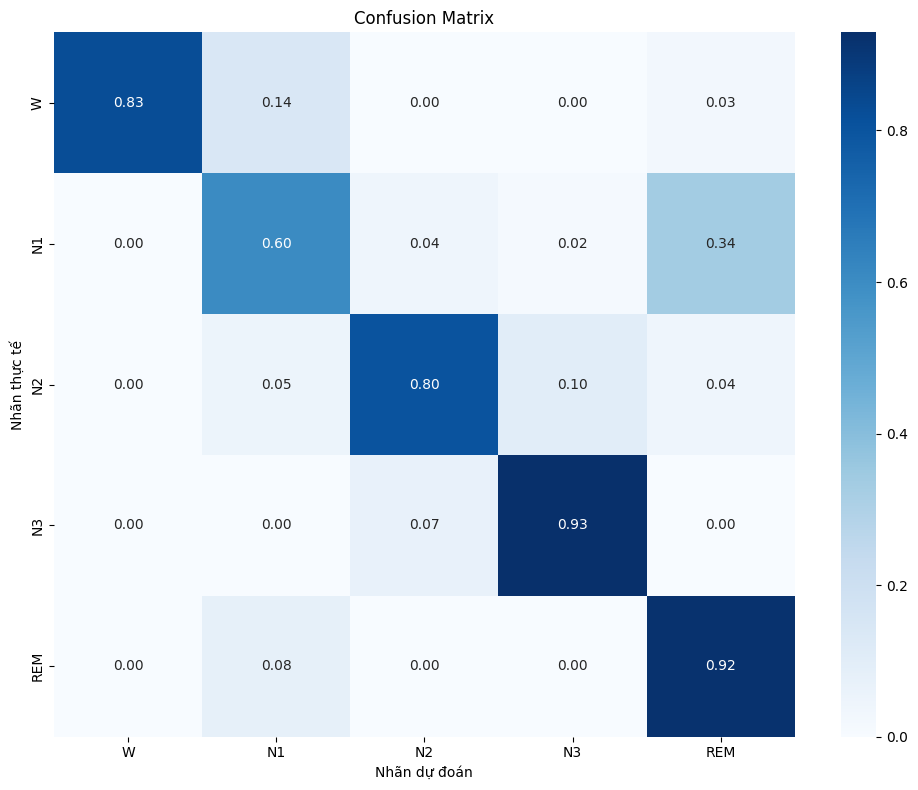

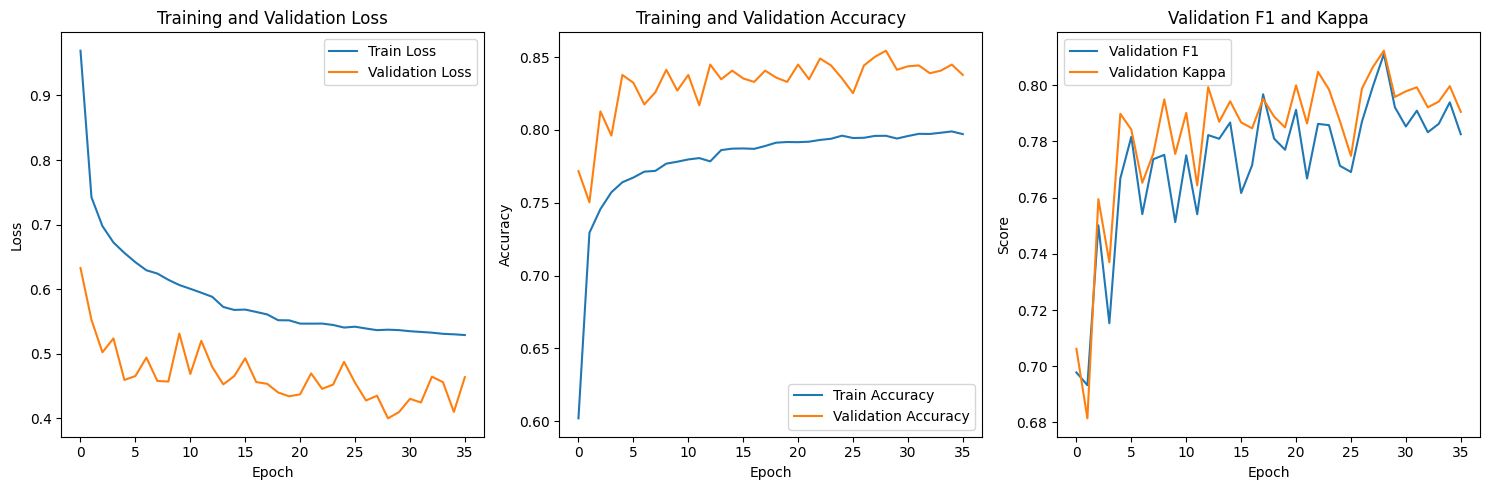


Fold 14/20
Test subject: SC4151
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 96/96 [00:00<00:00, 151.81it/s]


Epoch 1/200: Train Loss: 1.0198, Train Acc: 0.5745, Val Loss: 0.5952, Val Acc: 0.7810, Val F1: 0.7083, Val Kappa: 0.7132
✓ New best model saved! (Val Loss: 0.5952)


Validation: 100%|██████████| 96/96 [00:00<00:00, 136.86it/s]


Epoch 2/200: Train Loss: 0.7608, Train Acc: 0.7201, Val Loss: 0.4863, Val Acc: 0.8225, Val F1: 0.7396, Val Kappa: 0.7664
✓ New best model saved! (Val Loss: 0.4863)


Validation: 100%|██████████| 96/96 [00:00<00:00, 153.35it/s]


Epoch 3/200: Train Loss: 0.7067, Train Acc: 0.7442, Val Loss: 0.4626, Val Acc: 0.8267, Val F1: 0.7259, Val Kappa: 0.7699
✓ New best model saved! (Val Loss: 0.4626)


Validation: 100%|██████████| 96/96 [00:00<00:00, 150.74it/s]


Epoch 4/200: Train Loss: 0.6799, Train Acc: 0.7530, Val Loss: 0.4312, Val Acc: 0.8340, Val F1: 0.7695, Val Kappa: 0.7815
✓ New best model saved! (Val Loss: 0.4312)


Validation: 100%|██████████| 96/96 [00:00<00:00, 143.24it/s]


Epoch 5/200: Train Loss: 0.6665, Train Acc: 0.7585, Val Loss: 0.4263, Val Acc: 0.8430, Val F1: 0.7712, Val Kappa: 0.7929
✓ New best model saved! (Val Loss: 0.4263)


Validation: 100%|██████████| 96/96 [00:00<00:00, 150.11it/s]


Epoch 6/200: Train Loss: 0.6519, Train Acc: 0.7621, Val Loss: 0.4287, Val Acc: 0.8372, Val F1: 0.7649, Val Kappa: 0.7852
! No improvement for 1 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 153.99it/s]


Epoch 7/200: Train Loss: 0.6356, Train Acc: 0.7674, Val Loss: 0.4148, Val Acc: 0.8461, Val F1: 0.7829, Val Kappa: 0.7973
✓ New best model saved! (Val Loss: 0.4148)


Validation: 100%|██████████| 96/96 [00:00<00:00, 150.35it/s]


Epoch 8/200: Train Loss: 0.6282, Train Acc: 0.7724, Val Loss: 0.3988, Val Acc: 0.8487, Val F1: 0.7817, Val Kappa: 0.8005
✓ New best model saved! (Val Loss: 0.3988)


Validation: 100%|██████████| 96/96 [00:00<00:00, 137.42it/s]


Epoch 9/200: Train Loss: 0.6195, Train Acc: 0.7736, Val Loss: 0.4298, Val Acc: 0.8277, Val F1: 0.7684, Val Kappa: 0.7736
! No improvement for 1 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 139.24it/s]


Epoch 10/200: Train Loss: 0.6117, Train Acc: 0.7742, Val Loss: 0.3940, Val Acc: 0.8487, Val F1: 0.7710, Val Kappa: 0.7998
✓ New best model saved! (Val Loss: 0.3940)


Validation: 100%|██████████| 96/96 [00:00<00:00, 152.31it/s]


Epoch 11/200: Train Loss: 0.6060, Train Acc: 0.7760, Val Loss: 0.4016, Val Acc: 0.8514, Val F1: 0.7843, Val Kappa: 0.8035
! No improvement for 1 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 153.20it/s]


Epoch 12/200: Train Loss: 0.5950, Train Acc: 0.7781, Val Loss: 0.4074, Val Acc: 0.8424, Val F1: 0.7805, Val Kappa: 0.7928
! No improvement for 2 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 152.52it/s]


Epoch 13/200: Train Loss: 0.5919, Train Acc: 0.7790, Val Loss: 0.4096, Val Acc: 0.8498, Val F1: 0.7896, Val Kappa: 0.8001
! No improvement for 3 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 156.00it/s]


Epoch 14/200: Train Loss: 0.5853, Train Acc: 0.7807, Val Loss: 0.3969, Val Acc: 0.8414, Val F1: 0.7780, Val Kappa: 0.7919
! No improvement for 4 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 150.74it/s]


Epoch 15/200: Train Loss: 0.5733, Train Acc: 0.7840, Val Loss: 0.3908, Val Acc: 0.8403, Val F1: 0.7789, Val Kappa: 0.7904
✓ New best model saved! (Val Loss: 0.3908)


Validation: 100%|██████████| 96/96 [00:00<00:00, 150.44it/s]


Epoch 16/200: Train Loss: 0.5637, Train Acc: 0.7862, Val Loss: 0.4225, Val Acc: 0.8319, Val F1: 0.7582, Val Kappa: 0.7785
! No improvement for 1 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 137.36it/s]


Epoch 17/200: Train Loss: 0.5655, Train Acc: 0.7873, Val Loss: 0.3966, Val Acc: 0.8393, Val F1: 0.7726, Val Kappa: 0.7890
! No improvement for 2 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 136.83it/s]


Epoch 18/200: Train Loss: 0.5602, Train Acc: 0.7876, Val Loss: 0.3846, Val Acc: 0.8582, Val F1: 0.7907, Val Kappa: 0.8126
✓ New best model saved! (Val Loss: 0.3846)


Validation: 100%|██████████| 96/96 [00:00<00:00, 152.93it/s]


Epoch 19/200: Train Loss: 0.5585, Train Acc: 0.7849, Val Loss: 0.3869, Val Acc: 0.8498, Val F1: 0.7909, Val Kappa: 0.8022
! No improvement for 1 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 154.53it/s]


Epoch 20/200: Train Loss: 0.5575, Train Acc: 0.7880, Val Loss: 0.3852, Val Acc: 0.8424, Val F1: 0.7777, Val Kappa: 0.7931
! No improvement for 2 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 145.12it/s]


Epoch 21/200: Train Loss: 0.5583, Train Acc: 0.7879, Val Loss: 0.3910, Val Acc: 0.8440, Val F1: 0.7761, Val Kappa: 0.7951
! No improvement for 3 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 147.64it/s]


Epoch 22/200: Train Loss: 0.5501, Train Acc: 0.7908, Val Loss: 0.3969, Val Acc: 0.8440, Val F1: 0.7670, Val Kappa: 0.7943
! No improvement for 4 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 147.48it/s]


Epoch 23/200: Train Loss: 0.5461, Train Acc: 0.7907, Val Loss: 0.3862, Val Acc: 0.8493, Val F1: 0.7771, Val Kappa: 0.8014
! No improvement for 5 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 134.99it/s]


Epoch 24/200: Train Loss: 0.5410, Train Acc: 0.7919, Val Loss: 0.3836, Val Acc: 0.8577, Val F1: 0.7804, Val Kappa: 0.8119
✓ New best model saved! (Val Loss: 0.3836)


Validation: 100%|██████████| 96/96 [00:00<00:00, 134.70it/s]


Epoch 25/200: Train Loss: 0.5407, Train Acc: 0.7918, Val Loss: 0.3830, Val Acc: 0.8493, Val F1: 0.7862, Val Kappa: 0.8015
✓ New best model saved! (Val Loss: 0.3830)


Validation: 100%|██████████| 96/96 [00:00<00:00, 146.39it/s]


Epoch 26/200: Train Loss: 0.5400, Train Acc: 0.7938, Val Loss: 0.3903, Val Acc: 0.8613, Val F1: 0.7677, Val Kappa: 0.8157
! No improvement for 1 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 150.63it/s]


Epoch 27/200: Train Loss: 0.5386, Train Acc: 0.7947, Val Loss: 0.3806, Val Acc: 0.8556, Val F1: 0.7801, Val Kappa: 0.8090
✓ New best model saved! (Val Loss: 0.3806)


Validation: 100%|██████████| 96/96 [00:00<00:00, 147.76it/s]


Epoch 28/200: Train Loss: 0.5377, Train Acc: 0.7920, Val Loss: 0.3875, Val Acc: 0.8561, Val F1: 0.7744, Val Kappa: 0.8102
! No improvement for 1 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 151.62it/s]


Epoch 29/200: Train Loss: 0.5377, Train Acc: 0.7935, Val Loss: 0.3831, Val Acc: 0.8524, Val F1: 0.7811, Val Kappa: 0.8053
! No improvement for 2 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 138.48it/s]


Epoch 30/200: Train Loss: 0.5361, Train Acc: 0.7920, Val Loss: 0.3910, Val Acc: 0.8414, Val F1: 0.7696, Val Kappa: 0.7913
! No improvement for 3 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 146.49it/s]


Epoch 31/200: Train Loss: 0.5345, Train Acc: 0.7944, Val Loss: 0.3934, Val Acc: 0.8493, Val F1: 0.7786, Val Kappa: 0.8017
! No improvement for 4 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 146.19it/s]


Epoch 32/200: Train Loss: 0.5306, Train Acc: 0.7954, Val Loss: 0.3939, Val Acc: 0.8398, Val F1: 0.7672, Val Kappa: 0.7897
! No improvement for 5 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 139.80it/s]


Epoch 33/200: Train Loss: 0.5300, Train Acc: 0.7947, Val Loss: 0.3501, Val Acc: 0.8592, Val F1: 0.7926, Val Kappa: 0.8147
✓ New best model saved! (Val Loss: 0.3501)


Validation: 100%|██████████| 96/96 [00:00<00:00, 140.12it/s]


Epoch 34/200: Train Loss: 0.5282, Train Acc: 0.7969, Val Loss: 0.3736, Val Acc: 0.8697, Val F1: 0.8005, Val Kappa: 0.8281
! No improvement for 1 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 131.29it/s]


Epoch 35/200: Train Loss: 0.5278, Train Acc: 0.7965, Val Loss: 0.3721, Val Acc: 0.8545, Val F1: 0.7882, Val Kappa: 0.8083
! No improvement for 2 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 151.77it/s]


Epoch 36/200: Train Loss: 0.5256, Train Acc: 0.7955, Val Loss: 0.3749, Val Acc: 0.8477, Val F1: 0.7845, Val Kappa: 0.7996
! No improvement for 3 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 151.60it/s]


Epoch 37/200: Train Loss: 0.5211, Train Acc: 0.7979, Val Loss: 0.3849, Val Acc: 0.8561, Val F1: 0.7828, Val Kappa: 0.8095
! No improvement for 4 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 138.78it/s]


Epoch 38/200: Train Loss: 0.5223, Train Acc: 0.7991, Val Loss: 0.3822, Val Acc: 0.8472, Val F1: 0.7813, Val Kappa: 0.7992
! No improvement for 5 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 153.67it/s]


Epoch 39/200: Train Loss: 0.5231, Train Acc: 0.7977, Val Loss: 0.3759, Val Acc: 0.8592, Val F1: 0.7931, Val Kappa: 0.8141
! No improvement for 6 epochs


Validation: 100%|██████████| 96/96 [00:00<00:00, 145.33it/s]


Epoch 40/200: Train Loss: 0.5198, Train Acc: 0.7984, Val Loss: 0.3776, Val Acc: 0.8592, Val F1: 0.7793, Val Kappa: 0.8137
! No improvement for 7 epochs
Early stopping triggered after 40 epochs
✓ Loaded best model with Val Loss: 0.3501, Val Acc: 0.8592, Val F1: 0.7926, Val Kappa: 0.8147


Validation: 100%|██████████| 96/96 [00:00<00:00, 142.46it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9764    0.8401    0.9031       344
          N1     0.2968    0.5610    0.3882        82
          N2     0.9510    0.8220    0.8818       708
          N3     0.8301    0.9802    0.8990       354
         REM     0.8558    0.8702    0.8629       416

    accuracy                         0.8540      1904
   macro avg     0.7820    0.8147    0.7870      1904
weighted avg     0.8841    0.8540    0.8635      1904

Per-class F1 scores:
  W: 0.9031
  N1: 0.3882
  N2: 0.8818
  N3: 0.8990
  REM: 0.8629


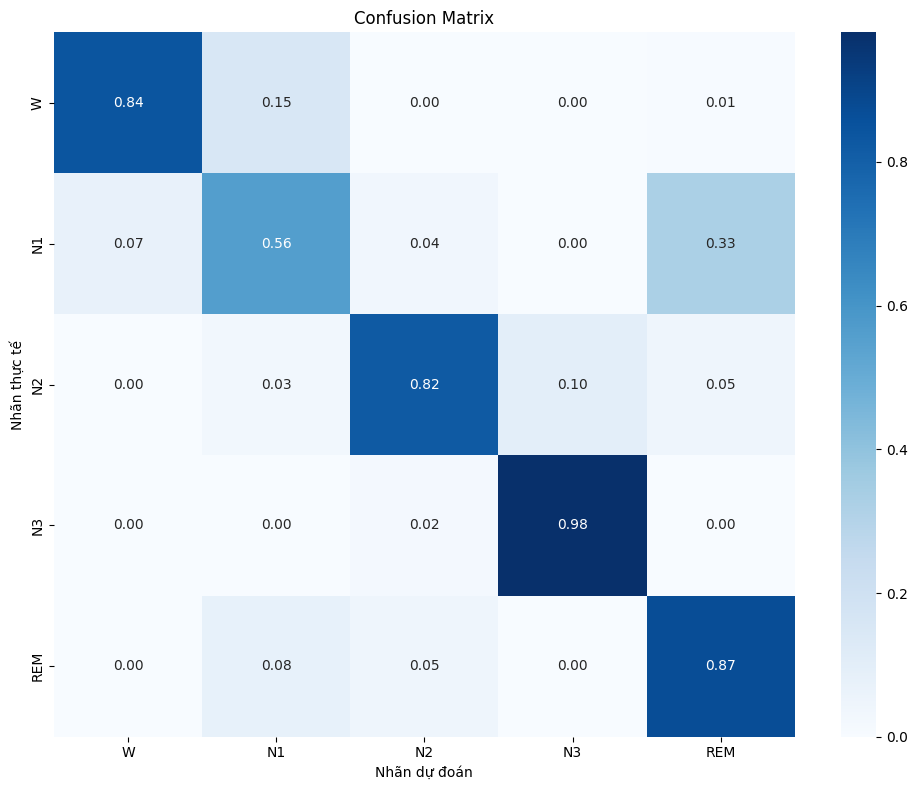

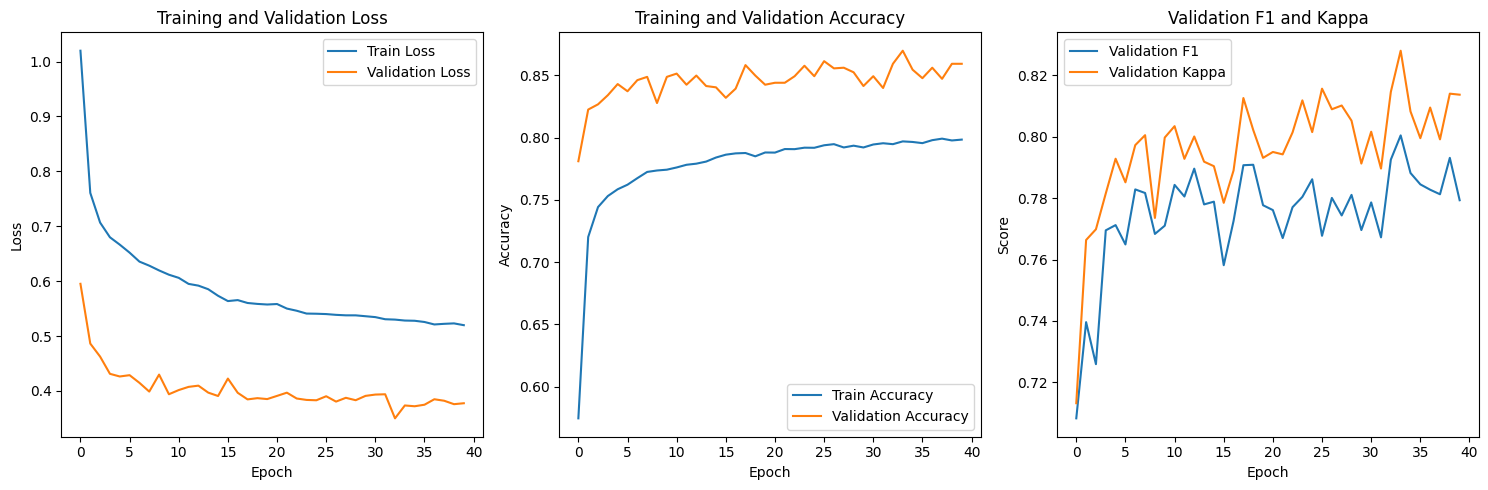


Fold 15/20
Test subject: SC4122
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 98/98 [00:00<00:00, 148.00it/s]


Epoch 1/200: Train Loss: 0.9497, Train Acc: 0.6148, Val Loss: 1.1321, Val Acc: 0.5384, Val F1: 0.5176, Val Kappa: 0.4188
✓ New best model saved! (Val Loss: 1.1321)


Validation: 100%|██████████| 98/98 [00:00<00:00, 142.01it/s]


Epoch 2/200: Train Loss: 0.7408, Train Acc: 0.7282, Val Loss: 0.9159, Val Acc: 0.6259, Val F1: 0.5928, Val Kappa: 0.5205
✓ New best model saved! (Val Loss: 0.9159)


Validation: 100%|██████████| 98/98 [00:00<00:00, 141.76it/s]


Epoch 3/200: Train Loss: 0.6957, Train Acc: 0.7480, Val Loss: 0.9438, Val Acc: 0.6075, Val F1: 0.5945, Val Kappa: 0.5005
! No improvement for 1 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 142.34it/s]


Epoch 4/200: Train Loss: 0.6675, Train Acc: 0.7568, Val Loss: 0.8900, Val Acc: 0.6546, Val F1: 0.6285, Val Kappa: 0.5538
✓ New best model saved! (Val Loss: 0.8900)


Validation: 100%|██████████| 98/98 [00:00<00:00, 150.56it/s]


Epoch 5/200: Train Loss: 0.6528, Train Acc: 0.7620, Val Loss: 0.8118, Val Acc: 0.7001, Val F1: 0.6424, Val Kappa: 0.6093
✓ New best model saved! (Val Loss: 0.8118)


Validation: 100%|██████████| 98/98 [00:00<00:00, 132.74it/s]


Epoch 6/200: Train Loss: 0.6413, Train Acc: 0.7655, Val Loss: 0.9288, Val Acc: 0.5977, Val F1: 0.5976, Val Kappa: 0.4899
! No improvement for 1 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 145.18it/s]


Epoch 7/200: Train Loss: 0.6280, Train Acc: 0.7697, Val Loss: 0.9504, Val Acc: 0.6279, Val F1: 0.6043, Val Kappa: 0.5239
! No improvement for 2 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 128.01it/s]


Epoch 8/200: Train Loss: 0.6185, Train Acc: 0.7732, Val Loss: 0.8634, Val Acc: 0.6996, Val F1: 0.6471, Val Kappa: 0.6070
! No improvement for 3 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 146.36it/s]


Epoch 9/200: Train Loss: 0.6111, Train Acc: 0.7751, Val Loss: 0.8437, Val Acc: 0.6535, Val F1: 0.6357, Val Kappa: 0.5566
! No improvement for 4 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 152.73it/s]


Epoch 10/200: Train Loss: 0.5985, Train Acc: 0.7801, Val Loss: 0.8076, Val Acc: 0.6970, Val F1: 0.6577, Val Kappa: 0.6075
✓ New best model saved! (Val Loss: 0.8076)


Validation: 100%|██████████| 98/98 [00:00<00:00, 137.38it/s]


Epoch 11/200: Train Loss: 0.5894, Train Acc: 0.7807, Val Loss: 0.7660, Val Acc: 0.7318, Val F1: 0.6669, Val Kappa: 0.6489
✓ New best model saved! (Val Loss: 0.7660)


Validation: 100%|██████████| 98/98 [00:00<00:00, 147.23it/s]


Epoch 12/200: Train Loss: 0.5883, Train Acc: 0.7816, Val Loss: 0.8014, Val Acc: 0.6965, Val F1: 0.6658, Val Kappa: 0.6076
! No improvement for 1 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 150.09it/s]


Epoch 13/200: Train Loss: 0.5815, Train Acc: 0.7844, Val Loss: 0.7771, Val Acc: 0.6965, Val F1: 0.6624, Val Kappa: 0.6082
! No improvement for 2 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 148.79it/s]


Epoch 14/200: Train Loss: 0.5801, Train Acc: 0.7854, Val Loss: 0.8638, Val Acc: 0.6781, Val F1: 0.6459, Val Kappa: 0.5844
! No improvement for 3 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 150.71it/s]


Epoch 15/200: Train Loss: 0.5765, Train Acc: 0.7841, Val Loss: 0.7660, Val Acc: 0.6853, Val F1: 0.6618, Val Kappa: 0.5961
! No improvement for 4 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 148.67it/s]


Epoch 16/200: Train Loss: 0.5664, Train Acc: 0.7884, Val Loss: 0.8415, Val Acc: 0.6689, Val F1: 0.6500, Val Kappa: 0.5742
! No improvement for 5 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 142.98it/s]


Epoch 17/200: Train Loss: 0.5678, Train Acc: 0.7881, Val Loss: 0.7315, Val Acc: 0.7052, Val F1: 0.6791, Val Kappa: 0.6210
✓ New best model saved! (Val Loss: 0.7315)


Validation: 100%|██████████| 98/98 [00:00<00:00, 136.20it/s]


Epoch 18/200: Train Loss: 0.5625, Train Acc: 0.7911, Val Loss: 0.7492, Val Acc: 0.7108, Val F1: 0.6907, Val Kappa: 0.6266
! No improvement for 1 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 132.76it/s]


Epoch 19/200: Train Loss: 0.5626, Train Acc: 0.7893, Val Loss: 0.7394, Val Acc: 0.7052, Val F1: 0.6910, Val Kappa: 0.6215
! No improvement for 2 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 146.80it/s]


Epoch 20/200: Train Loss: 0.5606, Train Acc: 0.7894, Val Loss: 0.8341, Val Acc: 0.6807, Val F1: 0.6506, Val Kappa: 0.5886
! No improvement for 3 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 146.04it/s]


Epoch 21/200: Train Loss: 0.5599, Train Acc: 0.7887, Val Loss: 0.8033, Val Acc: 0.6801, Val F1: 0.6588, Val Kappa: 0.5903
! No improvement for 4 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 141.71it/s]


Epoch 22/200: Train Loss: 0.5512, Train Acc: 0.7934, Val Loss: 0.8298, Val Acc: 0.6827, Val F1: 0.6569, Val Kappa: 0.5919
! No improvement for 5 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 144.15it/s]


Epoch 23/200: Train Loss: 0.5537, Train Acc: 0.7926, Val Loss: 0.7706, Val Acc: 0.7006, Val F1: 0.6706, Val Kappa: 0.6149
! No improvement for 6 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 133.98it/s]


Epoch 24/200: Train Loss: 0.5515, Train Acc: 0.7940, Val Loss: 0.8122, Val Acc: 0.6981, Val F1: 0.6668, Val Kappa: 0.6112
! No improvement for 7 epochs
Early stopping triggered after 24 epochs
✓ Loaded best model with Val Loss: 0.7315, Val Acc: 0.7052, Val F1: 0.6791, Val Kappa: 0.6210


Validation: 100%|██████████| 98/98 [00:00<00:00, 138.44it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9673    0.6621    0.7861       580
          N1     0.2566    0.3223    0.2857       242
          N2     0.7289    0.7683    0.7481       574
          N3     0.6531    1.0000    0.7901       160
         REM     0.7841    0.7940    0.7890       398

    accuracy                         0.7057      1954
   macro avg     0.6780    0.7093    0.6798      1954
weighted avg     0.7462    0.7057    0.7139      1954

Per-class F1 scores:
  W: 0.7861
  N1: 0.2857
  N2: 0.7481
  N3: 0.7901
  REM: 0.7890


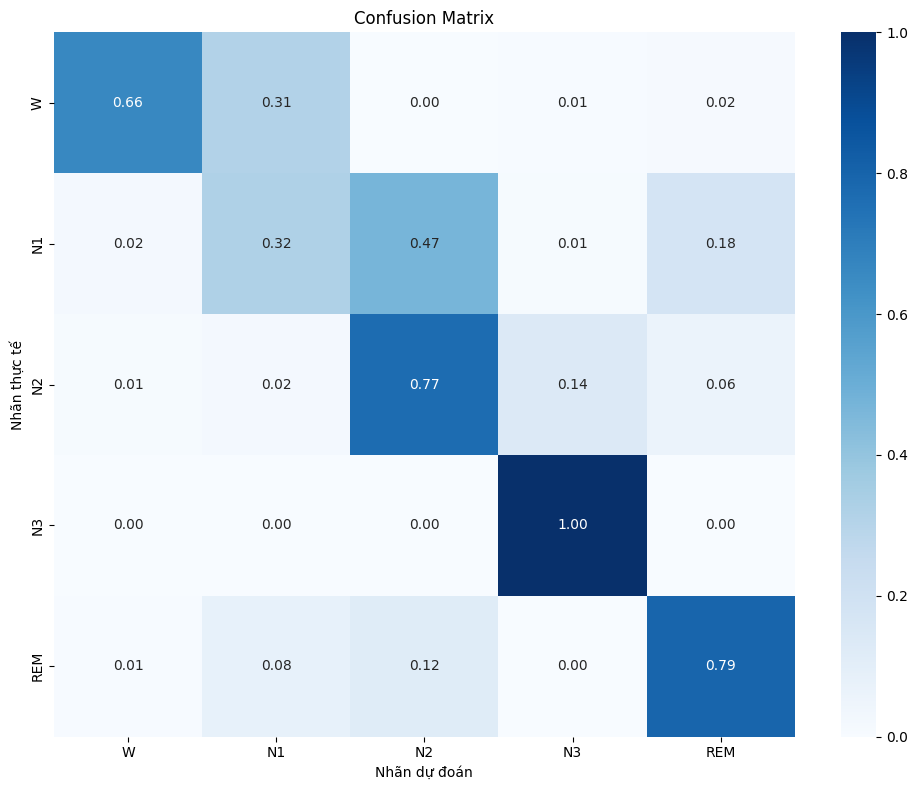

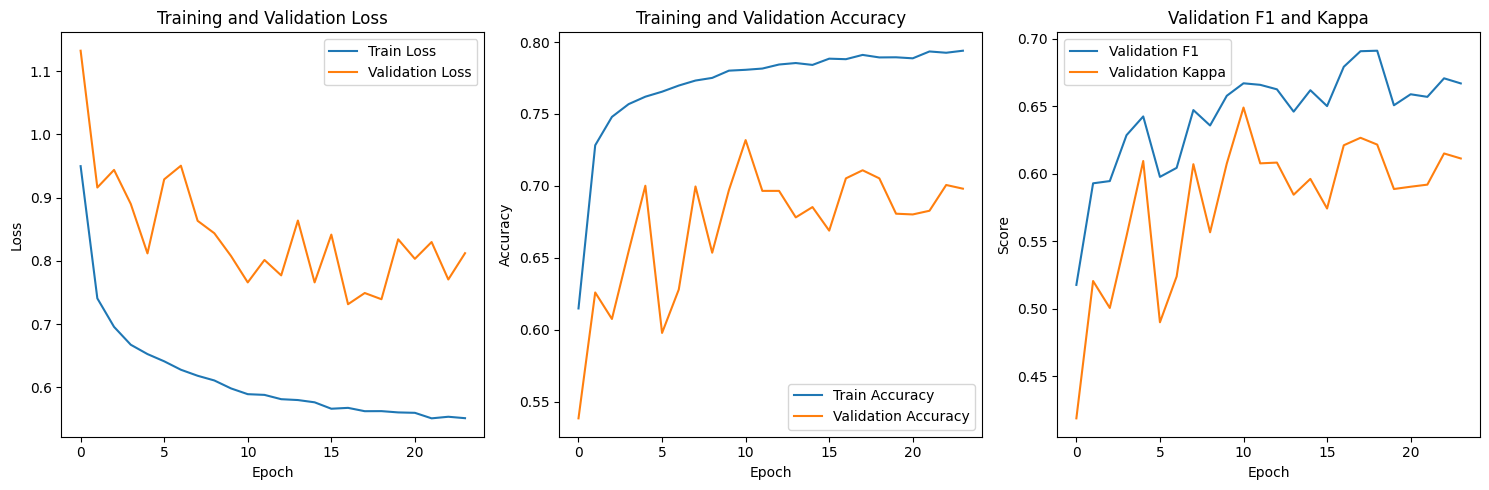


Fold 16/20
Test subject: SC4051
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 68/68 [00:00<00:00, 120.15it/s]


Epoch 1/200: Train Loss: 0.9803, Train Acc: 0.5903, Val Loss: 0.5669, Val Acc: 0.7760, Val F1: 0.7031, Val Kappa: 0.7099
✓ New best model saved! (Val Loss: 0.5669)


Validation: 100%|██████████| 68/68 [00:00<00:00, 125.88it/s]


Epoch 2/200: Train Loss: 0.7410, Train Acc: 0.7234, Val Loss: 0.5067, Val Acc: 0.8385, Val F1: 0.7507, Val Kappa: 0.7850
✓ New best model saved! (Val Loss: 0.5067)


Validation: 100%|██████████| 68/68 [00:00<00:00, 122.48it/s]


Epoch 3/200: Train Loss: 0.7015, Train Acc: 0.7431, Val Loss: 0.5043, Val Acc: 0.8646, Val F1: 0.7913, Val Kappa: 0.8189
✓ New best model saved! (Val Loss: 0.5043)


Validation: 100%|██████████| 68/68 [00:00<00:00, 122.14it/s]


Epoch 4/200: Train Loss: 0.6797, Train Acc: 0.7521, Val Loss: 0.5837, Val Acc: 0.8170, Val F1: 0.7415, Val Kappa: 0.7570
! No improvement for 1 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 123.55it/s]


Epoch 5/200: Train Loss: 0.6594, Train Acc: 0.7589, Val Loss: 0.4710, Val Acc: 0.8690, Val F1: 0.7791, Val Kappa: 0.8248
✓ New best model saved! (Val Loss: 0.4710)


Validation: 100%|██████████| 68/68 [00:00<00:00, 128.82it/s]


Epoch 6/200: Train Loss: 0.6471, Train Acc: 0.7638, Val Loss: 0.5265, Val Acc: 0.8467, Val F1: 0.7781, Val Kappa: 0.7951
! No improvement for 1 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 127.50it/s]


Epoch 7/200: Train Loss: 0.6370, Train Acc: 0.7678, Val Loss: 0.4493, Val Acc: 0.8594, Val F1: 0.7350, Val Kappa: 0.8115
✓ New best model saved! (Val Loss: 0.4493)


Validation: 100%|██████████| 68/68 [00:00<00:00, 112.35it/s]


Epoch 8/200: Train Loss: 0.6292, Train Acc: 0.7702, Val Loss: 0.4541, Val Acc: 0.8698, Val F1: 0.7915, Val Kappa: 0.8257
! No improvement for 1 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 122.95it/s]


Epoch 9/200: Train Loss: 0.6191, Train Acc: 0.7721, Val Loss: 0.4393, Val Acc: 0.8683, Val F1: 0.8001, Val Kappa: 0.8248
✓ New best model saved! (Val Loss: 0.4393)


Validation: 100%|██████████| 68/68 [00:00<00:00, 118.88it/s]


Epoch 10/200: Train Loss: 0.6115, Train Acc: 0.7746, Val Loss: 0.4240, Val Acc: 0.8728, Val F1: 0.7811, Val Kappa: 0.8296
✓ New best model saved! (Val Loss: 0.4240)


Validation: 100%|██████████| 68/68 [00:00<00:00, 120.39it/s]


Epoch 11/200: Train Loss: 0.6077, Train Acc: 0.7747, Val Loss: 0.4679, Val Acc: 0.8683, Val F1: 0.7608, Val Kappa: 0.8229
! No improvement for 1 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 124.82it/s]


Epoch 12/200: Train Loss: 0.6000, Train Acc: 0.7782, Val Loss: 0.4308, Val Acc: 0.8668, Val F1: 0.7917, Val Kappa: 0.8220
! No improvement for 2 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 120.69it/s]


Epoch 13/200: Train Loss: 0.5971, Train Acc: 0.7791, Val Loss: 0.4443, Val Acc: 0.8795, Val F1: 0.7980, Val Kappa: 0.8379
! No improvement for 3 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 122.59it/s]


Epoch 14/200: Train Loss: 0.5932, Train Acc: 0.7804, Val Loss: 0.4816, Val Acc: 0.8728, Val F1: 0.7969, Val Kappa: 0.8295
! No improvement for 4 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 125.00it/s]


Epoch 15/200: Train Loss: 0.5790, Train Acc: 0.7842, Val Loss: 0.4553, Val Acc: 0.8646, Val F1: 0.7899, Val Kappa: 0.8186
! No improvement for 5 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 108.56it/s]


Epoch 16/200: Train Loss: 0.5716, Train Acc: 0.7851, Val Loss: 0.4205, Val Acc: 0.8743, Val F1: 0.8104, Val Kappa: 0.8317
✓ New best model saved! (Val Loss: 0.4205)


Validation: 100%|██████████| 68/68 [00:00<00:00, 123.96it/s]


Epoch 17/200: Train Loss: 0.5673, Train Acc: 0.7860, Val Loss: 0.4232, Val Acc: 0.8653, Val F1: 0.8036, Val Kappa: 0.8215
! No improvement for 1 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 127.28it/s]


Epoch 18/200: Train Loss: 0.5636, Train Acc: 0.7877, Val Loss: 0.4408, Val Acc: 0.8757, Val F1: 0.8169, Val Kappa: 0.8339
! No improvement for 2 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 127.94it/s]


Epoch 19/200: Train Loss: 0.5639, Train Acc: 0.7874, Val Loss: 0.4076, Val Acc: 0.8713, Val F1: 0.8038, Val Kappa: 0.8282
✓ New best model saved! (Val Loss: 0.4076)


Validation: 100%|██████████| 68/68 [00:00<00:00, 126.62it/s]


Epoch 20/200: Train Loss: 0.5616, Train Acc: 0.7861, Val Loss: 0.4240, Val Acc: 0.8728, Val F1: 0.7939, Val Kappa: 0.8302
! No improvement for 1 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 121.74it/s]


Epoch 21/200: Train Loss: 0.5569, Train Acc: 0.7887, Val Loss: 0.4501, Val Acc: 0.8735, Val F1: 0.7998, Val Kappa: 0.8304
! No improvement for 2 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 116.37it/s]


Epoch 22/200: Train Loss: 0.5583, Train Acc: 0.7870, Val Loss: 0.4757, Val Acc: 0.8519, Val F1: 0.7784, Val Kappa: 0.8038
! No improvement for 3 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 122.32it/s]


Epoch 23/200: Train Loss: 0.5529, Train Acc: 0.7893, Val Loss: 0.4500, Val Acc: 0.8743, Val F1: 0.8034, Val Kappa: 0.8311
! No improvement for 4 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 126.76it/s]


Epoch 24/200: Train Loss: 0.5427, Train Acc: 0.7930, Val Loss: 0.4522, Val Acc: 0.8668, Val F1: 0.7922, Val Kappa: 0.8220
! No improvement for 5 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 119.07it/s]


Epoch 25/200: Train Loss: 0.5450, Train Acc: 0.7922, Val Loss: 0.4492, Val Acc: 0.8661, Val F1: 0.7911, Val Kappa: 0.8208
! No improvement for 6 epochs


Validation: 100%|██████████| 68/68 [00:00<00:00, 121.43it/s]


Epoch 26/200: Train Loss: 0.5420, Train Acc: 0.7942, Val Loss: 0.4314, Val Acc: 0.8720, Val F1: 0.8087, Val Kappa: 0.8285
! No improvement for 7 epochs
Early stopping triggered after 26 epochs
✓ Loaded best model with Val Loss: 0.4076, Val Acc: 0.8713, Val F1: 0.8038, Val Kappa: 0.8282


Validation: 100%|██████████| 68/68 [00:00<00:00, 122.82it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9704    0.9471    0.9586       416
          N1     0.5753    0.4773    0.5217        88
          N2     0.9175    0.8456    0.8801       434
          N3     0.8552    0.9407    0.8959       270
         REM     0.7143    0.8824    0.7895       136

    accuracy                         0.8757      1344
   macro avg     0.8066    0.8186    0.8092      1344
weighted avg     0.8784    0.8757    0.8750      1344

Per-class F1 scores:
  W: 0.9586
  N1: 0.5217
  N2: 0.8801
  N3: 0.8959
  REM: 0.7895


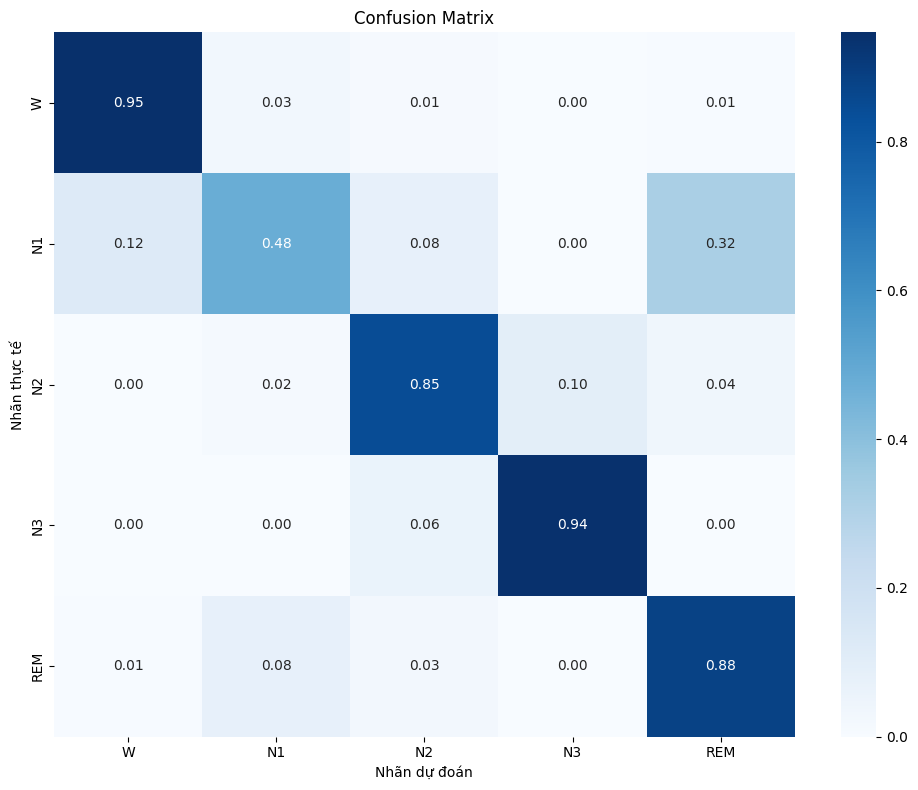

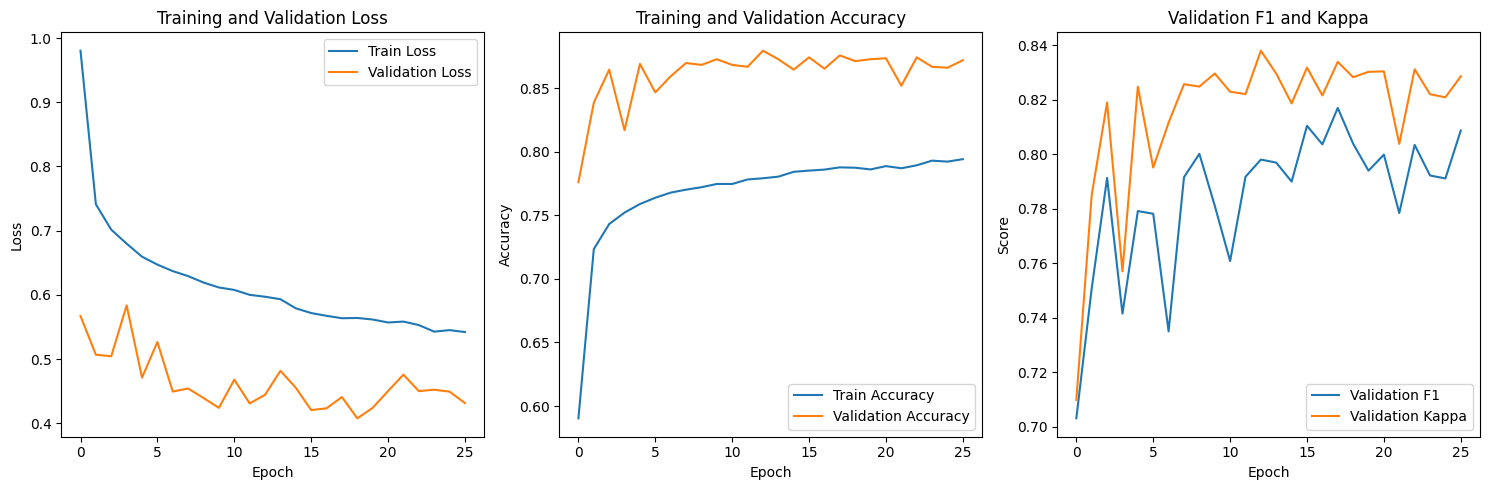


Fold 17/20
Test subject: SC4002
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 113/113 [00:00<00:00, 148.44it/s]


Epoch 1/200: Train Loss: 0.9962, Train Acc: 0.5950, Val Loss: 0.6301, Val Acc: 0.7671, Val F1: 0.6613, Val Kappa: 0.6954
✓ New best model saved! (Val Loss: 0.6301)


Validation: 100%|██████████| 113/113 [00:00<00:00, 151.41it/s]


Epoch 2/200: Train Loss: 0.7471, Train Acc: 0.7263, Val Loss: 0.6186, Val Acc: 0.7990, Val F1: 0.6778, Val Kappa: 0.7355
✓ New best model saved! (Val Loss: 0.6186)


Validation: 100%|██████████| 113/113 [00:00<00:00, 151.95it/s]


Epoch 3/200: Train Loss: 0.7003, Train Acc: 0.7428, Val Loss: 0.5831, Val Acc: 0.7786, Val F1: 0.6958, Val Kappa: 0.7117
✓ New best model saved! (Val Loss: 0.5831)


Validation: 100%|██████████| 113/113 [00:00<00:00, 147.30it/s]


Epoch 4/200: Train Loss: 0.6695, Train Acc: 0.7541, Val Loss: 0.5427, Val Acc: 0.8030, Val F1: 0.7014, Val Kappa: 0.7424
✓ New best model saved! (Val Loss: 0.5427)


Validation: 100%|██████████| 113/113 [00:00<00:00, 151.44it/s]


Epoch 5/200: Train Loss: 0.6530, Train Acc: 0.7597, Val Loss: 0.5320, Val Acc: 0.8070, Val F1: 0.7078, Val Kappa: 0.7475
✓ New best model saved! (Val Loss: 0.5320)


Validation: 100%|██████████| 113/113 [00:00<00:00, 147.87it/s]


Epoch 6/200: Train Loss: 0.6365, Train Acc: 0.7671, Val Loss: 0.5358, Val Acc: 0.8146, Val F1: 0.7040, Val Kappa: 0.7562
! No improvement for 1 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 154.60it/s]


Epoch 7/200: Train Loss: 0.6302, Train Acc: 0.7685, Val Loss: 0.5836, Val Acc: 0.7897, Val F1: 0.7017, Val Kappa: 0.7253
! No improvement for 2 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 140.55it/s]


Epoch 8/200: Train Loss: 0.6194, Train Acc: 0.7727, Val Loss: 0.5203, Val Acc: 0.8305, Val F1: 0.7197, Val Kappa: 0.7767
✓ New best model saved! (Val Loss: 0.5203)


Validation: 100%|██████████| 113/113 [00:00<00:00, 148.30it/s]


Epoch 9/200: Train Loss: 0.6120, Train Acc: 0.7737, Val Loss: 0.5323, Val Acc: 0.8083, Val F1: 0.7200, Val Kappa: 0.7497
! No improvement for 1 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 156.54it/s]


Epoch 10/200: Train Loss: 0.6051, Train Acc: 0.7775, Val Loss: 0.5353, Val Acc: 0.8039, Val F1: 0.7246, Val Kappa: 0.7445
! No improvement for 2 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 140.90it/s]


Epoch 11/200: Train Loss: 0.5986, Train Acc: 0.7748, Val Loss: 0.5375, Val Acc: 0.7884, Val F1: 0.7021, Val Kappa: 0.7246
! No improvement for 3 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 152.56it/s]


Epoch 12/200: Train Loss: 0.5912, Train Acc: 0.7796, Val Loss: 0.5160, Val Acc: 0.7981, Val F1: 0.7163, Val Kappa: 0.7371
✓ New best model saved! (Val Loss: 0.5160)


Validation: 100%|██████████| 113/113 [00:00<00:00, 146.56it/s]


Epoch 13/200: Train Loss: 0.5883, Train Acc: 0.7786, Val Loss: 0.5331, Val Acc: 0.8274, Val F1: 0.7171, Val Kappa: 0.7724
! No improvement for 1 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 153.00it/s]


Epoch 14/200: Train Loss: 0.5855, Train Acc: 0.7793, Val Loss: 0.5232, Val Acc: 0.8363, Val F1: 0.7427, Val Kappa: 0.7851
! No improvement for 2 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 151.06it/s]


Epoch 15/200: Train Loss: 0.5766, Train Acc: 0.7819, Val Loss: 0.5445, Val Acc: 0.8252, Val F1: 0.7273, Val Kappa: 0.7696
! No improvement for 3 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 138.93it/s]


Epoch 16/200: Train Loss: 0.5736, Train Acc: 0.7816, Val Loss: 0.4989, Val Acc: 0.8039, Val F1: 0.7128, Val Kappa: 0.7447
✓ New best model saved! (Val Loss: 0.4989)


Validation: 100%|██████████| 113/113 [00:00<00:00, 147.00it/s]


Epoch 17/200: Train Loss: 0.5748, Train Acc: 0.7810, Val Loss: 0.5643, Val Acc: 0.7675, Val F1: 0.6994, Val Kappa: 0.6999
! No improvement for 1 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 149.07it/s]


Epoch 18/200: Train Loss: 0.5659, Train Acc: 0.7856, Val Loss: 0.5849, Val Acc: 0.8008, Val F1: 0.7030, Val Kappa: 0.7399
! No improvement for 2 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 147.13it/s]


Epoch 19/200: Train Loss: 0.5639, Train Acc: 0.7846, Val Loss: 0.5392, Val Acc: 0.7857, Val F1: 0.7067, Val Kappa: 0.7221
! No improvement for 3 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 154.37it/s]


Epoch 20/200: Train Loss: 0.5612, Train Acc: 0.7850, Val Loss: 0.5381, Val Acc: 0.7946, Val F1: 0.7096, Val Kappa: 0.7332
! No improvement for 4 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 148.14it/s]


Epoch 21/200: Train Loss: 0.5469, Train Acc: 0.7907, Val Loss: 0.5002, Val Acc: 0.8083, Val F1: 0.7253, Val Kappa: 0.7501
! No improvement for 5 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 147.76it/s]


Epoch 22/200: Train Loss: 0.5438, Train Acc: 0.7918, Val Loss: 0.4866, Val Acc: 0.8150, Val F1: 0.7424, Val Kappa: 0.7597
✓ New best model saved! (Val Loss: 0.4866)


Validation: 100%|██████████| 113/113 [00:00<00:00, 152.73it/s]


Epoch 23/200: Train Loss: 0.5373, Train Acc: 0.7932, Val Loss: 0.5917, Val Acc: 0.7831, Val F1: 0.6990, Val Kappa: 0.7177
! No improvement for 1 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 153.76it/s]


Epoch 24/200: Train Loss: 0.5356, Train Acc: 0.7932, Val Loss: 0.5121, Val Acc: 0.8026, Val F1: 0.7290, Val Kappa: 0.7436
! No improvement for 2 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 145.67it/s]


Epoch 25/200: Train Loss: 0.5409, Train Acc: 0.7909, Val Loss: 0.5372, Val Acc: 0.8256, Val F1: 0.7314, Val Kappa: 0.7711
! No improvement for 3 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 148.30it/s]


Epoch 26/200: Train Loss: 0.5347, Train Acc: 0.7931, Val Loss: 0.5312, Val Acc: 0.8199, Val F1: 0.7322, Val Kappa: 0.7649
! No improvement for 4 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 150.34it/s]


Epoch 27/200: Train Loss: 0.5264, Train Acc: 0.7973, Val Loss: 0.5072, Val Acc: 0.8287, Val F1: 0.7405, Val Kappa: 0.7758
! No improvement for 5 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 157.19it/s]


Epoch 28/200: Train Loss: 0.5231, Train Acc: 0.7974, Val Loss: 0.5359, Val Acc: 0.8208, Val F1: 0.7341, Val Kappa: 0.7659
! No improvement for 6 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 127.12it/s]


Epoch 29/200: Train Loss: 0.5260, Train Acc: 0.7970, Val Loss: 0.4726, Val Acc: 0.8212, Val F1: 0.7362, Val Kappa: 0.7667
✓ New best model saved! (Val Loss: 0.4726)


Validation: 100%|██████████| 113/113 [00:00<00:00, 149.38it/s]


Epoch 30/200: Train Loss: 0.5220, Train Acc: 0.7977, Val Loss: 0.5250, Val Acc: 0.7986, Val F1: 0.7153, Val Kappa: 0.7382
! No improvement for 1 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 145.41it/s]


Epoch 31/200: Train Loss: 0.5194, Train Acc: 0.7978, Val Loss: 0.5561, Val Acc: 0.7999, Val F1: 0.7135, Val Kappa: 0.7390
! No improvement for 2 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 144.02it/s]


Epoch 32/200: Train Loss: 0.5183, Train Acc: 0.7988, Val Loss: 0.5046, Val Acc: 0.8159, Val F1: 0.7379, Val Kappa: 0.7600
! No improvement for 3 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 143.42it/s]


Epoch 33/200: Train Loss: 0.5166, Train Acc: 0.7986, Val Loss: 0.5239, Val Acc: 0.8274, Val F1: 0.7349, Val Kappa: 0.7736
! No improvement for 4 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 134.30it/s]


Epoch 34/200: Train Loss: 0.5142, Train Acc: 0.7995, Val Loss: 0.5053, Val Acc: 0.8088, Val F1: 0.7327, Val Kappa: 0.7520
! No improvement for 5 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 148.37it/s]


Epoch 35/200: Train Loss: 0.5110, Train Acc: 0.8020, Val Loss: 0.5528, Val Acc: 0.8057, Val F1: 0.7196, Val Kappa: 0.7464
! No improvement for 6 epochs


Validation: 100%|██████████| 113/113 [00:00<00:00, 144.46it/s]


Epoch 36/200: Train Loss: 0.5151, Train Acc: 0.8005, Val Loss: 0.5472, Val Acc: 0.8061, Val F1: 0.7101, Val Kappa: 0.7456
! No improvement for 7 epochs
Early stopping triggered after 36 epochs
✓ Loaded best model with Val Loss: 0.4726, Val Acc: 0.8212, Val F1: 0.7362, Val Kappa: 0.7667


Validation: 100%|██████████| 113/113 [00:00<00:00, 148.80it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9702    0.8005    0.8772       366
          N1     0.1984    0.4153    0.2685       118
          N2     0.9455    0.8378    0.8884       746
          N3     0.9225    0.9613    0.9415       594
         REM     0.7671    0.7581    0.7626       430

    accuracy                         0.8270      2254
   macro avg     0.7607    0.7546    0.7476      2254
weighted avg     0.8703    0.8270    0.8441      2254

Per-class F1 scores:
  W: 0.8772
  N1: 0.2685
  N2: 0.8884
  N3: 0.9415
  REM: 0.7626


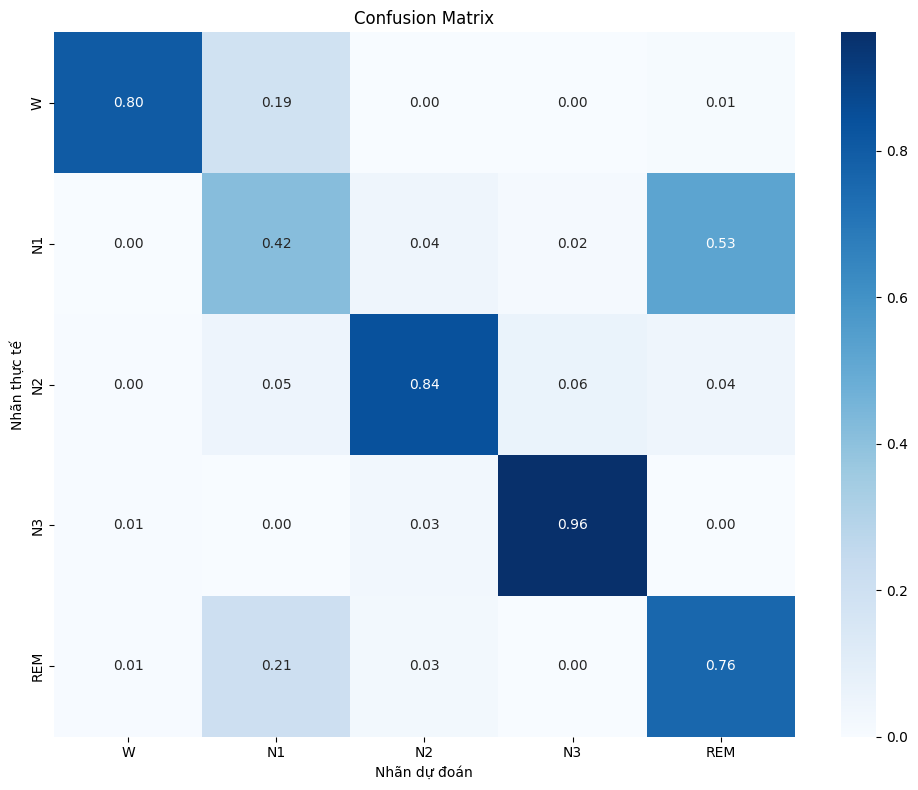

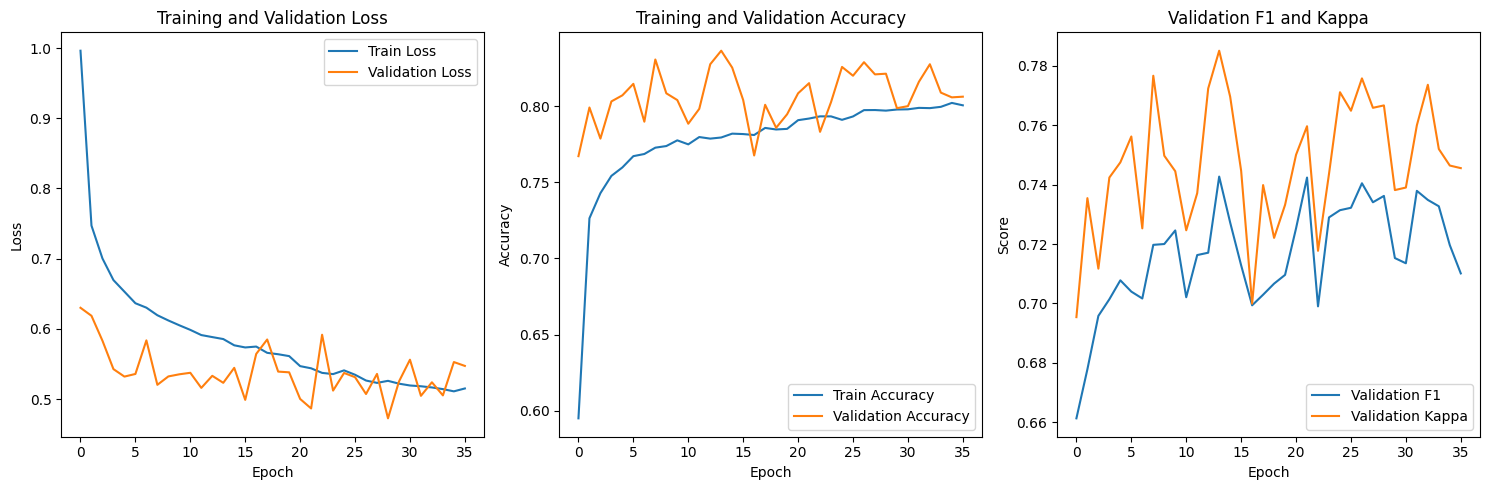


Fold 18/20
Test subject: SC4071
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 98/98 [00:00<00:00, 135.76it/s]


Epoch 1/200: Train Loss: 0.9619, Train Acc: 0.6031, Val Loss: 0.6279, Val Acc: 0.8048, Val F1: 0.7353, Val Kappa: 0.7364
✓ New best model saved! (Val Loss: 0.6279)


Validation: 100%|██████████| 98/98 [00:00<00:00, 135.59it/s]


Epoch 2/200: Train Loss: 0.7466, Train Acc: 0.7279, Val Loss: 0.5919, Val Acc: 0.7889, Val F1: 0.7439, Val Kappa: 0.7179
✓ New best model saved! (Val Loss: 0.5919)


Validation: 100%|██████████| 98/98 [00:00<00:00, 141.51it/s]


Epoch 3/200: Train Loss: 0.6984, Train Acc: 0.7469, Val Loss: 0.5924, Val Acc: 0.7541, Val F1: 0.7176, Val Kappa: 0.6770
! No improvement for 1 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 133.74it/s]


Epoch 4/200: Train Loss: 0.6754, Train Acc: 0.7579, Val Loss: 0.5263, Val Acc: 0.8161, Val F1: 0.7755, Val Kappa: 0.7534
✓ New best model saved! (Val Loss: 0.5263)


Validation: 100%|██████████| 98/98 [00:00<00:00, 136.84it/s]


Epoch 5/200: Train Loss: 0.6579, Train Acc: 0.7626, Val Loss: 0.5790, Val Acc: 0.7643, Val F1: 0.7382, Val Kappa: 0.6905
! No improvement for 1 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 129.57it/s]


Epoch 6/200: Train Loss: 0.6422, Train Acc: 0.7670, Val Loss: 0.5532, Val Acc: 0.7905, Val F1: 0.7482, Val Kappa: 0.7207
! No improvement for 2 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 136.64it/s]


Epoch 7/200: Train Loss: 0.6356, Train Acc: 0.7696, Val Loss: 0.5269, Val Acc: 0.7930, Val F1: 0.7567, Val Kappa: 0.7247
! No improvement for 3 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 140.85it/s]


Epoch 8/200: Train Loss: 0.6259, Train Acc: 0.7715, Val Loss: 0.5221, Val Acc: 0.7935, Val F1: 0.7575, Val Kappa: 0.7258
✓ New best model saved! (Val Loss: 0.5221)


Validation: 100%|██████████| 98/98 [00:00<00:00, 140.48it/s]


Epoch 9/200: Train Loss: 0.6165, Train Acc: 0.7726, Val Loss: 0.5630, Val Acc: 0.7669, Val F1: 0.7406, Val Kappa: 0.6940
! No improvement for 1 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 139.72it/s]


Epoch 10/200: Train Loss: 0.6088, Train Acc: 0.7776, Val Loss: 0.5713, Val Acc: 0.7756, Val F1: 0.7349, Val Kappa: 0.7011
! No improvement for 2 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 122.57it/s]


Epoch 11/200: Train Loss: 0.6054, Train Acc: 0.7778, Val Loss: 0.5602, Val Acc: 0.7930, Val F1: 0.7607, Val Kappa: 0.7237
! No improvement for 3 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 138.55it/s]


Epoch 12/200: Train Loss: 0.5952, Train Acc: 0.7787, Val Loss: 0.5124, Val Acc: 0.7997, Val F1: 0.7652, Val Kappa: 0.7339
✓ New best model saved! (Val Loss: 0.5124)


Validation: 100%|██████████| 98/98 [00:00<00:00, 136.70it/s]


Epoch 13/200: Train Loss: 0.5914, Train Acc: 0.7809, Val Loss: 0.5692, Val Acc: 0.7720, Val F1: 0.7399, Val Kappa: 0.6995
! No improvement for 1 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 139.70it/s]


Epoch 14/200: Train Loss: 0.5875, Train Acc: 0.7811, Val Loss: 0.5803, Val Acc: 0.7618, Val F1: 0.7317, Val Kappa: 0.6860
! No improvement for 2 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 137.49it/s]


Epoch 15/200: Train Loss: 0.5836, Train Acc: 0.7813, Val Loss: 0.5074, Val Acc: 0.7961, Val F1: 0.7657, Val Kappa: 0.7303
✓ New best model saved! (Val Loss: 0.5074)


Validation: 100%|██████████| 98/98 [00:00<00:00, 135.97it/s]


Epoch 16/200: Train Loss: 0.5793, Train Acc: 0.7813, Val Loss: 0.5391, Val Acc: 0.8099, Val F1: 0.7711, Val Kappa: 0.7446
! No improvement for 1 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 134.89it/s]


Epoch 17/200: Train Loss: 0.5705, Train Acc: 0.7843, Val Loss: 0.5252, Val Acc: 0.7894, Val F1: 0.7609, Val Kappa: 0.7221
! No improvement for 2 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 138.32it/s]


Epoch 18/200: Train Loss: 0.5727, Train Acc: 0.7829, Val Loss: 0.5625, Val Acc: 0.7782, Val F1: 0.7443, Val Kappa: 0.7067
! No improvement for 3 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 125.69it/s]


Epoch 19/200: Train Loss: 0.5653, Train Acc: 0.7859, Val Loss: 0.5040, Val Acc: 0.7874, Val F1: 0.7604, Val Kappa: 0.7205
✓ New best model saved! (Val Loss: 0.5040)


Validation: 100%|██████████| 98/98 [00:00<00:00, 137.41it/s]


Epoch 20/200: Train Loss: 0.5637, Train Acc: 0.7863, Val Loss: 0.5578, Val Acc: 0.7915, Val F1: 0.7630, Val Kappa: 0.7224
! No improvement for 1 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 134.39it/s]


Epoch 21/200: Train Loss: 0.5576, Train Acc: 0.7885, Val Loss: 0.5006, Val Acc: 0.8135, Val F1: 0.7809, Val Kappa: 0.7513
✓ New best model saved! (Val Loss: 0.5006)


Validation: 100%|██████████| 98/98 [00:00<00:00, 136.24it/s]


Epoch 22/200: Train Loss: 0.5580, Train Acc: 0.7854, Val Loss: 0.5297, Val Acc: 0.7941, Val F1: 0.7616, Val Kappa: 0.7274
! No improvement for 1 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 140.36it/s]


Epoch 23/200: Train Loss: 0.5542, Train Acc: 0.7895, Val Loss: 0.5157, Val Acc: 0.7900, Val F1: 0.7656, Val Kappa: 0.7235
! No improvement for 2 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 120.34it/s]


Epoch 24/200: Train Loss: 0.5532, Train Acc: 0.7870, Val Loss: 0.5033, Val Acc: 0.8171, Val F1: 0.7844, Val Kappa: 0.7555
! No improvement for 3 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 129.04it/s]


Epoch 25/200: Train Loss: 0.5503, Train Acc: 0.7893, Val Loss: 0.4695, Val Acc: 0.8089, Val F1: 0.7849, Val Kappa: 0.7485
✓ New best model saved! (Val Loss: 0.4695)


Validation: 100%|██████████| 98/98 [00:00<00:00, 134.08it/s]


Epoch 26/200: Train Loss: 0.5469, Train Acc: 0.7902, Val Loss: 0.5571, Val Acc: 0.7577, Val F1: 0.7313, Val Kappa: 0.6831
! No improvement for 1 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 137.15it/s]


Epoch 27/200: Train Loss: 0.5492, Train Acc: 0.7913, Val Loss: 0.5497, Val Acc: 0.7833, Val F1: 0.7517, Val Kappa: 0.7129
! No improvement for 2 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 132.57it/s]


Epoch 28/200: Train Loss: 0.5460, Train Acc: 0.7906, Val Loss: 0.4999, Val Acc: 0.8023, Val F1: 0.7729, Val Kappa: 0.7386
! No improvement for 3 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 116.45it/s]


Epoch 29/200: Train Loss: 0.5417, Train Acc: 0.7924, Val Loss: 0.4601, Val Acc: 0.8263, Val F1: 0.7981, Val Kappa: 0.7690
✓ New best model saved! (Val Loss: 0.4601)


Validation: 100%|██████████| 98/98 [00:00<00:00, 137.67it/s]


Epoch 30/200: Train Loss: 0.5423, Train Acc: 0.7914, Val Loss: 0.4945, Val Acc: 0.7951, Val F1: 0.7637, Val Kappa: 0.7282
! No improvement for 1 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 140.30it/s]


Epoch 31/200: Train Loss: 0.5384, Train Acc: 0.7916, Val Loss: 0.5316, Val Acc: 0.7910, Val F1: 0.7641, Val Kappa: 0.7233
! No improvement for 2 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 131.05it/s]


Epoch 32/200: Train Loss: 0.5353, Train Acc: 0.7917, Val Loss: 0.5127, Val Acc: 0.7874, Val F1: 0.7559, Val Kappa: 0.7196
! No improvement for 3 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 130.40it/s]


Epoch 33/200: Train Loss: 0.5322, Train Acc: 0.7963, Val Loss: 0.5636, Val Acc: 0.7848, Val F1: 0.7577, Val Kappa: 0.7152
! No improvement for 4 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 141.27it/s]


Epoch 34/200: Train Loss: 0.5207, Train Acc: 0.7985, Val Loss: 0.5176, Val Acc: 0.7889, Val F1: 0.7672, Val Kappa: 0.7228
! No improvement for 5 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 127.01it/s]


Epoch 35/200: Train Loss: 0.5179, Train Acc: 0.8006, Val Loss: 0.4954, Val Acc: 0.8151, Val F1: 0.7832, Val Kappa: 0.7535
! No improvement for 6 epochs


Validation: 100%|██████████| 98/98 [00:00<00:00, 137.38it/s]


Epoch 36/200: Train Loss: 0.5142, Train Acc: 0.8002, Val Loss: 0.5018, Val Acc: 0.8166, Val F1: 0.7835, Val Kappa: 0.7547
! No improvement for 7 epochs
Early stopping triggered after 36 epochs
✓ Loaded best model with Val Loss: 0.4601, Val Acc: 0.8263, Val F1: 0.7981, Val Kappa: 0.7690


Validation: 100%|██████████| 98/98 [00:00<00:00, 136.73it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9450    0.8306    0.8841       248
          N1     0.4322    0.7697    0.5535       178
          N2     0.9294    0.8325    0.8783       806
          N3     0.7789    0.9784    0.8673       324
         REM     0.9514    0.6919    0.8012       396

    accuracy                         0.8222      1952
   macro avg     0.8074    0.8206    0.7969      1952
weighted avg     0.8655    0.8222    0.8319      1952

Per-class F1 scores:
  W: 0.8841
  N1: 0.5535
  N2: 0.8783
  N3: 0.8673
  REM: 0.8012


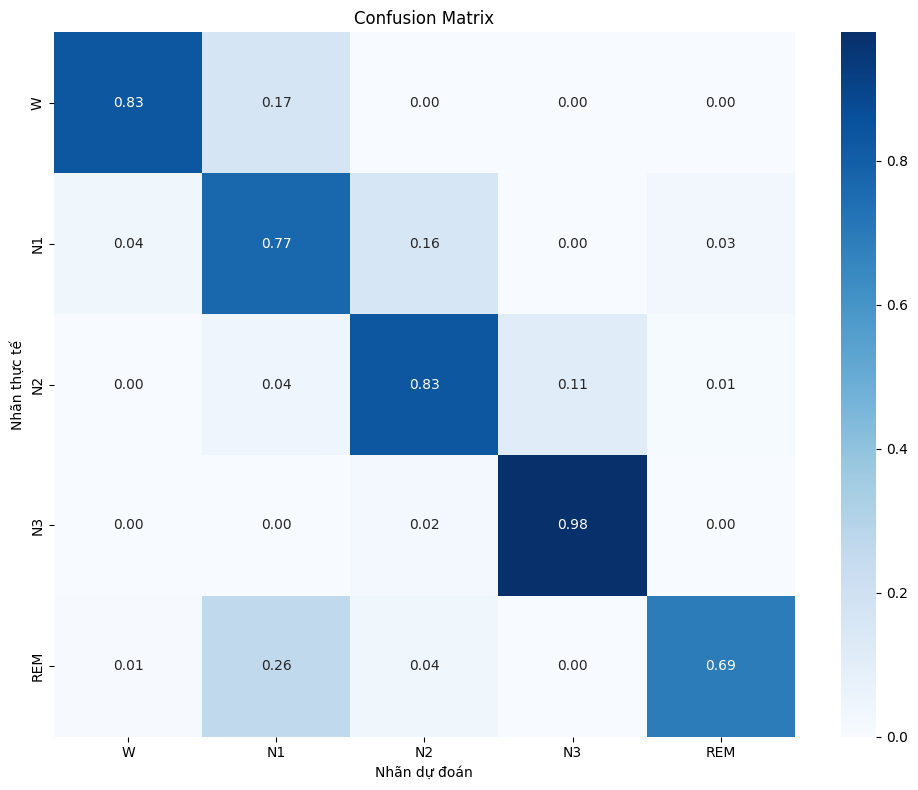

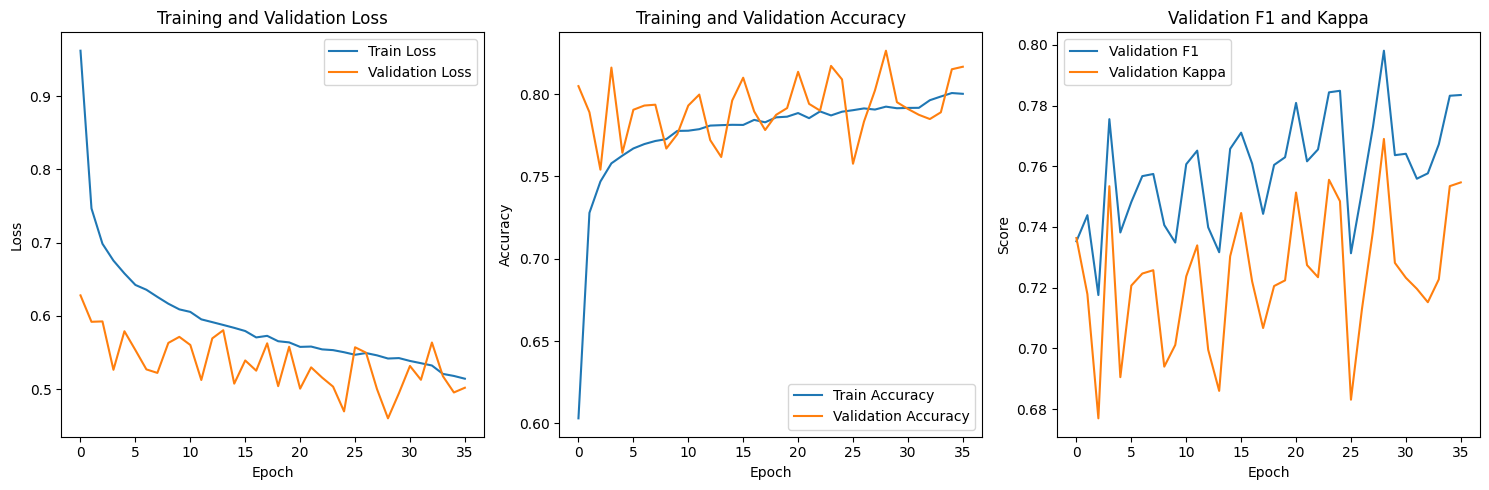


Fold 19/20
Test subject: SC4141
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 101/101 [00:00<00:00, 126.72it/s]


Epoch 1/200: Train Loss: 0.9541, Train Acc: 0.6198, Val Loss: 0.5384, Val Acc: 0.8850, Val F1: 0.7615, Val Kappa: 0.8408
✓ New best model saved! (Val Loss: 0.5384)


Validation: 100%|██████████| 101/101 [00:00<00:00, 140.08it/s]


Epoch 2/200: Train Loss: 0.7371, Train Acc: 0.7303, Val Loss: 0.5257, Val Acc: 0.8835, Val F1: 0.7464, Val Kappa: 0.8383
✓ New best model saved! (Val Loss: 0.5257)


Validation: 100%|██████████| 101/101 [00:00<00:00, 129.17it/s]


Epoch 3/200: Train Loss: 0.6992, Train Acc: 0.7447, Val Loss: 0.5596, Val Acc: 0.8695, Val F1: 0.7454, Val Kappa: 0.8189
! No improvement for 1 epochs


Validation: 100%|██████████| 101/101 [00:00<00:00, 134.28it/s]


Epoch 4/200: Train Loss: 0.6752, Train Acc: 0.7541, Val Loss: 0.4908, Val Acc: 0.8884, Val F1: 0.7568, Val Kappa: 0.8448
✓ New best model saved! (Val Loss: 0.4908)


Validation: 100%|██████████| 101/101 [00:00<00:00, 137.74it/s]


Epoch 5/200: Train Loss: 0.6572, Train Acc: 0.7635, Val Loss: 0.4925, Val Acc: 0.8805, Val F1: 0.7440, Val Kappa: 0.8347
! No improvement for 1 epochs


Validation: 100%|██████████| 101/101 [00:00<00:00, 128.06it/s]


Epoch 6/200: Train Loss: 0.6423, Train Acc: 0.7676, Val Loss: 0.5226, Val Acc: 0.8720, Val F1: 0.7442, Val Kappa: 0.8241
! No improvement for 2 epochs


Validation: 100%|██████████| 101/101 [00:00<00:00, 133.09it/s]


Epoch 7/200: Train Loss: 0.6310, Train Acc: 0.7675, Val Loss: 0.4890, Val Acc: 0.8904, Val F1: 0.7686, Val Kappa: 0.8484
✓ New best model saved! (Val Loss: 0.4890)


Validation: 100%|██████████| 101/101 [00:00<00:00, 142.19it/s]


Epoch 8/200: Train Loss: 0.6268, Train Acc: 0.7705, Val Loss: 0.4921, Val Acc: 0.8875, Val F1: 0.7771, Val Kappa: 0.8438
! No improvement for 1 epochs


Validation: 100%|██████████| 101/101 [00:00<00:00, 144.07it/s]


Epoch 9/200: Train Loss: 0.6195, Train Acc: 0.7735, Val Loss: 0.4937, Val Acc: 0.8810, Val F1: 0.7469, Val Kappa: 0.8349
! No improvement for 2 epochs


Validation: 100%|██████████| 101/101 [00:00<00:00, 133.98it/s]


Epoch 10/200: Train Loss: 0.6112, Train Acc: 0.7742, Val Loss: 0.5077, Val Acc: 0.8775, Val F1: 0.7534, Val Kappa: 0.8312
! No improvement for 3 epochs


Validation: 100%|██████████| 101/101 [00:00<00:00, 121.36it/s]


Epoch 11/200: Train Loss: 0.6017, Train Acc: 0.7771, Val Loss: 0.4785, Val Acc: 0.8850, Val F1: 0.7617, Val Kappa: 0.8408
✓ New best model saved! (Val Loss: 0.4785)


Validation: 100%|██████████| 101/101 [00:00<00:00, 137.53it/s]


Epoch 12/200: Train Loss: 0.5975, Train Acc: 0.7780, Val Loss: 0.4914, Val Acc: 0.8830, Val F1: 0.7610, Val Kappa: 0.8381
! No improvement for 1 epochs


Validation: 100%|██████████| 101/101 [00:00<00:00, 138.31it/s]


Epoch 13/200: Train Loss: 0.5906, Train Acc: 0.7783, Val Loss: 0.4760, Val Acc: 0.8875, Val F1: 0.7737, Val Kappa: 0.8449
✓ New best model saved! (Val Loss: 0.4760)


Validation: 100%|██████████| 101/101 [00:00<00:00, 138.58it/s]


Epoch 14/200: Train Loss: 0.5843, Train Acc: 0.7817, Val Loss: 0.4256, Val Acc: 0.8914, Val F1: 0.7691, Val Kappa: 0.8508
✓ New best model saved! (Val Loss: 0.4256)


Validation: 100%|██████████| 101/101 [00:00<00:00, 134.97it/s]


Epoch 15/200: Train Loss: 0.5806, Train Acc: 0.7816, Val Loss: 0.4538, Val Acc: 0.8939, Val F1: 0.7694, Val Kappa: 0.8543
! No improvement for 1 epochs


Validation: 100%|██████████| 101/101 [00:00<00:00, 127.96it/s]


Epoch 16/200: Train Loss: 0.5776, Train Acc: 0.7805, Val Loss: 0.5069, Val Acc: 0.8835, Val F1: 0.7605, Val Kappa: 0.8394
! No improvement for 2 epochs


Validation: 100%|██████████| 101/101 [00:00<00:00, 131.81it/s]


Epoch 17/200: Train Loss: 0.5737, Train Acc: 0.7836, Val Loss: 0.5052, Val Acc: 0.8840, Val F1: 0.7530, Val Kappa: 0.8394
! No improvement for 3 epochs


Validation: 100%|██████████| 101/101 [00:00<00:00, 139.43it/s]


Epoch 18/200: Train Loss: 0.5699, Train Acc: 0.7836, Val Loss: 0.4658, Val Acc: 0.8795, Val F1: 0.7617, Val Kappa: 0.8349
! No improvement for 4 epochs


Validation: 100%|██████████| 101/101 [00:00<00:00, 138.52it/s]


Epoch 19/200: Train Loss: 0.5571, Train Acc: 0.7889, Val Loss: 0.4499, Val Acc: 0.8904, Val F1: 0.7702, Val Kappa: 0.8495
! No improvement for 5 epochs


Validation: 100%|██████████| 101/101 [00:00<00:00, 135.18it/s]


Epoch 20/200: Train Loss: 0.5520, Train Acc: 0.7896, Val Loss: 0.5129, Val Acc: 0.8875, Val F1: 0.7688, Val Kappa: 0.8449
! No improvement for 6 epochs


Validation: 100%|██████████| 101/101 [00:00<00:00, 135.69it/s]


Epoch 21/200: Train Loss: 0.5475, Train Acc: 0.7893, Val Loss: 0.5170, Val Acc: 0.8845, Val F1: 0.7680, Val Kappa: 0.8417
! No improvement for 7 epochs
Early stopping triggered after 21 epochs
✓ Loaded best model with Val Loss: 0.4256, Val Acc: 0.8914, Val F1: 0.7691, Val Kappa: 0.8508


Validation: 100%|██████████| 101/101 [00:00<00:00, 136.09it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9722    0.7487    0.8459       374
          N1     0.1413    0.2241    0.1733        58
          N2     0.9254    0.9369    0.9311       808
          N3     0.9154    0.9669    0.9404       302
         REM     0.9063    0.9549    0.9300       466

    accuracy                         0.8899      2008
   macro avg     0.7721    0.7663    0.7642      2008
weighted avg     0.9055    0.8899    0.8945      2008

Per-class F1 scores:
  W: 0.8459
  N1: 0.1733
  N2: 0.9311
  N3: 0.9404
  REM: 0.9300


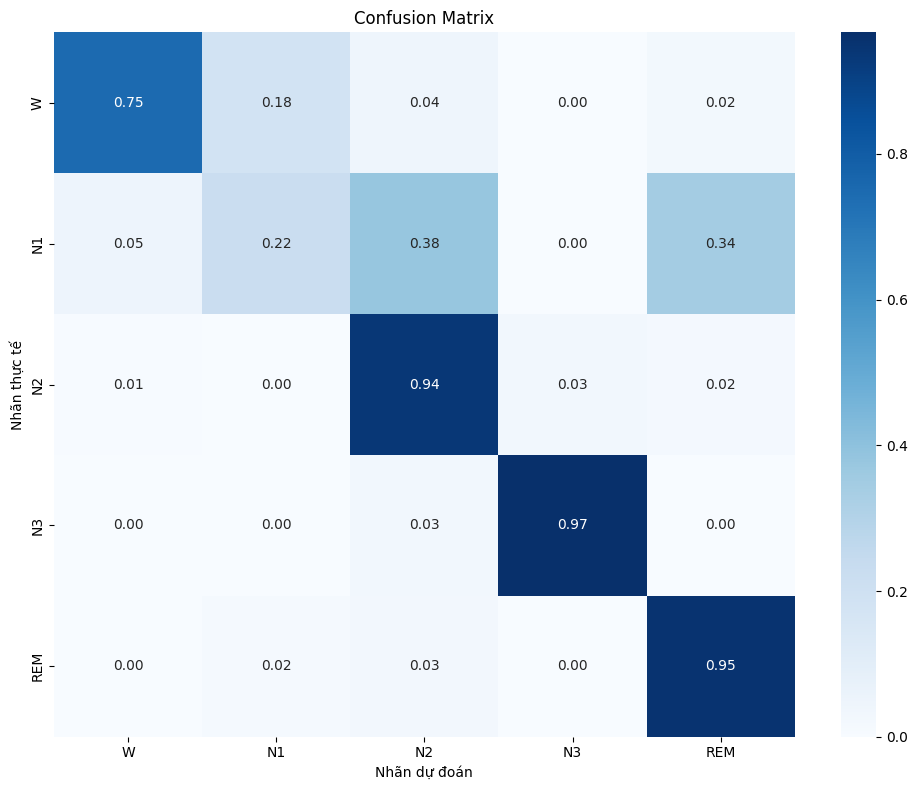

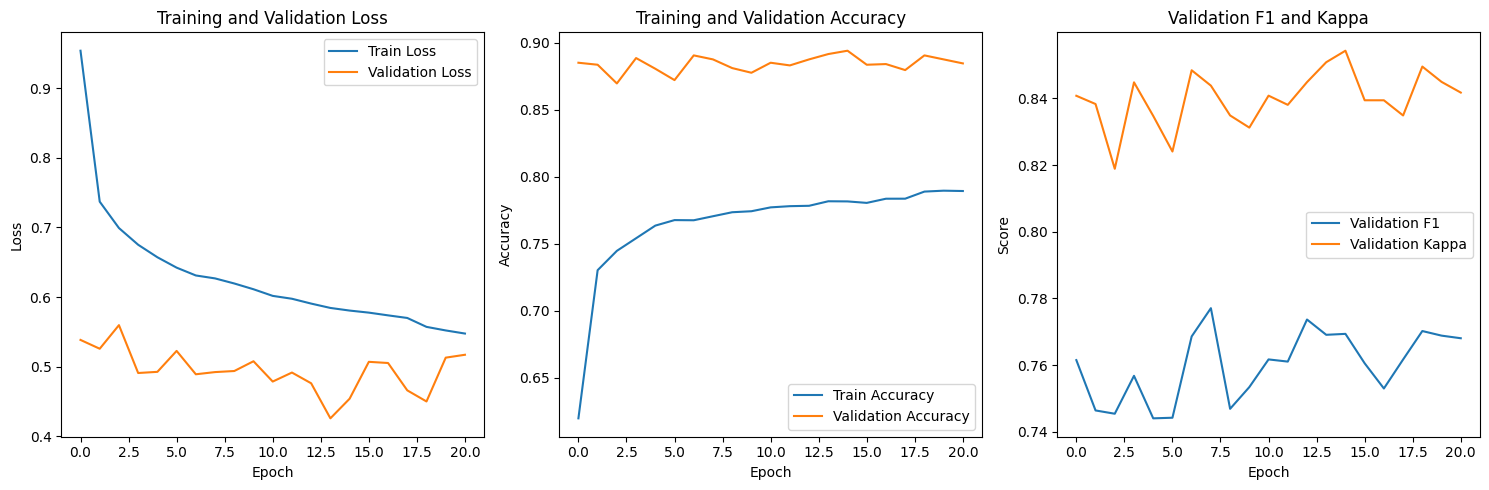


Fold 20/20
Test subject: SC4101
Initializing TinySleepNet:
  Input size: 3000
  Sampling frequency: 100 Hz
  Classes: 5
  CNN output size: 512
  GRU hidden size: 128
  GRU layers: 1 (bidirectional: True)
  GRU output size: 256
  Total parameters: 574,326

Training TinySleepNet for 200 epochs...
Early stopping patience: 7


Validation: 100%|██████████| 111/111 [00:00<00:00, 141.68it/s]


Epoch 1/200: Train Loss: 0.9741, Train Acc: 0.5949, Val Loss: 0.8591, Val Acc: 0.6721, Val F1: 0.5272, Val Kappa: 0.5030
✓ New best model saved! (Val Loss: 0.8591)


Validation: 100%|██████████| 111/111 [00:00<00:00, 135.87it/s]


Epoch 2/200: Train Loss: 0.7573, Train Acc: 0.7188, Val Loss: 0.8330, Val Acc: 0.6911, Val F1: 0.5329, Val Kappa: 0.5262
✓ New best model saved! (Val Loss: 0.8330)


Validation: 100%|██████████| 111/111 [00:00<00:00, 127.88it/s]


Epoch 3/200: Train Loss: 0.7126, Train Acc: 0.7410, Val Loss: 0.7738, Val Acc: 0.7106, Val F1: 0.5608, Val Kappa: 0.5613
✓ New best model saved! (Val Loss: 0.7738)


Validation: 100%|██████████| 111/111 [00:00<00:00, 131.72it/s]


Epoch 4/200: Train Loss: 0.6856, Train Acc: 0.7524, Val Loss: 0.7848, Val Acc: 0.7178, Val F1: 0.5636, Val Kappa: 0.5708
! No improvement for 1 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 140.19it/s]


Epoch 5/200: Train Loss: 0.6636, Train Acc: 0.7622, Val Loss: 0.7274, Val Acc: 0.7428, Val F1: 0.5591, Val Kappa: 0.6003
✓ New best model saved! (Val Loss: 0.7274)


Validation: 100%|██████████| 111/111 [00:00<00:00, 141.01it/s]


Epoch 6/200: Train Loss: 0.6447, Train Acc: 0.7675, Val Loss: 0.7017, Val Acc: 0.7491, Val F1: 0.5758, Val Kappa: 0.6112
✓ New best model saved! (Val Loss: 0.7017)


Validation: 100%|██████████| 111/111 [00:00<00:00, 136.85it/s]


Epoch 7/200: Train Loss: 0.6371, Train Acc: 0.7703, Val Loss: 0.7024, Val Acc: 0.7428, Val F1: 0.5970, Val Kappa: 0.6051
! No improvement for 1 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 130.51it/s]


Epoch 8/200: Train Loss: 0.6255, Train Acc: 0.7737, Val Loss: 0.6646, Val Acc: 0.7523, Val F1: 0.5897, Val Kappa: 0.6166
✓ New best model saved! (Val Loss: 0.6646)


Validation: 100%|██████████| 111/111 [00:00<00:00, 141.91it/s]


Epoch 9/200: Train Loss: 0.6190, Train Acc: 0.7744, Val Loss: 0.6745, Val Acc: 0.7532, Val F1: 0.5960, Val Kappa: 0.6194
! No improvement for 1 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 147.31it/s]


Epoch 10/200: Train Loss: 0.6097, Train Acc: 0.7775, Val Loss: 0.7208, Val Acc: 0.7423, Val F1: 0.5878, Val Kappa: 0.6066
! No improvement for 2 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 136.74it/s]


Epoch 11/200: Train Loss: 0.6034, Train Acc: 0.7783, Val Loss: 0.6512, Val Acc: 0.7654, Val F1: 0.6004, Val Kappa: 0.6347
✓ New best model saved! (Val Loss: 0.6512)


Validation: 100%|██████████| 111/111 [00:00<00:00, 143.68it/s]


Epoch 12/200: Train Loss: 0.5961, Train Acc: 0.7808, Val Loss: 0.7224, Val Acc: 0.7305, Val F1: 0.5907, Val Kappa: 0.5976
! No improvement for 1 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 128.79it/s]


Epoch 13/200: Train Loss: 0.5880, Train Acc: 0.7830, Val Loss: 0.6887, Val Acc: 0.7382, Val F1: 0.5881, Val Kappa: 0.5990
! No improvement for 2 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 142.21it/s]


Epoch 14/200: Train Loss: 0.5791, Train Acc: 0.7862, Val Loss: 0.6103, Val Acc: 0.7822, Val F1: 0.6075, Val Kappa: 0.6563
✓ New best model saved! (Val Loss: 0.6103)


Validation: 100%|██████████| 111/111 [00:00<00:00, 139.51it/s]


Epoch 15/200: Train Loss: 0.5790, Train Acc: 0.7838, Val Loss: 0.6928, Val Acc: 0.7355, Val F1: 0.5973, Val Kappa: 0.6028
! No improvement for 1 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 141.72it/s]


Epoch 16/200: Train Loss: 0.5786, Train Acc: 0.7847, Val Loss: 0.6734, Val Acc: 0.7640, Val F1: 0.5925, Val Kappa: 0.6288
! No improvement for 2 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 137.01it/s]


Epoch 17/200: Train Loss: 0.5717, Train Acc: 0.7857, Val Loss: 0.6526, Val Acc: 0.7591, Val F1: 0.6058, Val Kappa: 0.6302
! No improvement for 3 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 128.30it/s]


Epoch 18/200: Train Loss: 0.5717, Train Acc: 0.7854, Val Loss: 0.7406, Val Acc: 0.7192, Val F1: 0.5755, Val Kappa: 0.5792
! No improvement for 4 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 142.33it/s]


Epoch 19/200: Train Loss: 0.5548, Train Acc: 0.7915, Val Loss: 0.6745, Val Acc: 0.7600, Val F1: 0.6038, Val Kappa: 0.6303
! No improvement for 5 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 141.07it/s]


Epoch 20/200: Train Loss: 0.5500, Train Acc: 0.7959, Val Loss: 0.6932, Val Acc: 0.7400, Val F1: 0.5996, Val Kappa: 0.6086
! No improvement for 6 epochs


Validation: 100%|██████████| 111/111 [00:00<00:00, 146.04it/s]


Epoch 21/200: Train Loss: 0.5506, Train Acc: 0.7930, Val Loss: 0.6942, Val Acc: 0.7473, Val F1: 0.5912, Val Kappa: 0.6154
! No improvement for 7 epochs
Early stopping triggered after 21 epochs
✓ Loaded best model with Val Loss: 0.6103, Val Acc: 0.7822, Val F1: 0.6075, Val Kappa: 0.6563


Validation: 100%|██████████| 111/111 [00:00<00:00, 138.63it/s]



Classification Report:
              precision    recall  f1-score   support

           W     0.9463    0.7387    0.8297       310
          N1     0.3415    0.5385    0.4179       130
          N2     0.9638    0.7735    0.8582      1342
          N3     0.0769    1.0000    0.1429        12
         REM     0.6894    0.8792    0.7728       414

    accuracy                         0.7758      2208
   macro avg     0.6036    0.7860    0.6043      2208
weighted avg     0.8684    0.7758    0.8084      2208

Per-class F1 scores:
  W: 0.8297
  N1: 0.4179
  N2: 0.8582
  N3: 0.1429
  REM: 0.7728


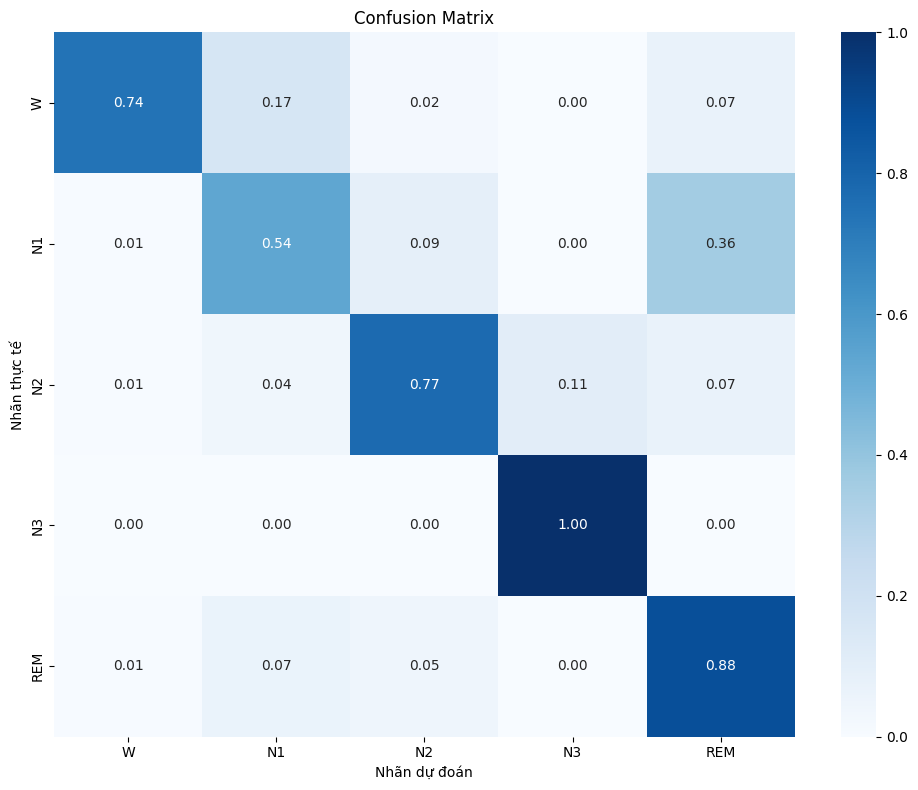

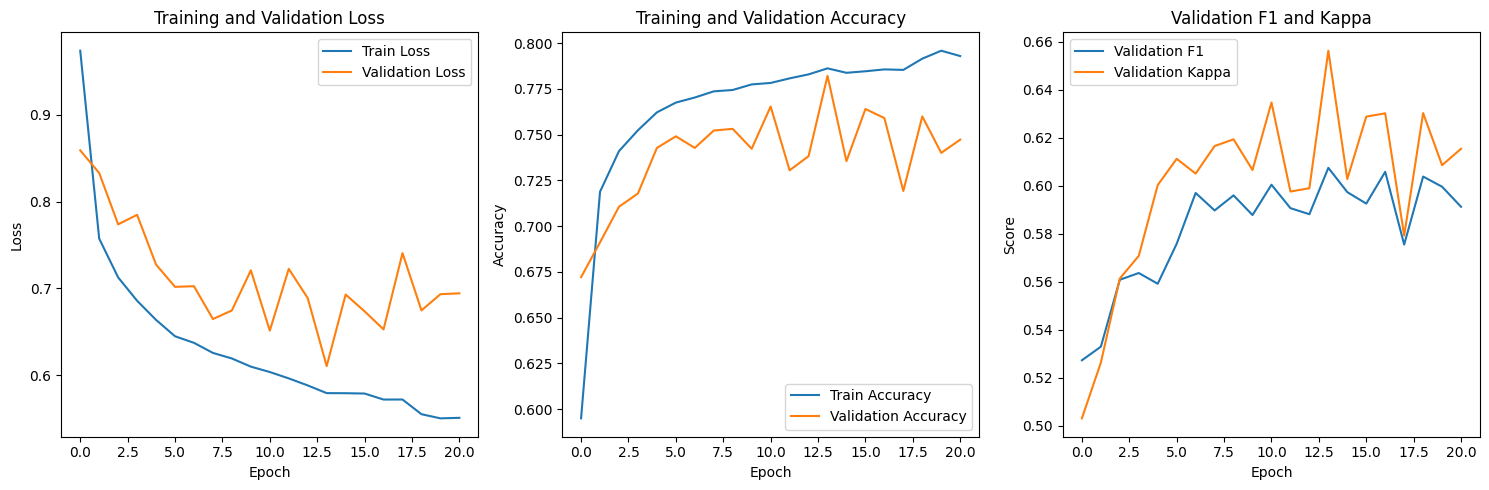


CROSS VALIDATION RESULTS
Average Accuracy: 0.8128 ± 0.0451
Average F1 Macro: 0.7399 ± 0.0566
Average Kappa: 0.7426 ± 0.0621

✓ TinySleepNet cross-validation completed!


In [8]:
# Cell 8: Run TinySleepNet với K-Fold Cross-Validation

# Lấy số lượng fold từ cấu hình
n_folds_to_run = min(CONFIG['n_folds'], len(folds))
print(f"\nRunning {n_folds_to_run} folds for cross-validation...")

# Thực hiện đánh giá cross-validation
results = run_k_fold_cross_validation(
    folds[:n_folds_to_run],  # Chỉ chạy số fold được chỉ định trong CONFIG
    subjects_data,
    config=CONFIG
)

# Lưu kết quả nếu cần
# Uncomment dòng dưới đây để lưu kết quả
# with open('tinysleepnet_results.pkl', 'wb') as f:
#     pickle.dump(results, f)

print("\n✓ TinySleepNet cross-validation completed!")